 # TEAM LOS GALACTICOS PROJECT CODE

# Initial Settings

## Libraries

In [1]:
#Libraries
require(data.table, quietly = TRUE)
require(glue, quietly = TRUE)
require(ggplot2, quietly = TRUE)
require(scatterplot3d, quietly = TRUE)
require(gridExtra, quietly = TRUE)
require(tidyr, quietly = TRUE)
require(tseries, quietly = TRUE)

library(pROC, quietly = TRUE)
library(caret, quietly = TRUE)
library(rpart, quietly = TRUE)
library(rpart.plot, quietly = TRUE)
library(e1071, quietly = TRUE)
require(tiger)
require(feather)

# Required packages for submission
require(jsonlite)
require(httr)

Warning message:
"package 'glue' was built under R version 3.6.3"Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'gridExtra' was built under R version 3.6.3"Warning message:
"package 'tidyr' was built under R version 3.6.3"Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
"package 'pROC' was built under R version 3.6.3"Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following objects are masked from 'package:stats':

    cov, smooth, var

Warning message:
"package 'caret' was built under R version 3.6.3"Warning message:
"package 'rpart' was built under R version 3.6.3"Warning message:
"package 'rpart.plot' was built under R version 3.6.3"Warning message:
"package 'e1071' was built under R version 3.6.3"Loading required package: tiger
Warning message:
"package 'tiger' was buil

## Dataload

In [2]:
#Dataload
allpath <- "Data/IE582_Fall20_ProjectTrain.csv"
alldata <- read.csv(allpath)

submitdatapath <- "Data/IE582_Fall20_ProjectTest.csv"
submitdata <- read.csv(submitdatapath)

submitdata <- submitdata[,-61] # Empty y column of the submission data set


## Submission Settings

In [3]:
get_token <- function(username, password, url_site){
    
    post_body = list(username=username,password=password)
    post_url_string = paste0(url_site,'/token/')
    result = POST(post_url_string, body = post_body)

    # error handling (wrong credentials)
    if(result$status_code==400){
        print('Check your credentials')
        return(0)
    }
    else if (result$status_code==201){
        output = content(result)
        token = output$key
    }

    return(token)
}

In [4]:
send_submission <- function(predictions, token, url_site, submit_now=F){
    
    format_check=check_format(predictions)
    if(!format_check){
        return(FALSE)
    }
    
    post_string="list("
    for(i in 1:length(predictions)){
        if(i<length(predictions)){
            post_string=sprintf("%s%s,",post_string,predictions[i])
        } else {
            post_string=sprintf("%s%s)",post_string,predictions[i])
        }
    }
    
    submission = eval(parse(text=post_string))
    json_body = jsonlite::toJSON(submission, auto_unbox = TRUE)
    submission=list(submission=json_body)
    print(submission)

    if(!submit_now){
        print("You did not submit.")
        return(FALSE)      
    }
    

    header = add_headers(c(Authorization=paste('Token',token,sep=' ')))
    post_url_string = paste0(url_site,'/submission/')
    result = POST(post_url_string, header, body=submission)
    
    if (result$status_code==201){
        print("Successfully submitted. Below you can see the details of your submission")
    } else {
        print("Could not submit. Please check the error message below, contact the assistant if needed.")
    }
    
    print(content(result))
    
}

In [5]:
check_format <- function(predictions){
    
    if(all(is.numeric(predictions)) & all(predictions<=1)){
        print("Format OK")
        return(TRUE)
    } else {
        print("Wrong format")
        return(FALSE)
    }
    
}

In [6]:
# this part is main code
subm_url ='http://46.101.121.83'

u_name = "Los Galacticos"
p_word = "E6lOux9kirvumsWW"
submit_now = FALSE

username = u_name
password = p_word

token = get_token(username=u_name, password=p_word, url=subm_url)
token

[1] "59900fa65e181d65c4c676e8904fbdf065448577"

## Performance Metrics

In [7]:
BER <- function(predicted, actual){
  confusion_table = table(predicted,actual)
  TP = confusion_table[2,2]
  TN = confusion_table[1,1]
  FN = confusion_table[1,2]
  FP = confusion_table[2,1]
  accuracy = ((FP/(sum(TN+FP))+FN/(sum(FN+TP)))*0.5)
  return(accuracy)
}

Performance <- function(prediction,target,weight = 0.5, prnt = FALSE ){
    
    BA <- 1 - BER(prediction, target )
    curve <- roc(as.numeric(prediction), as.numeric(target) )
    AUC <- auc(curve)
    
    if (prnt){
        print("BA: ")
        print(BA)
        print(AUC)
    }
    
    return( BA*weight + (1-weight)*AUC )
}

# PerformanceLoss <- function(data,...){
#     twoClassSummary
#     twoClassSummary(data, lev = NULL, model = )
# }



## Data Exploration

In [8]:
table(alldata[,c("x37","y")])

   y
x37    a    b
  0 1564  509
  1    1    0

In [9]:
summary(alldata)

       x1              x2               x3              x4        
 Min.   :13.00   Min.   :0.0000   Min.   :0.000   Min.   :0.0000  
 1st Qu.:27.00   1st Qu.:0.0000   1st Qu.:0.000   1st Qu.:0.0000  
 Median :30.00   Median :1.0000   Median :1.000   Median :1.0000  
 Mean   :30.09   Mean   :0.6712   Mean   :0.662   Mean   :0.6905  
 3rd Qu.:33.00   3rd Qu.:1.0000   3rd Qu.:1.000   3rd Qu.:1.0000  
 Max.   :50.00   Max.   :1.0000   Max.   :1.000   Max.   :1.0000  
       x5               x6              x7               x8       
 Min.   : 0.000   Min.   : 0.00   Min.   : 0.000   Min.   :13.00  
 1st Qu.: 4.000   1st Qu.: 4.00   1st Qu.: 4.000   1st Qu.:26.00  
 Median : 9.000   Median : 9.00   Median : 9.000   Median :30.00  
 Mean   : 9.083   Mean   : 8.99   Mean   : 9.109   Mean   :30.17  
 3rd Qu.:14.000   3rd Qu.:14.00   3rd Qu.:14.000   3rd Qu.:34.00  
 Max.   :18.000   Max.   :18.00   Max.   :18.000   Max.   :49.00  
       x9              x10              x11              x12  

In [10]:
sapply(alldata, table)  #col 50 and 52 gerekli değil (Tamamen 0)

$x1

 13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32 
  1   1   2   1   3   3  12  16  28  30  50  77 100 126 148 180 182 177 166 172 
 33  34  35  36  37  38  39  40  41  42  43  44  45  47  49  50 
133 108 106  66  63  38  28  23  13   9   4   4   1   1   1   1 

$x2

   0    1 
 682 1392 

$x3

   0    1 
 701 1373 

$x4

   0    1 
 642 1432 

$x5

  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18 
105 118 113 105 107 102  91 122 118 112 107  92  94 117 121  90 123 120 117 

$x6

  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18 
113 113 126 103 128  97 111  93 101 126  93  90  97 113  89 120 136 109 116 

$x7

  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18 
127 105  98  90 103 100 102 125 112 120 112 101 111  98 122 106 112 121 109 

$x8

 13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32 
  1   1   1   5   7  14  14  35  35  55  76  81 102 

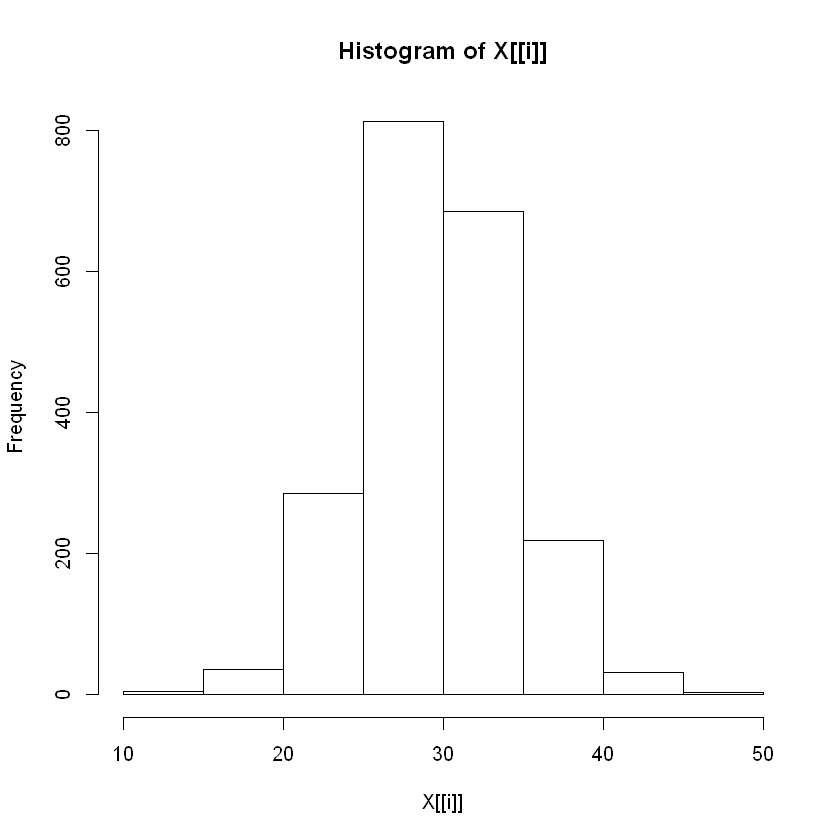

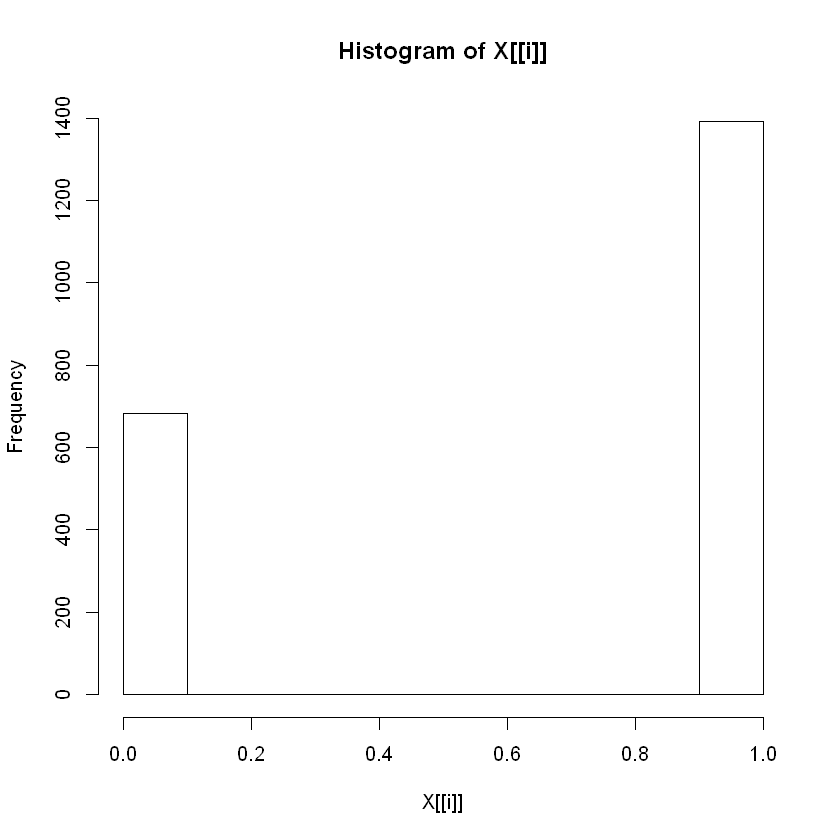

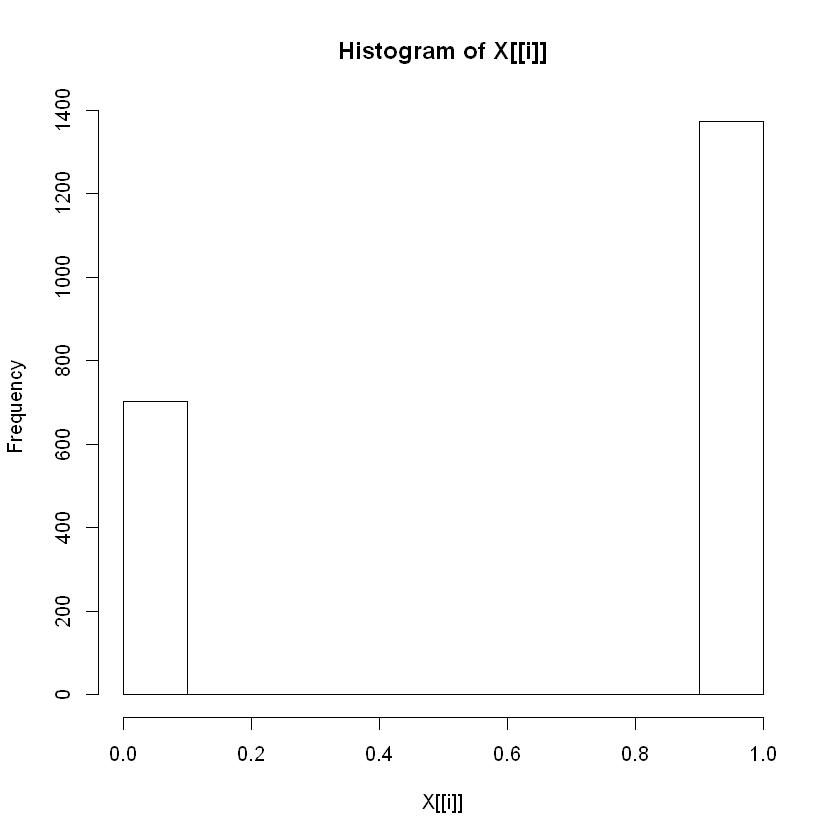

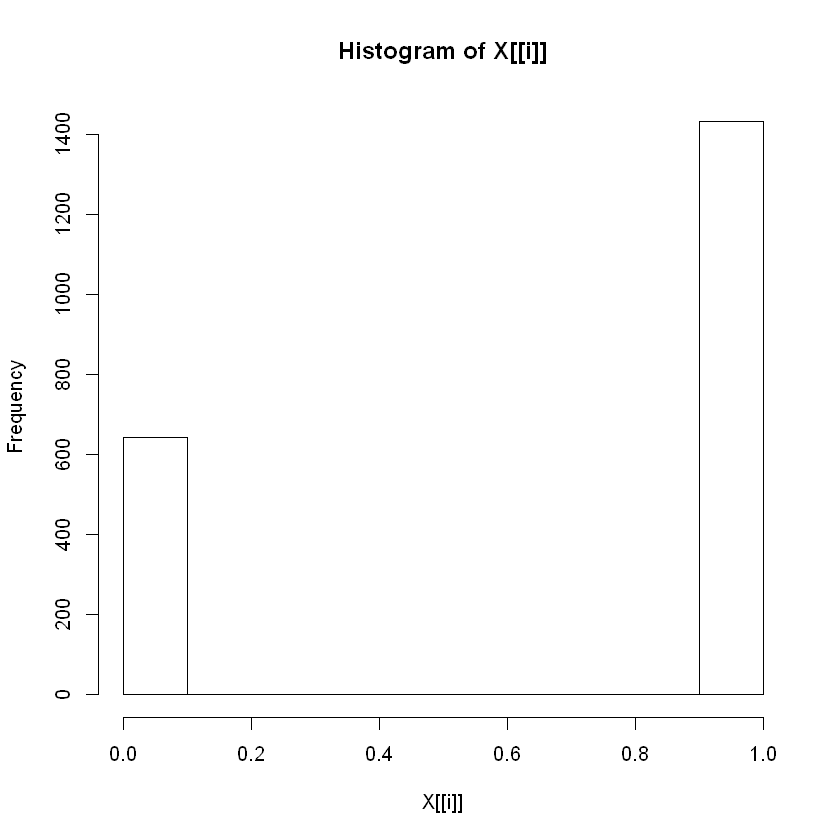

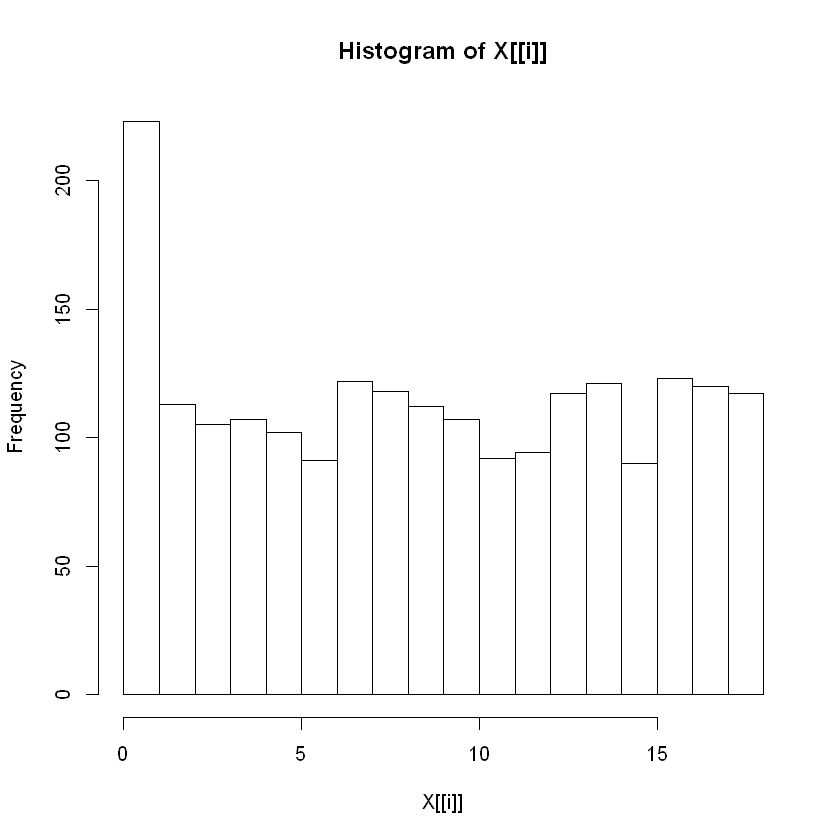

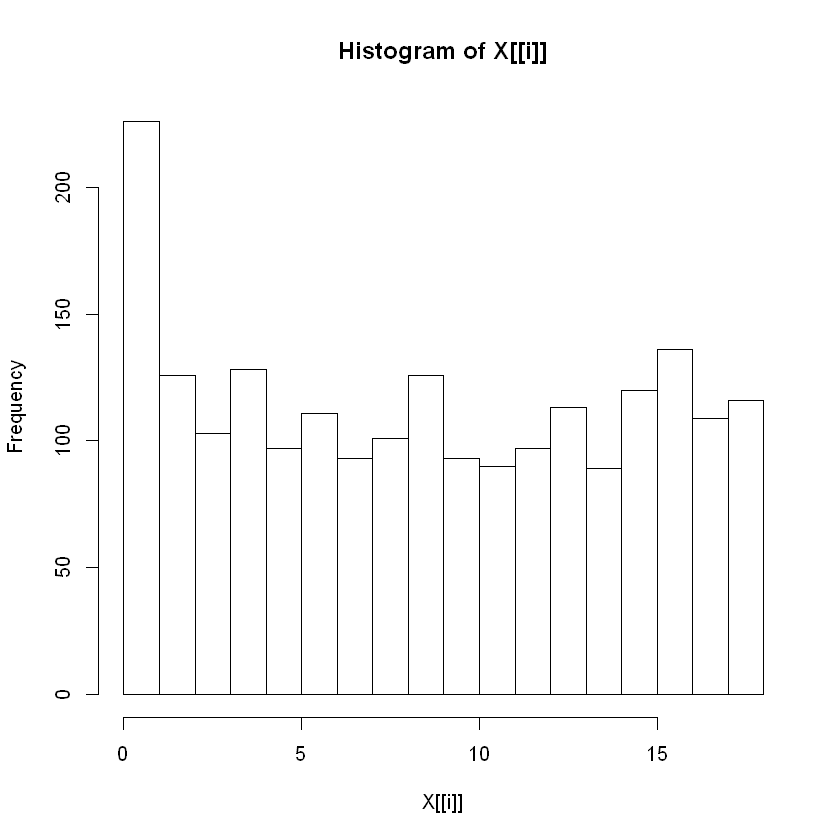

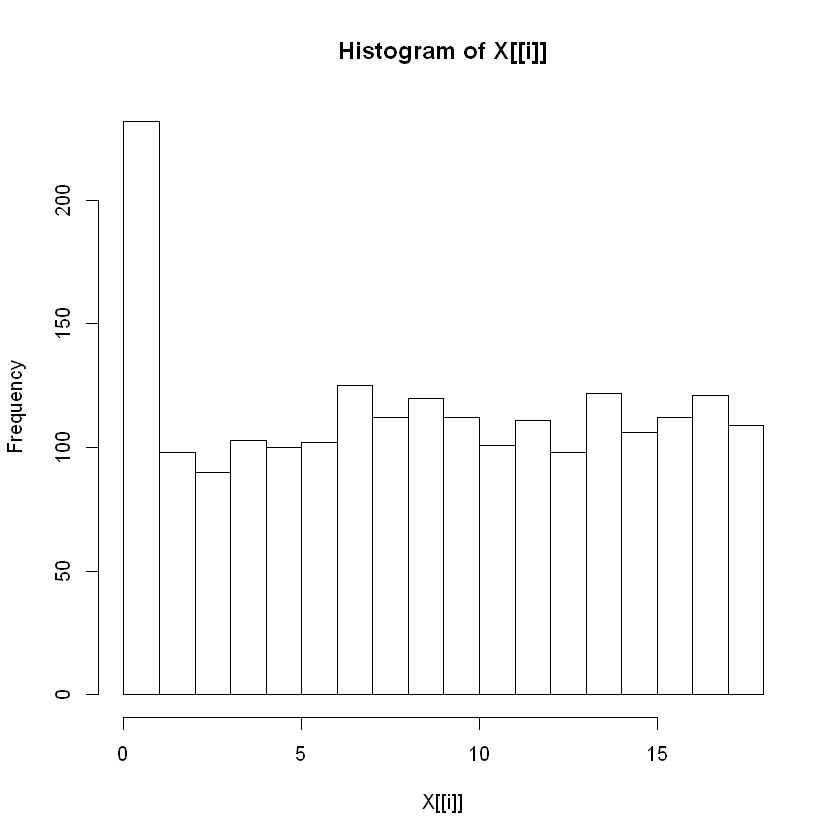

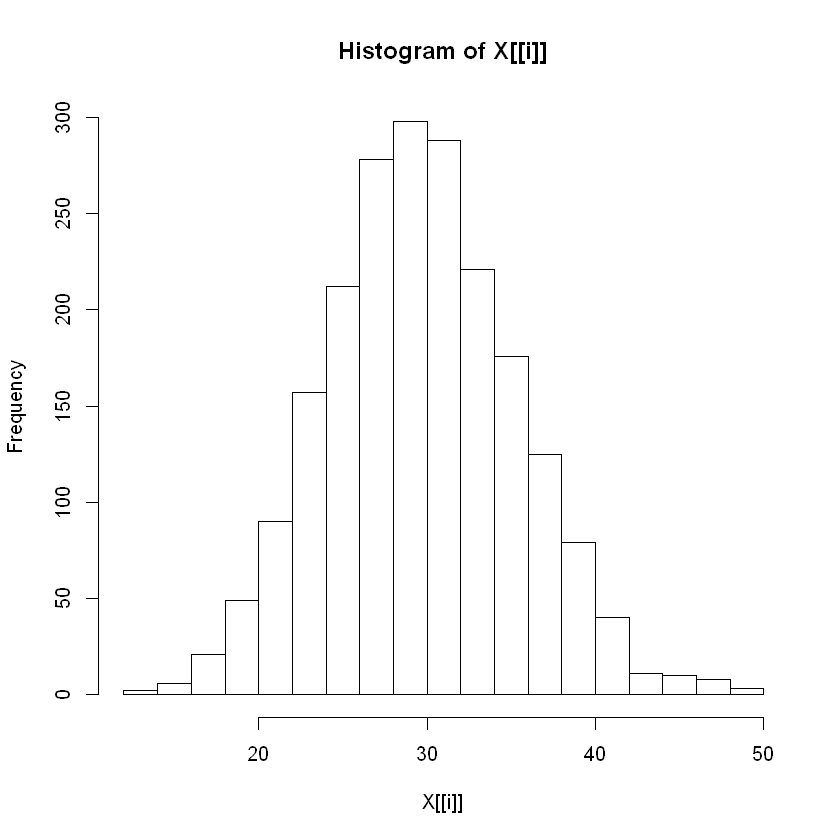

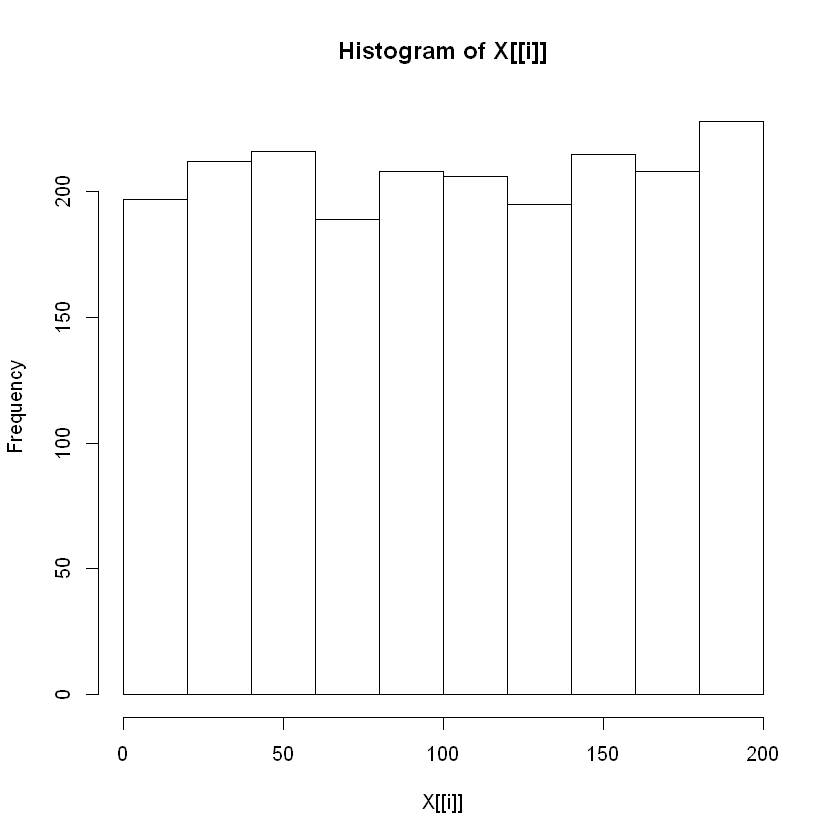

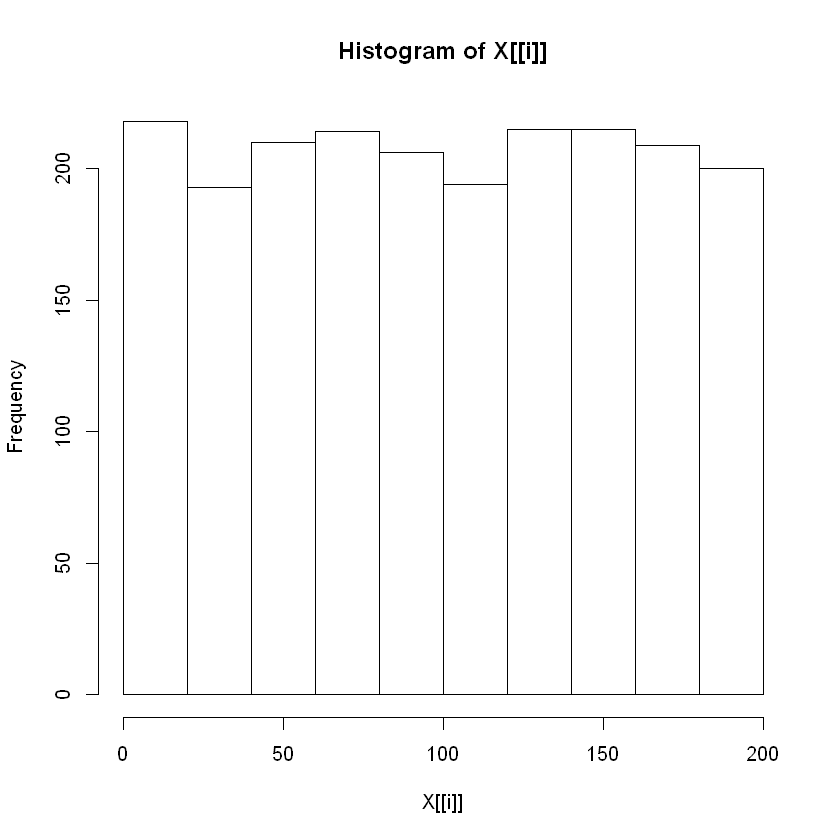

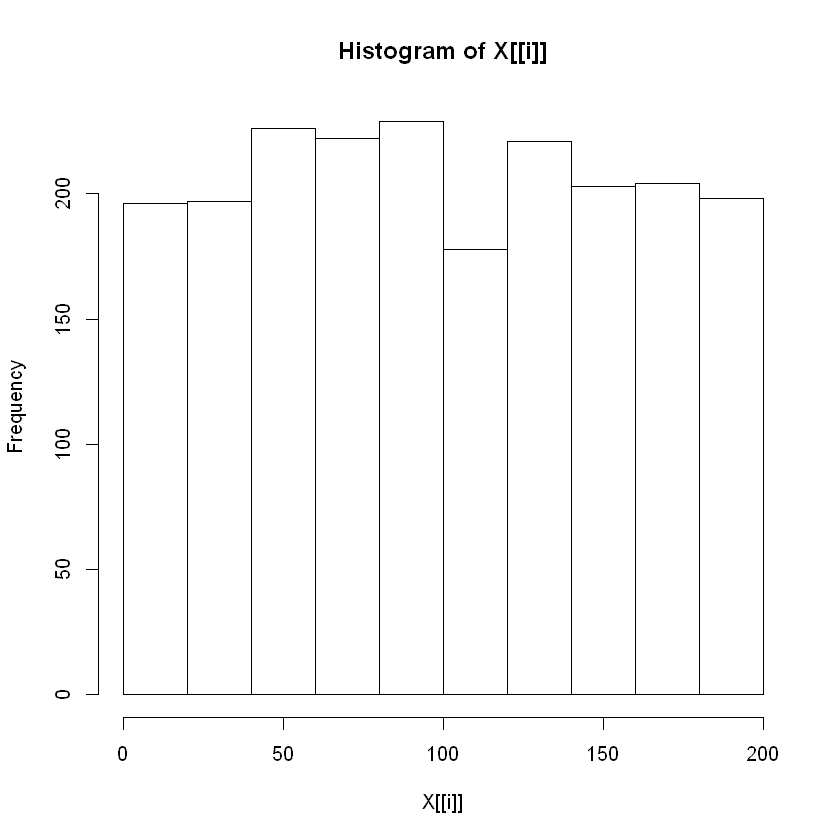

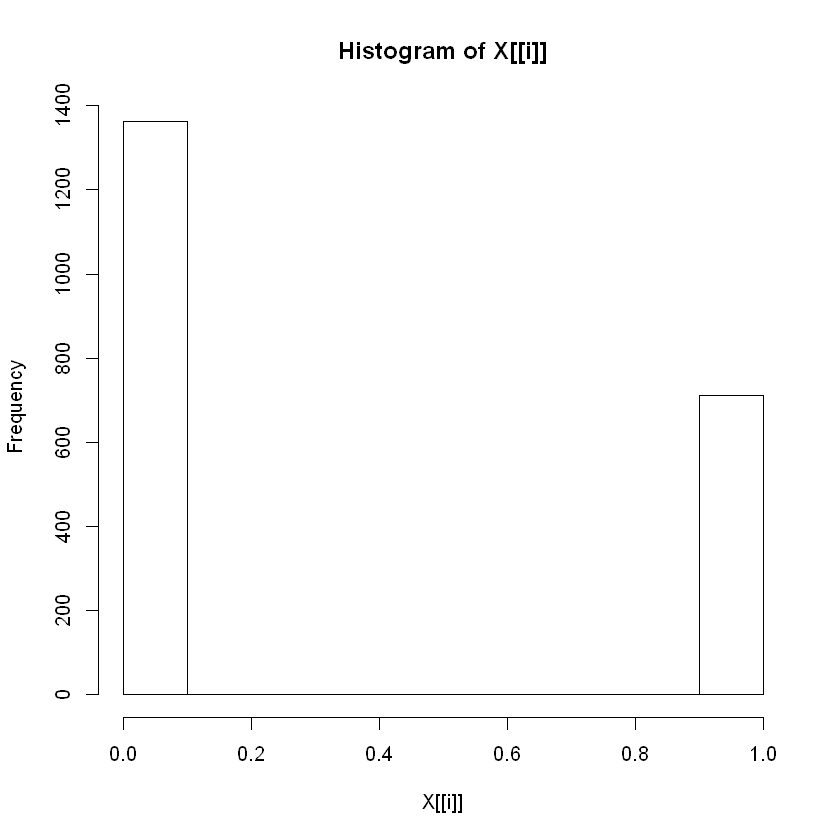

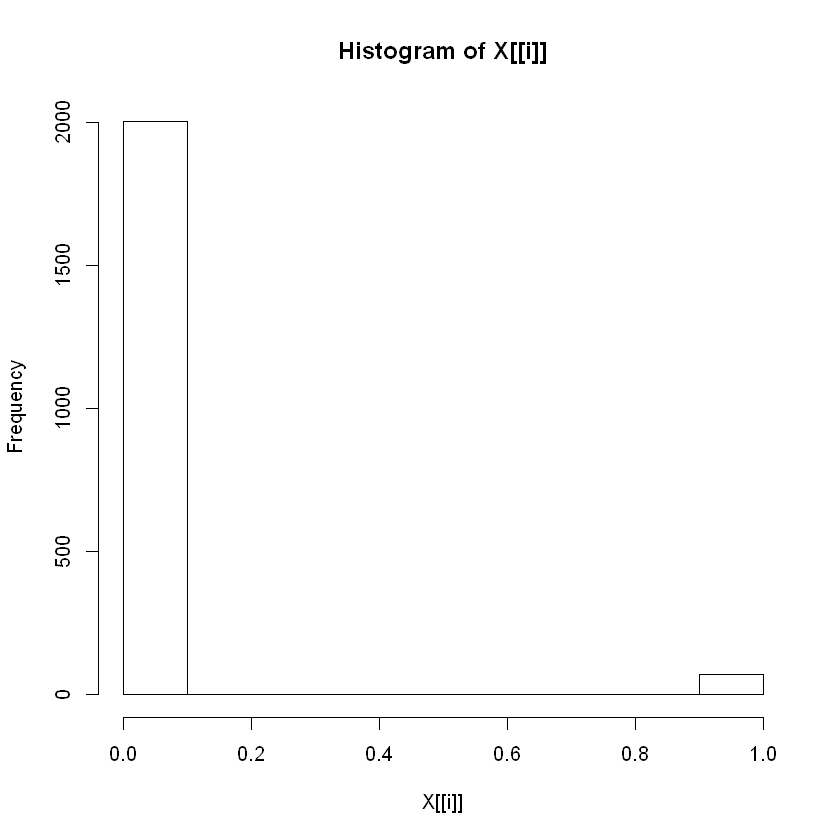

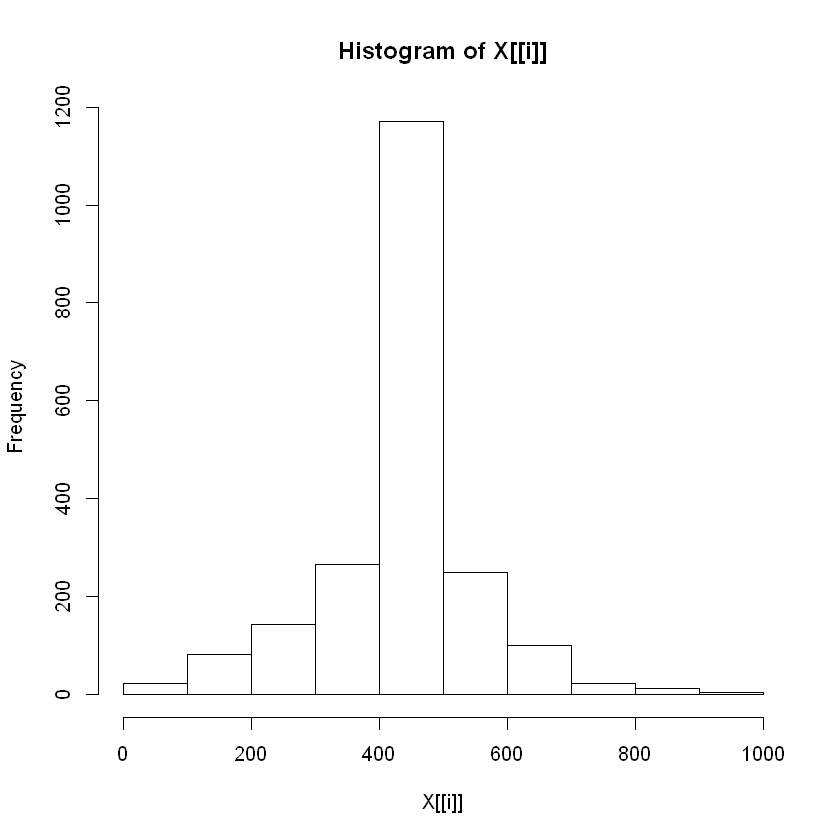

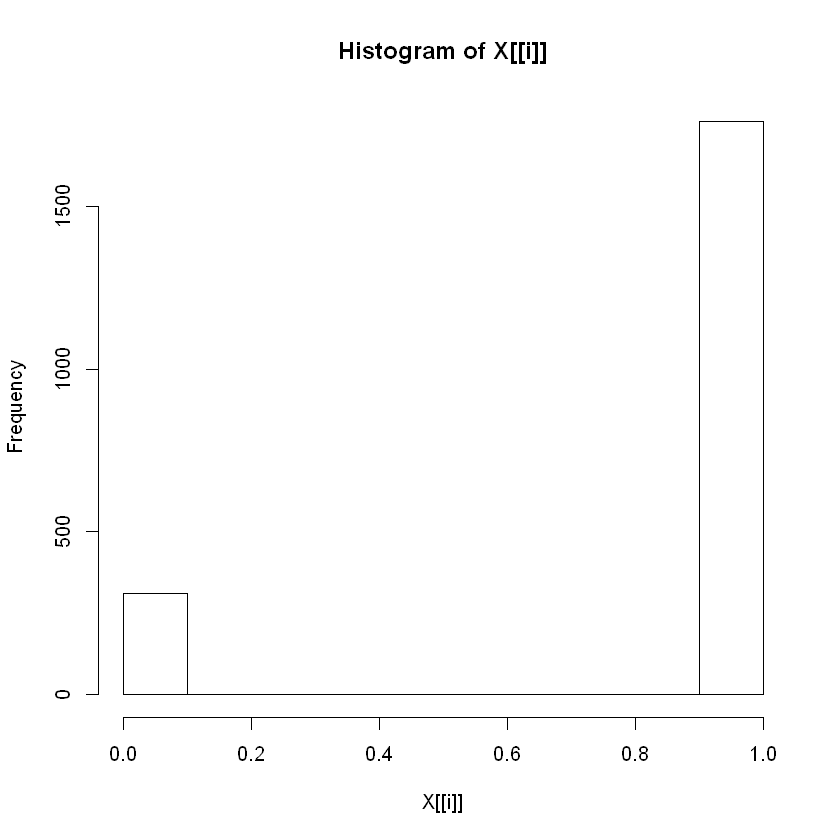

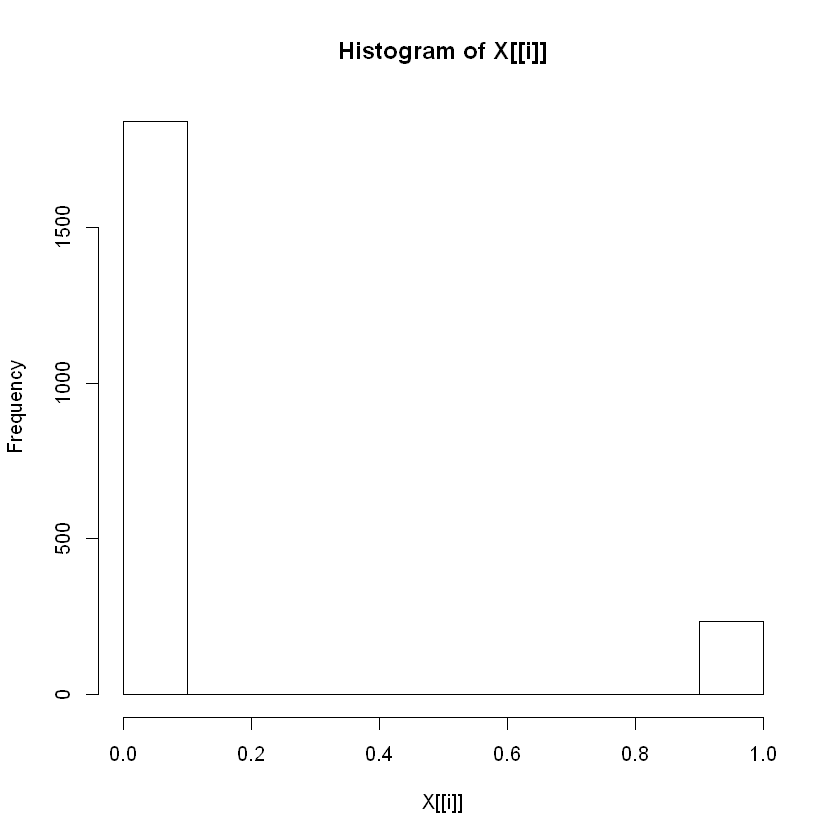

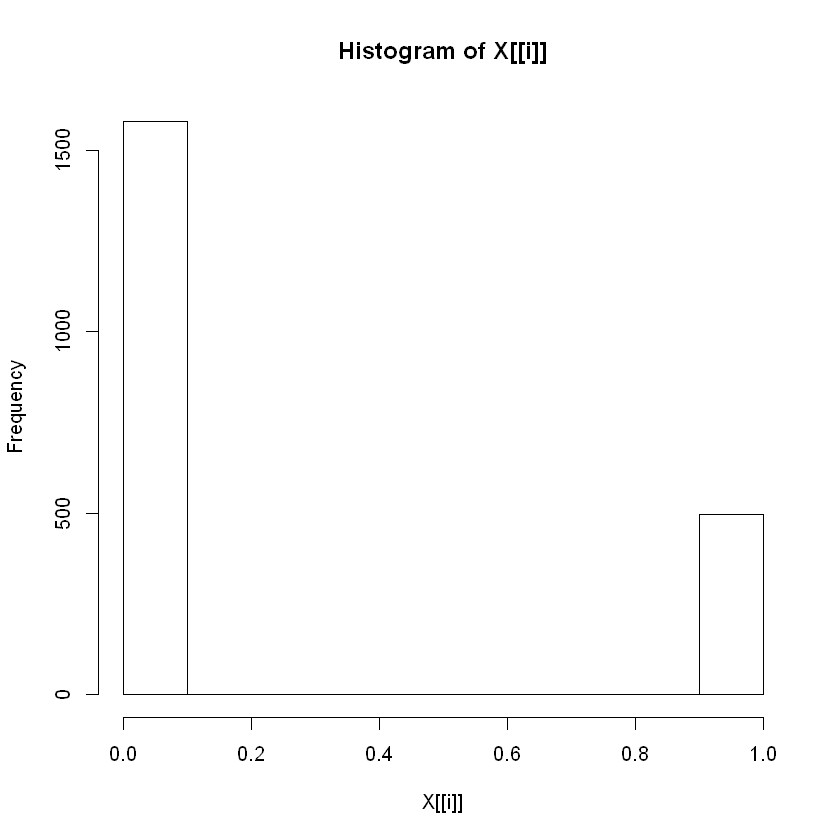

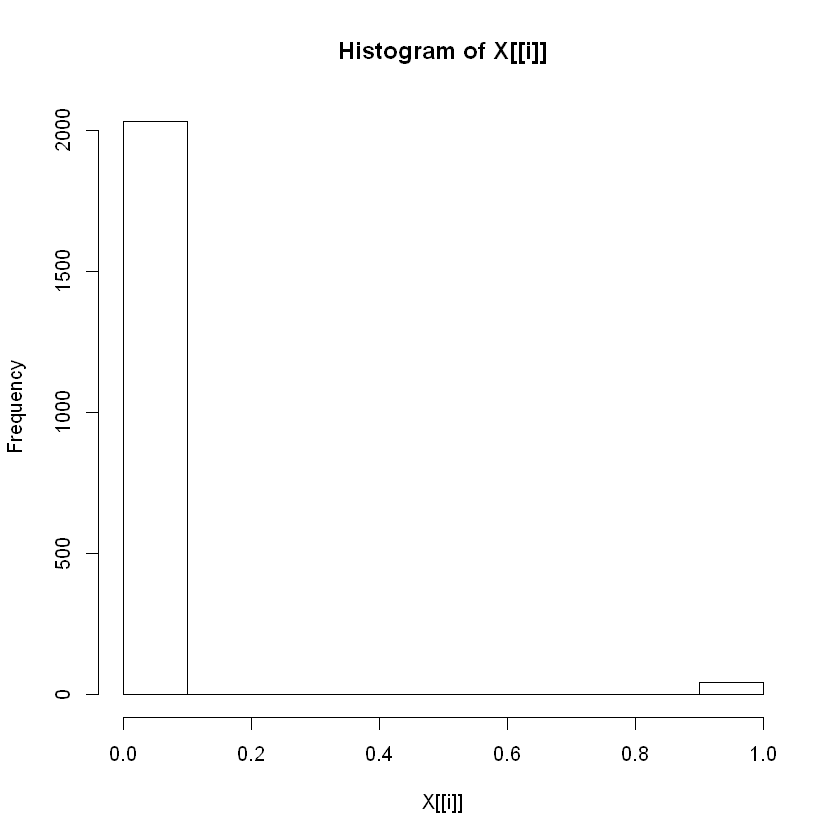

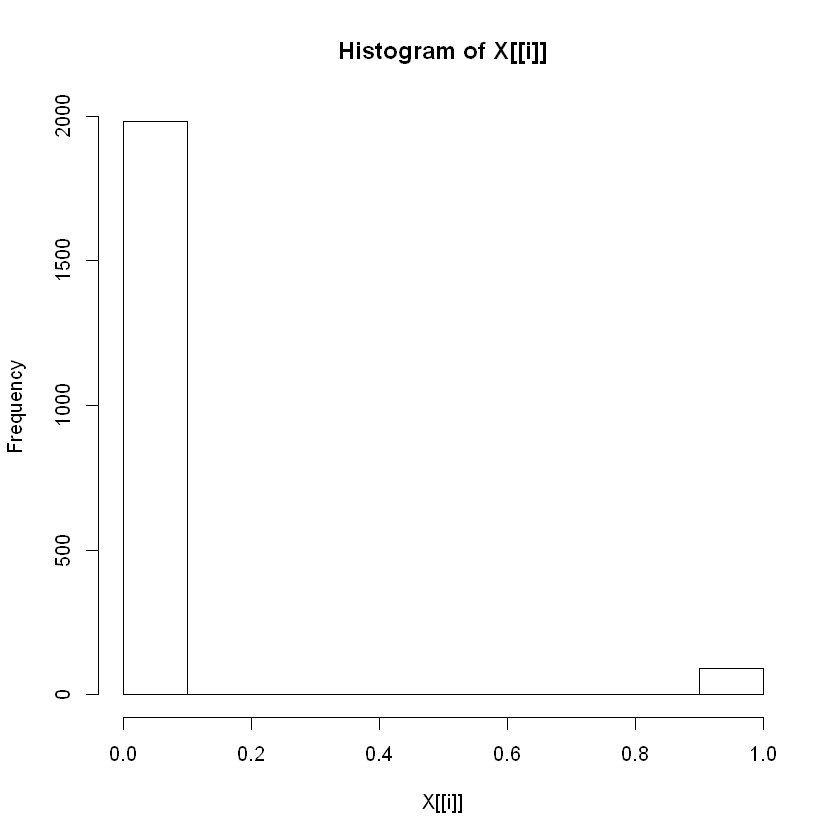

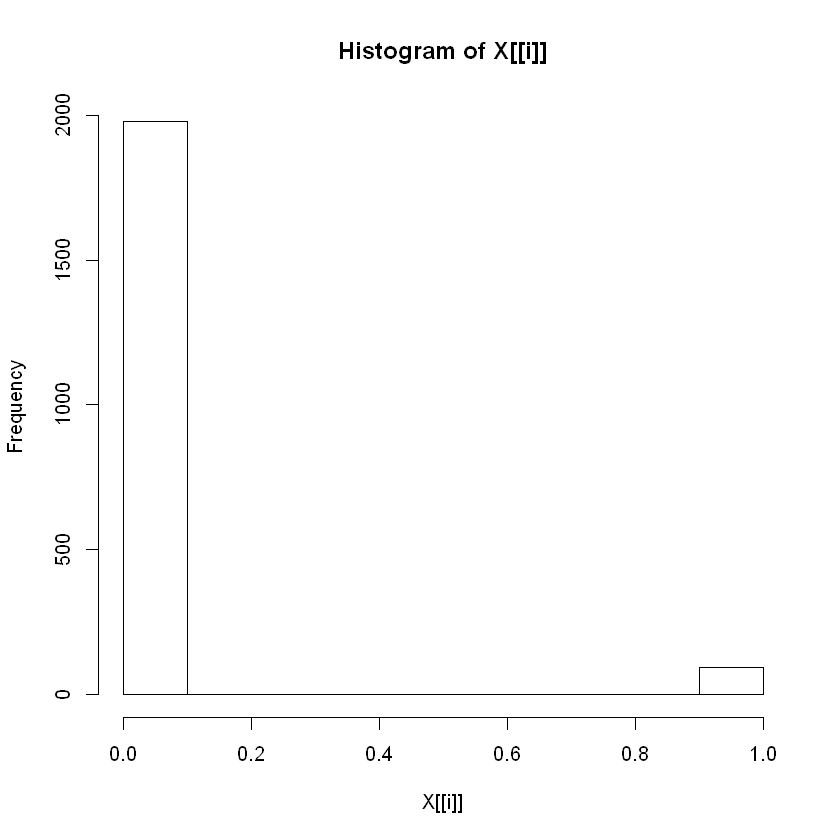

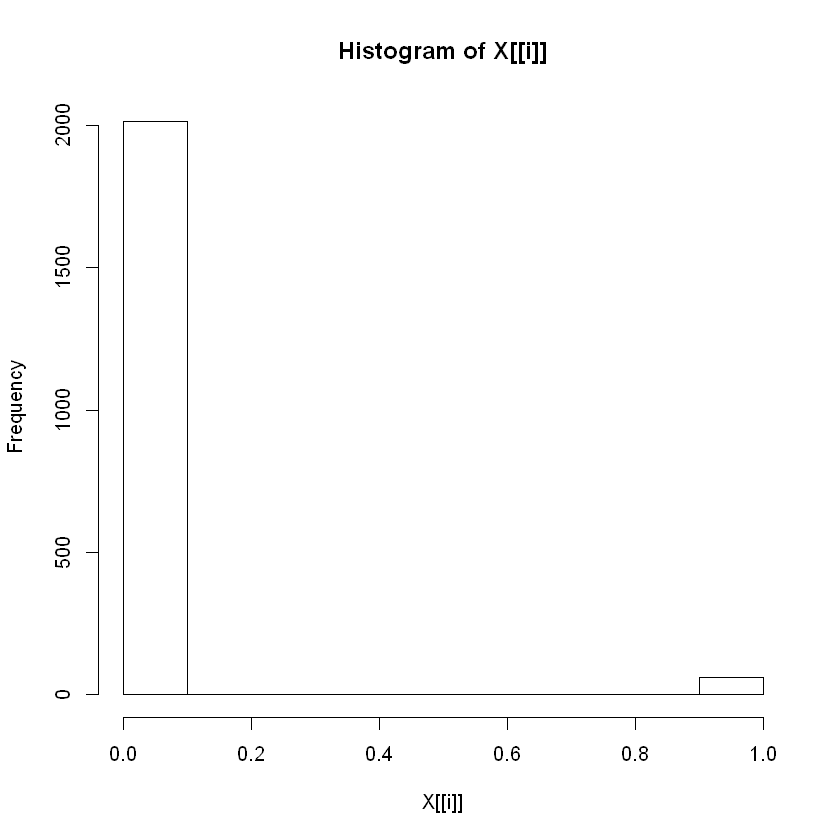

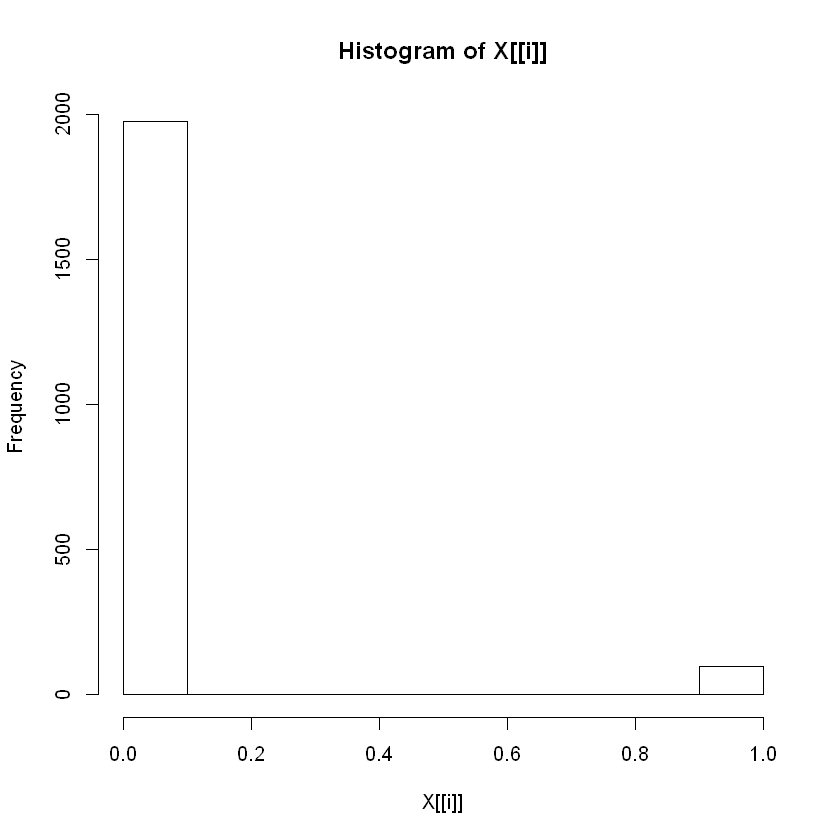

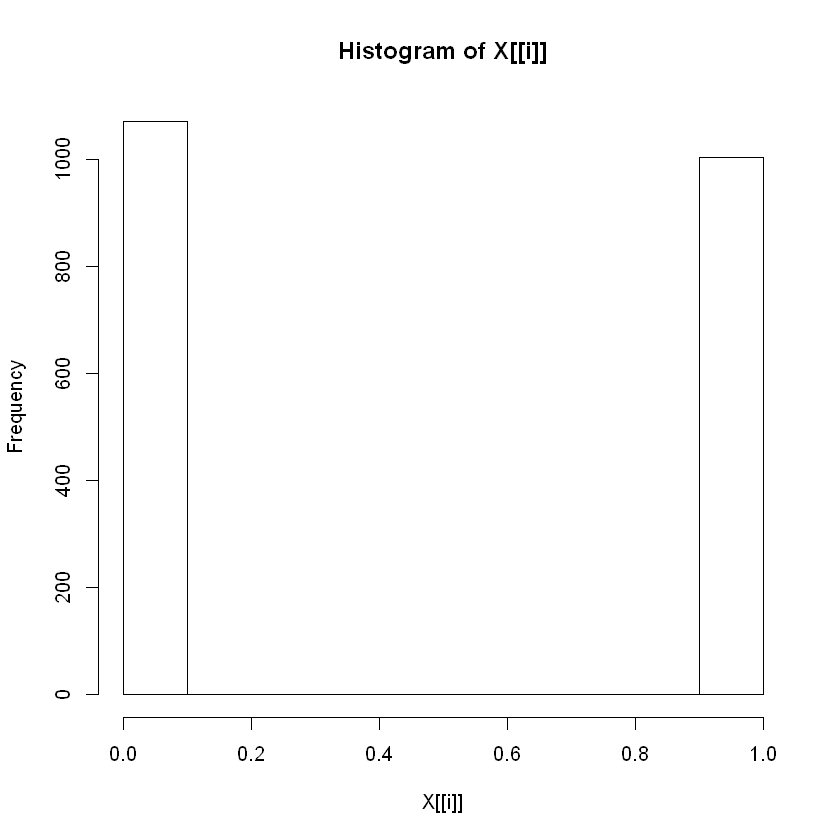

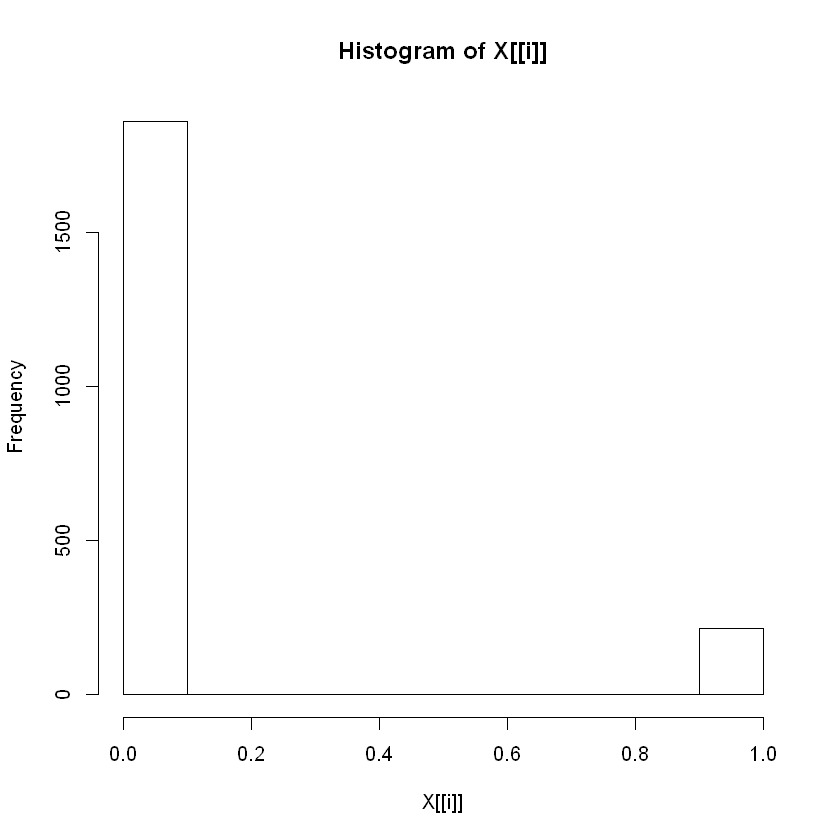

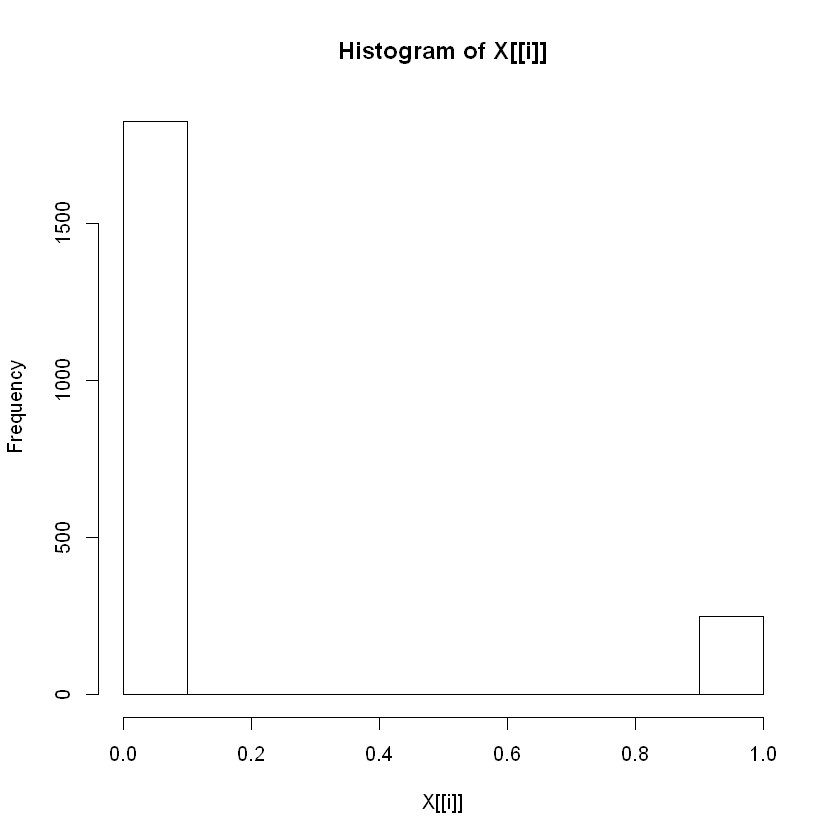

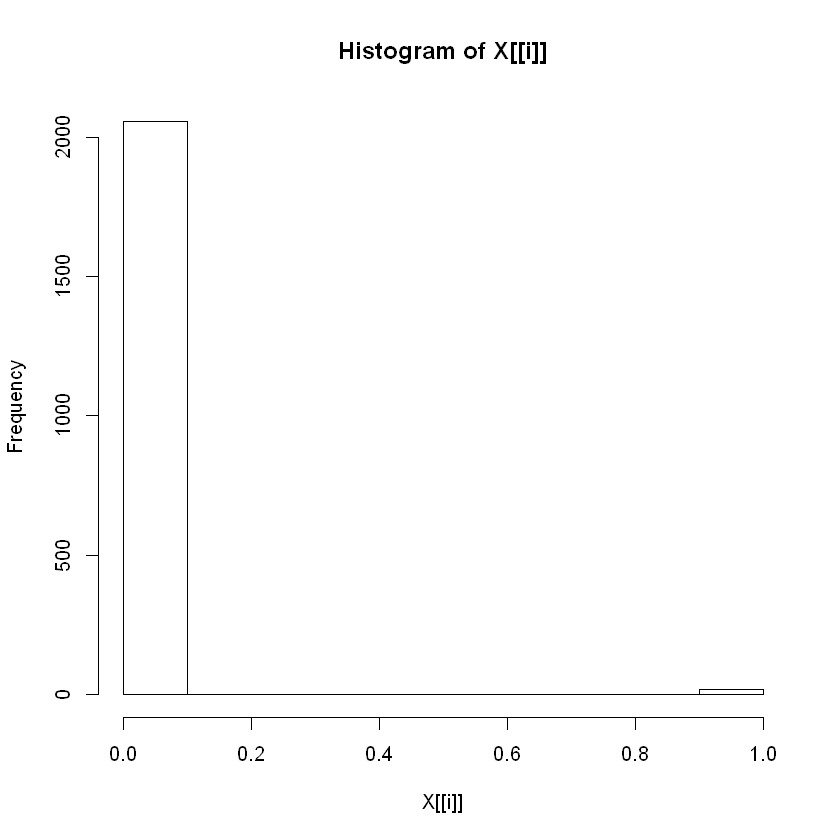

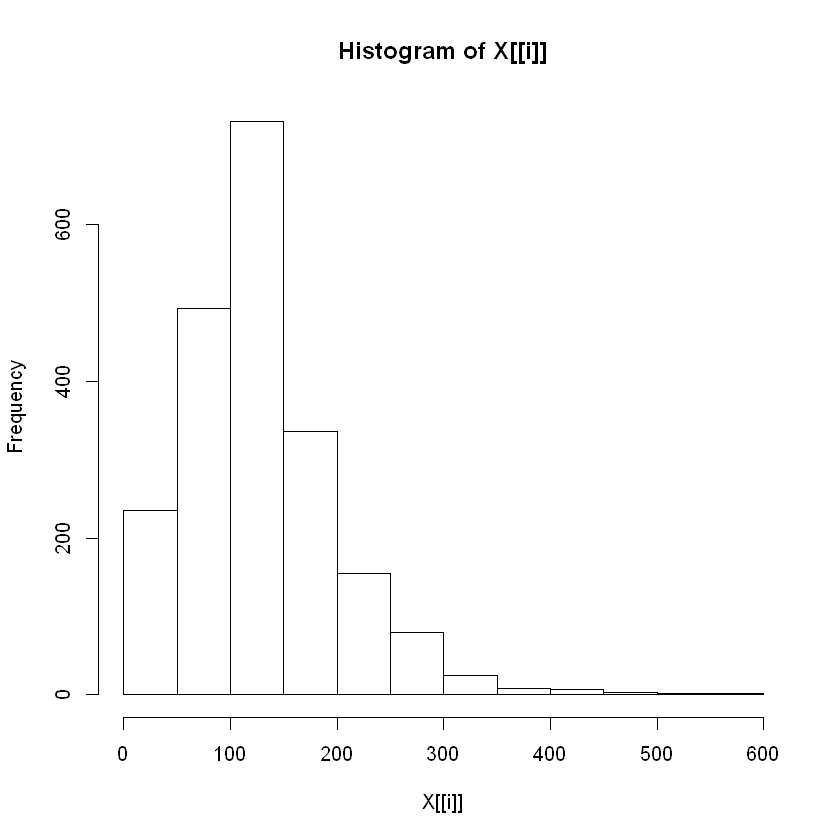

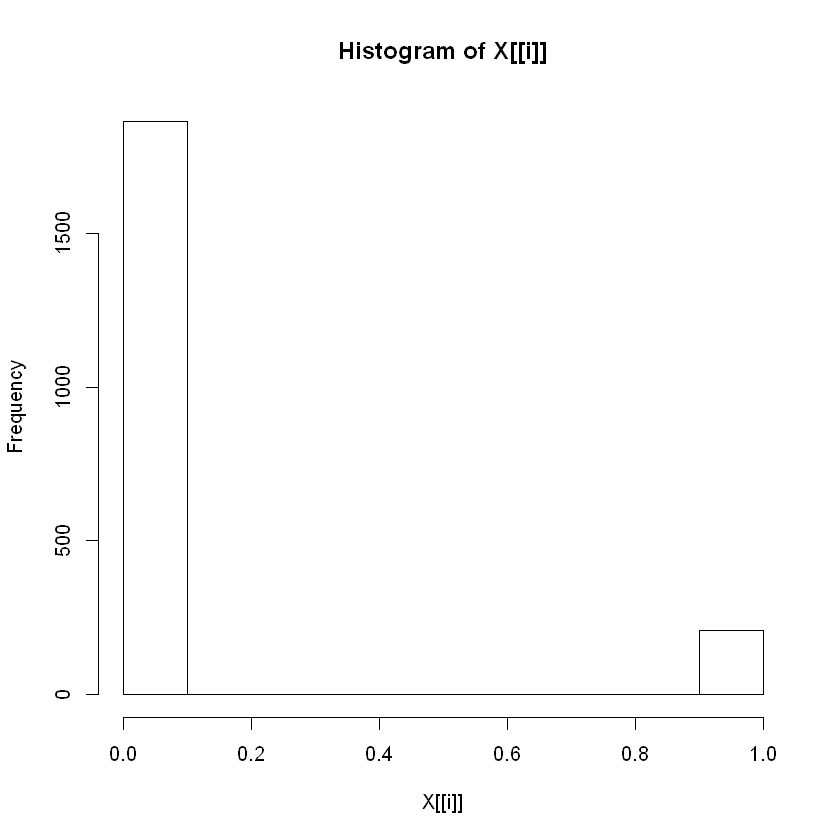

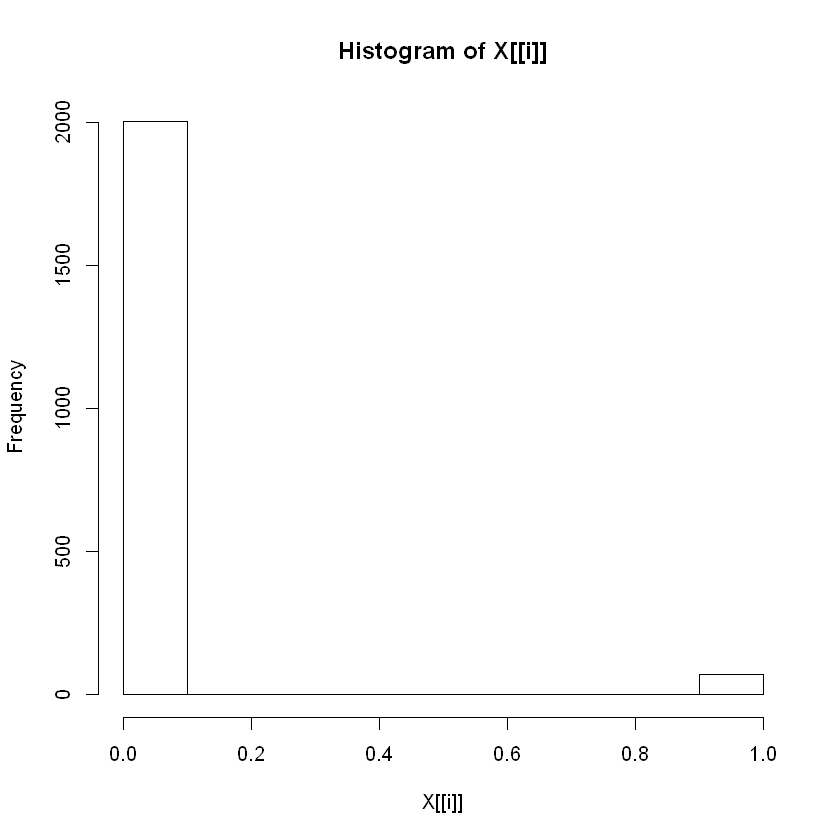

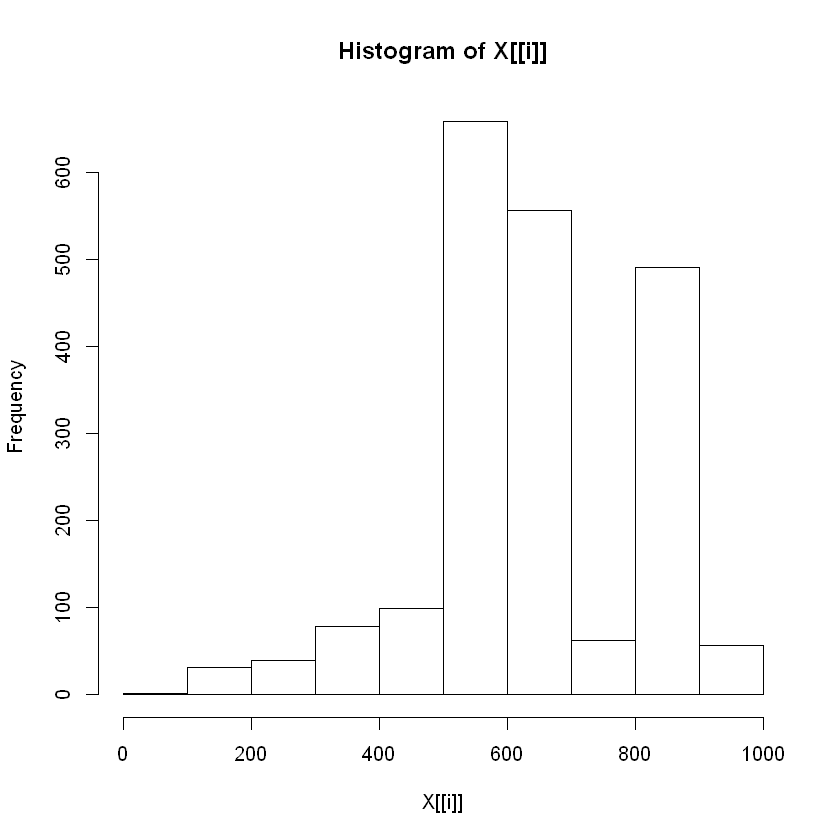

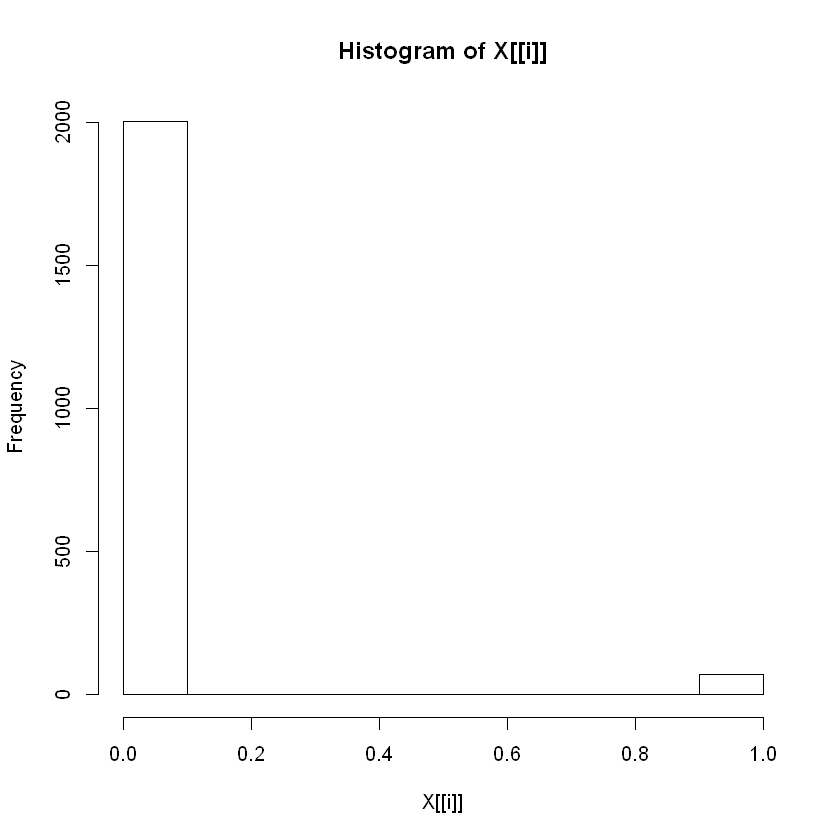

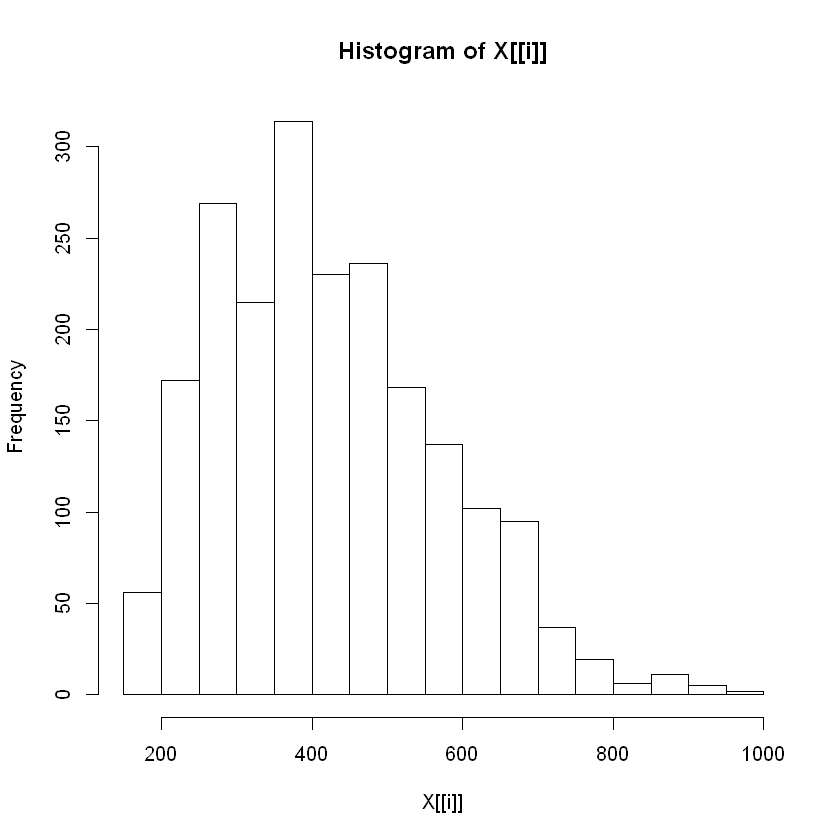

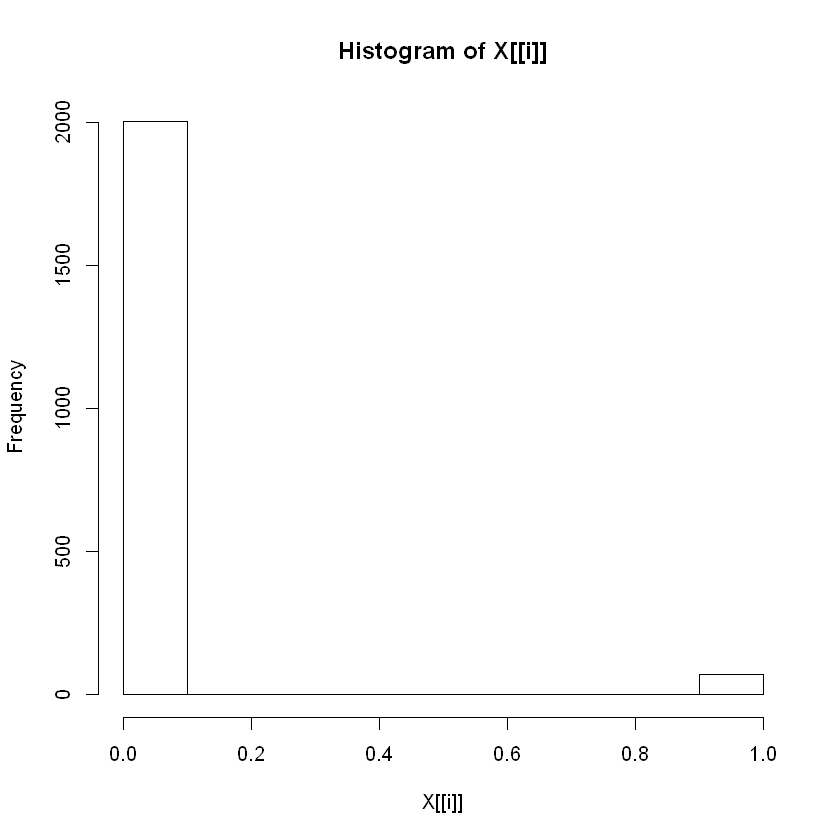

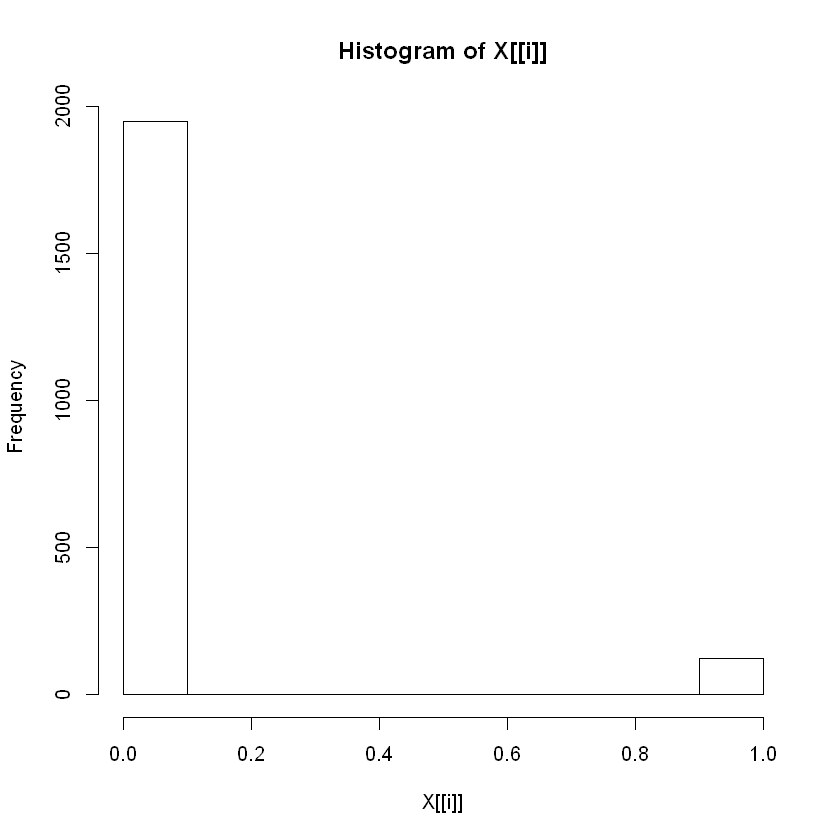

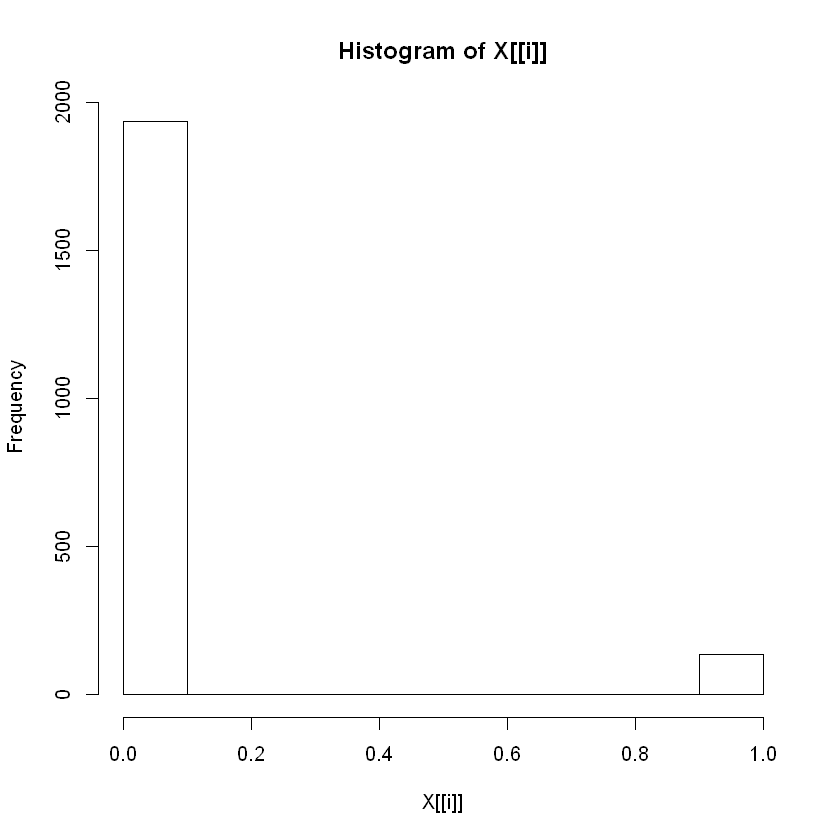

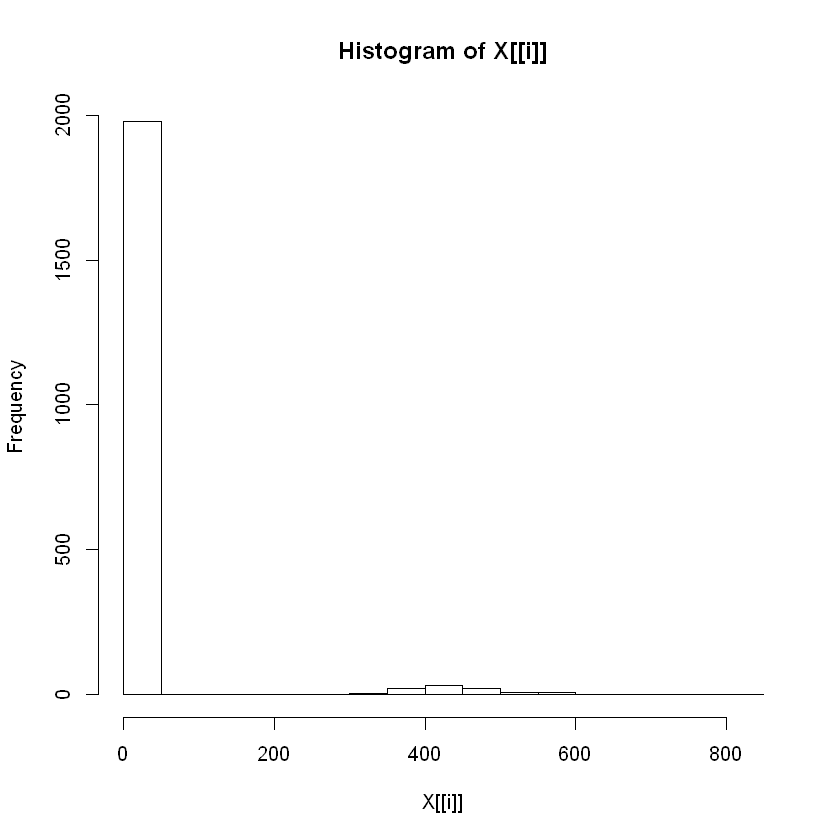

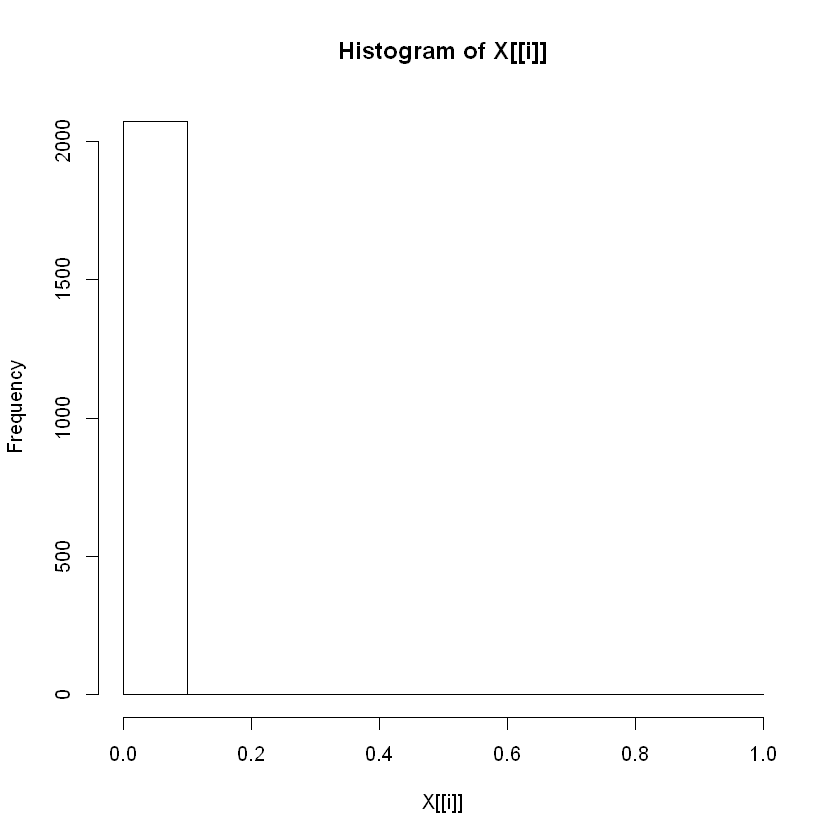

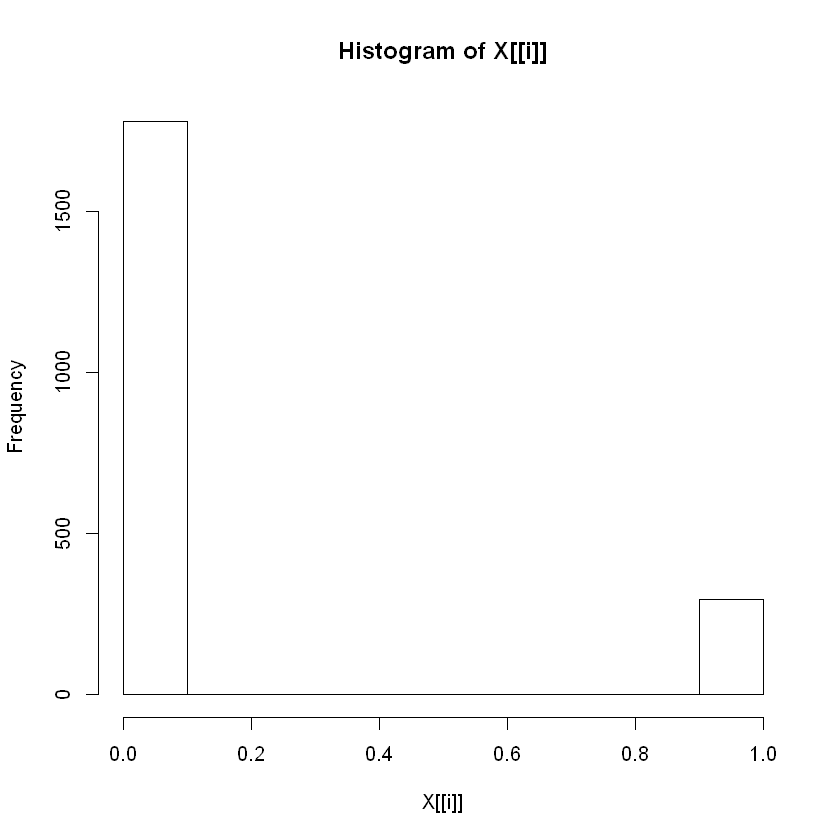

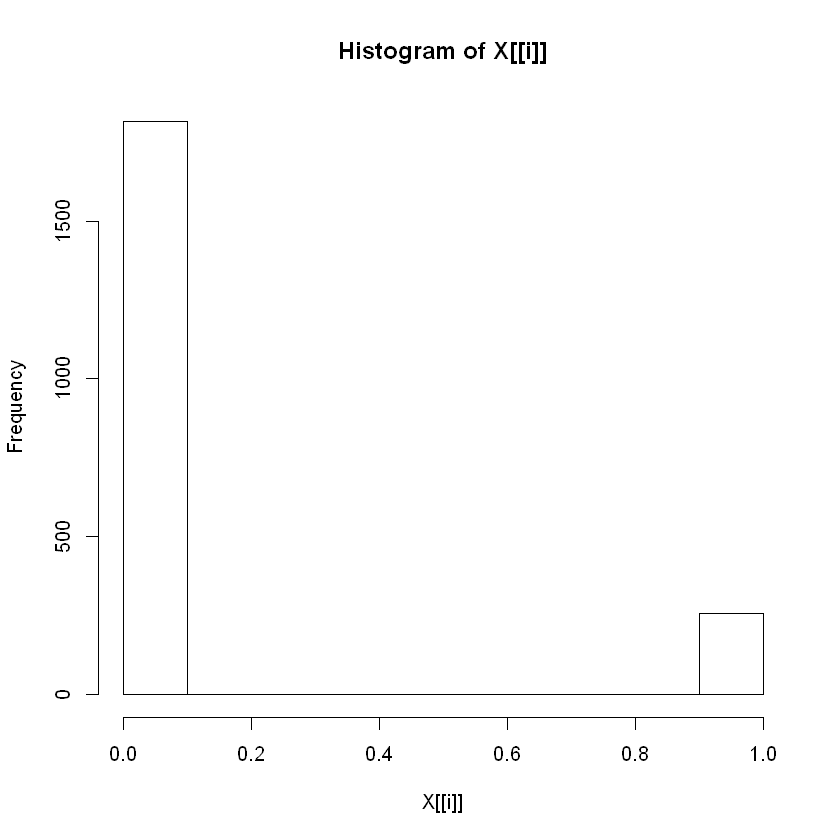

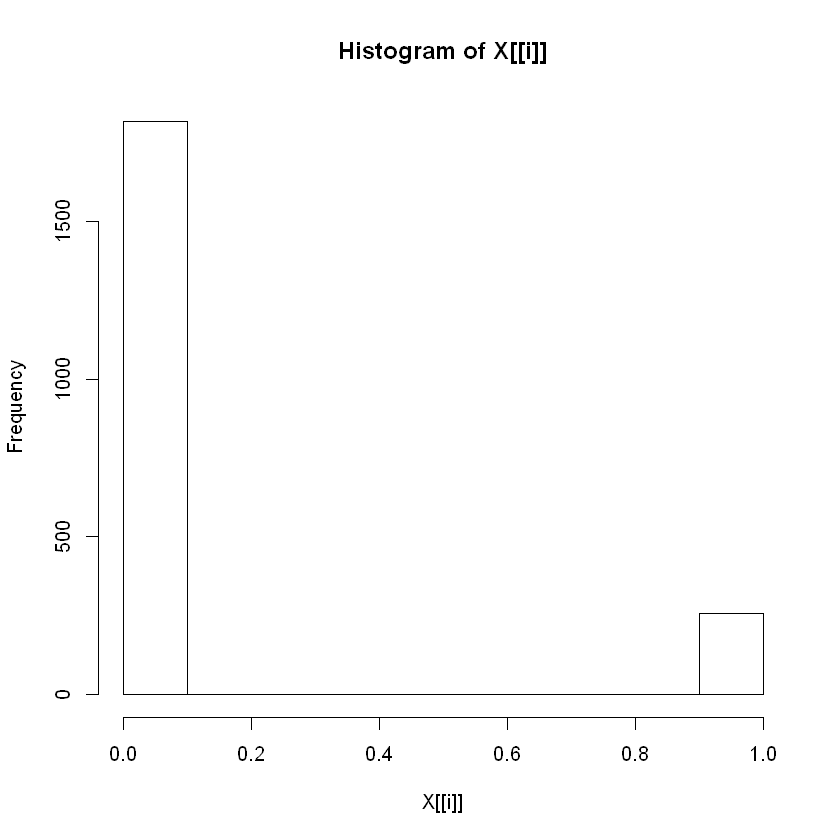

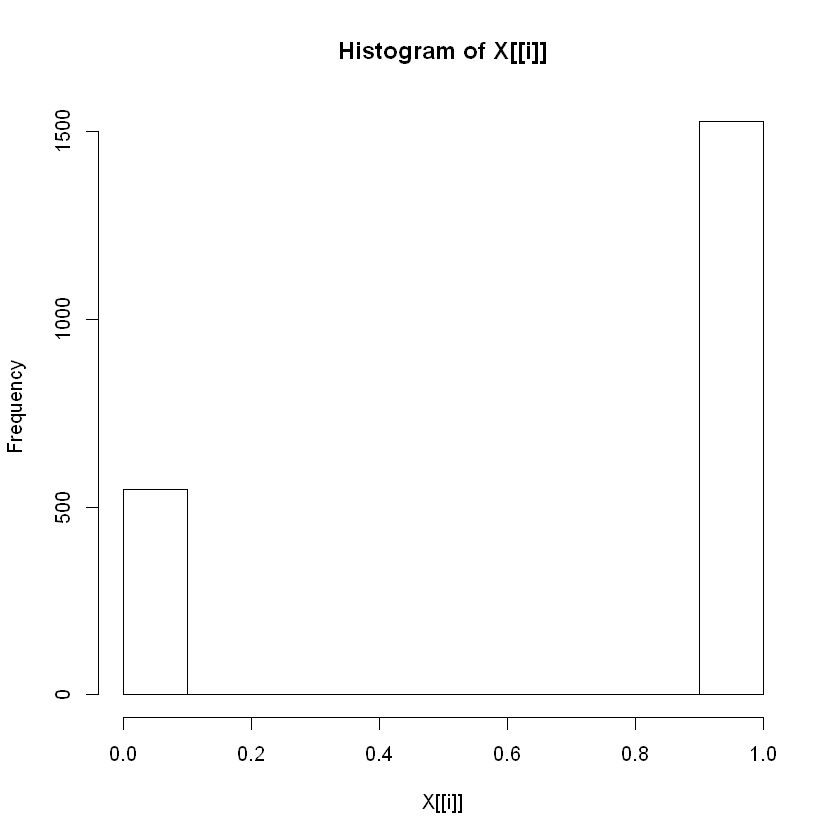

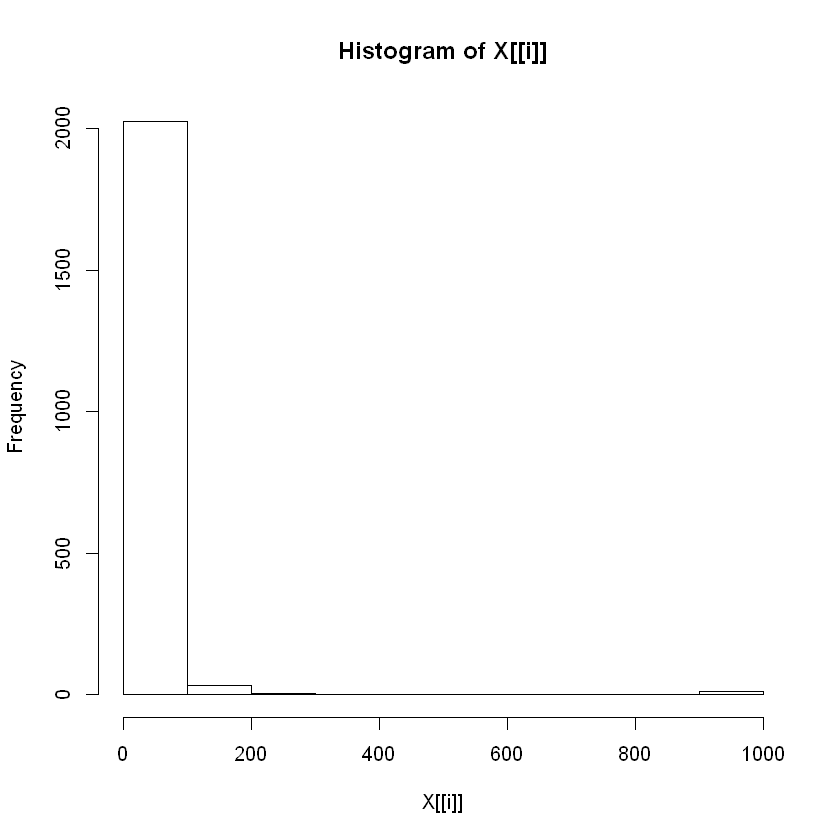

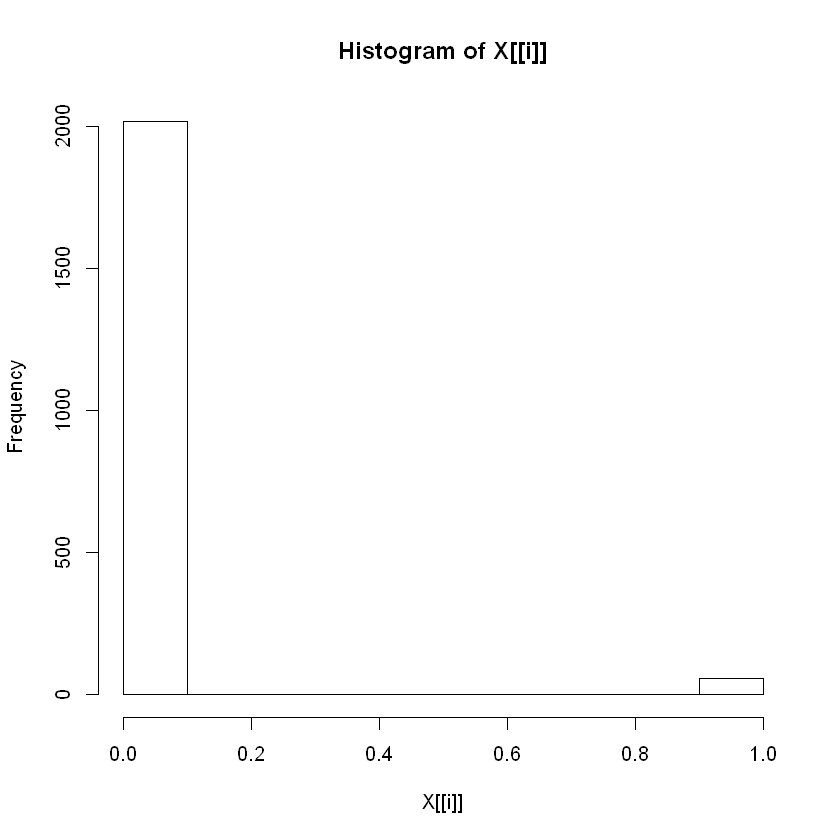

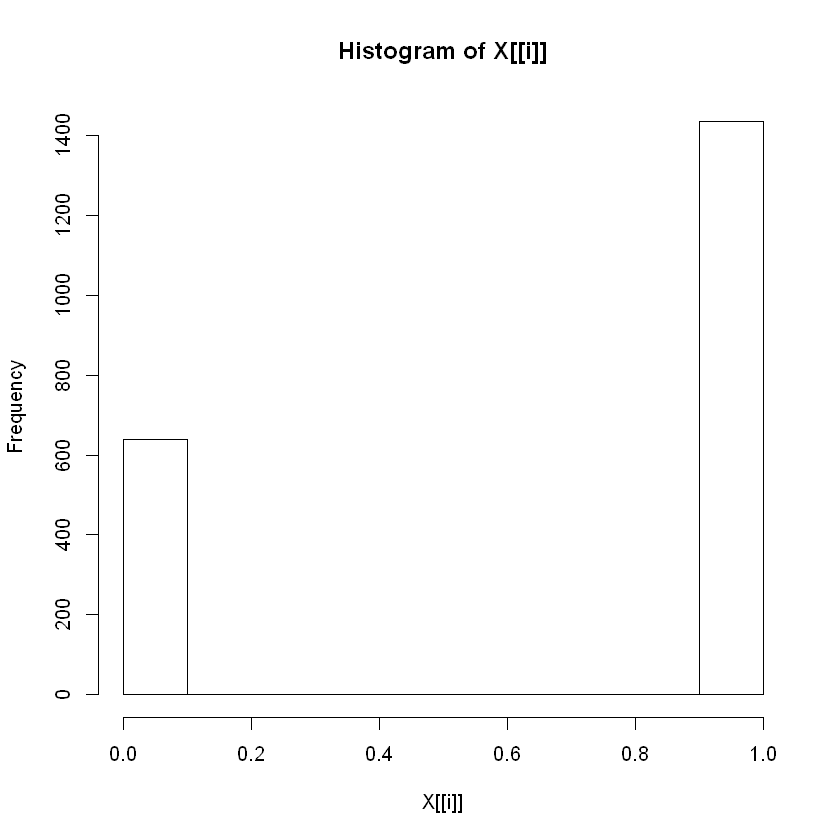

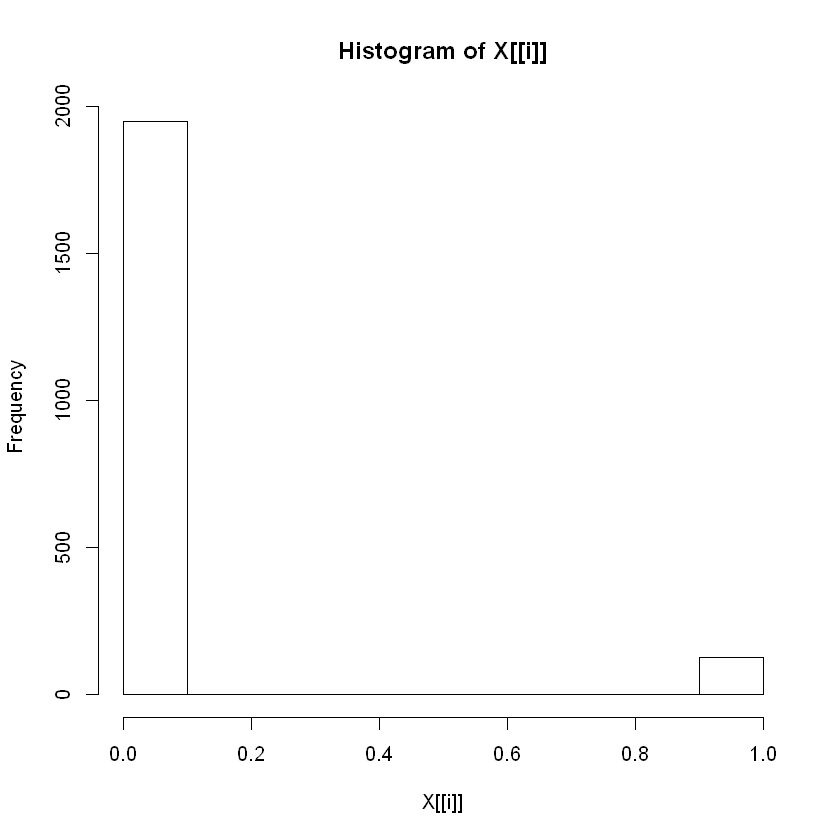

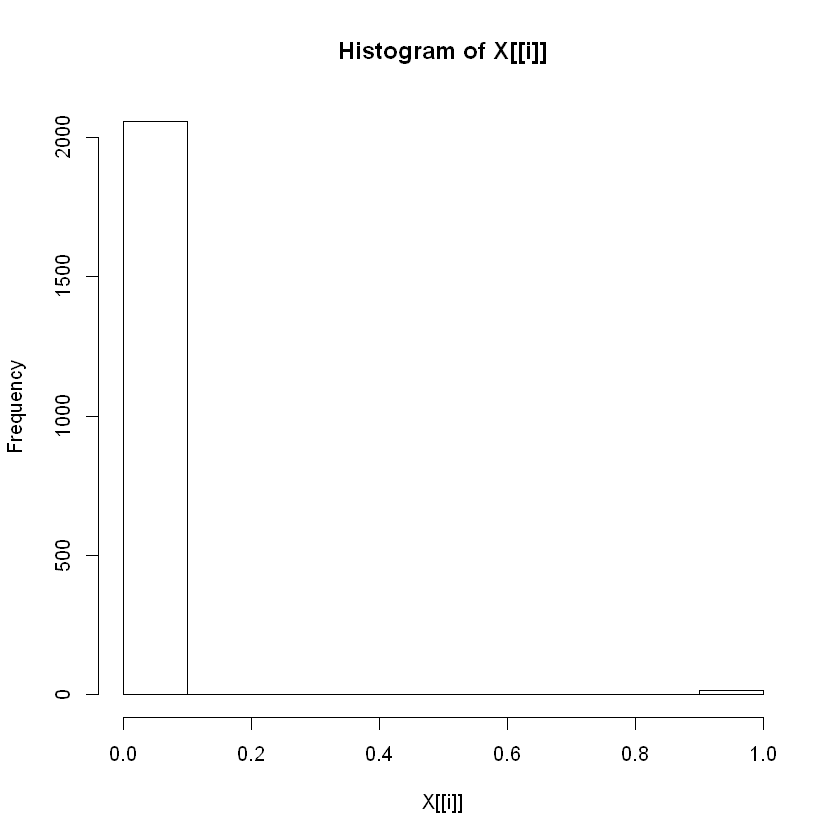

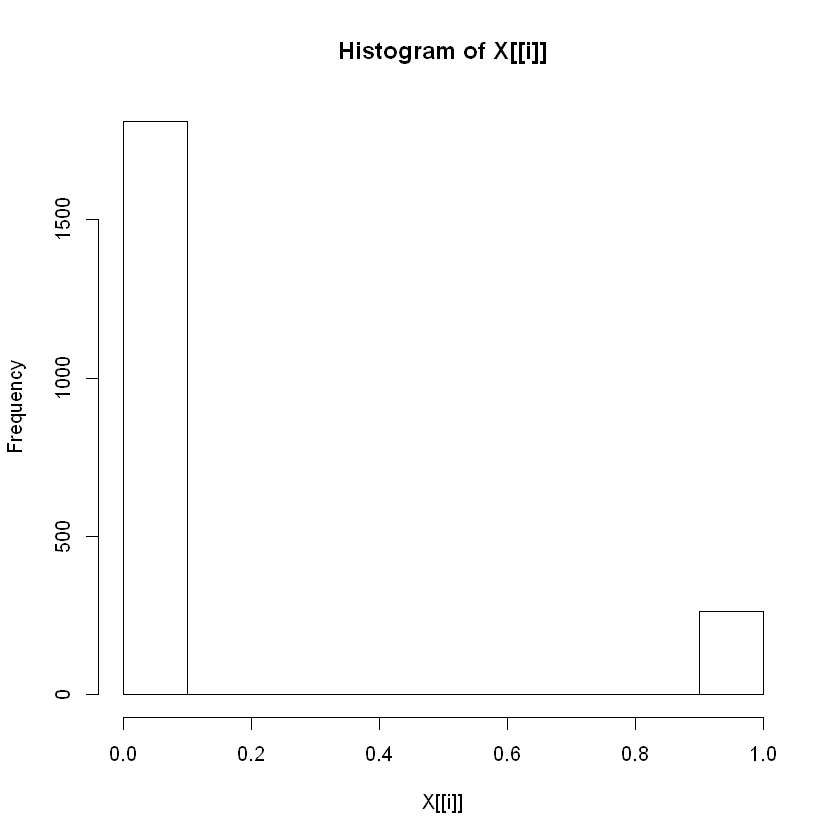

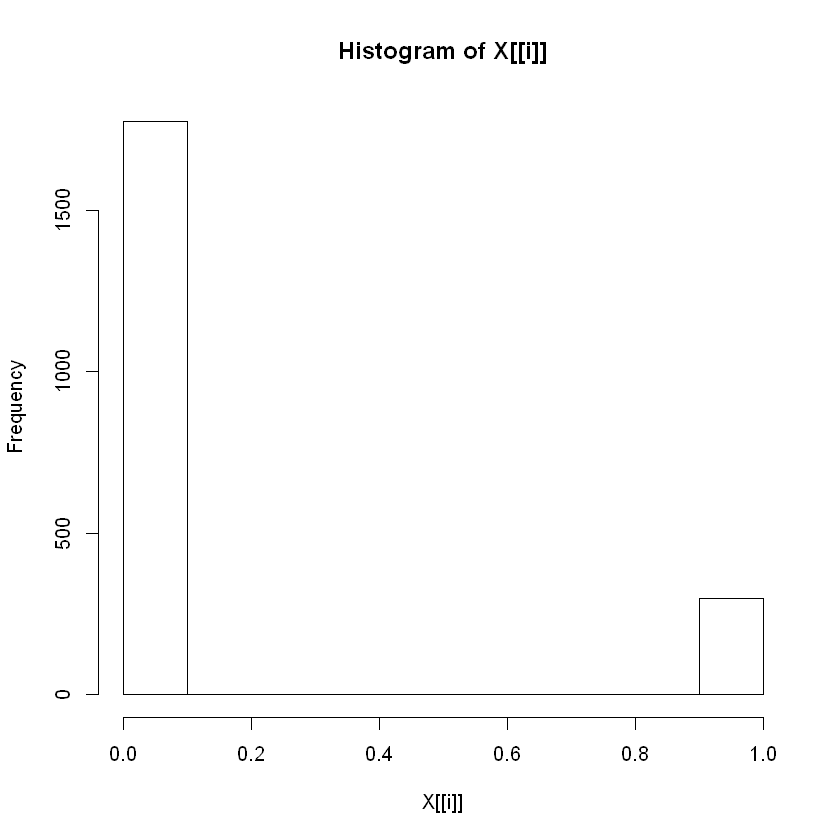

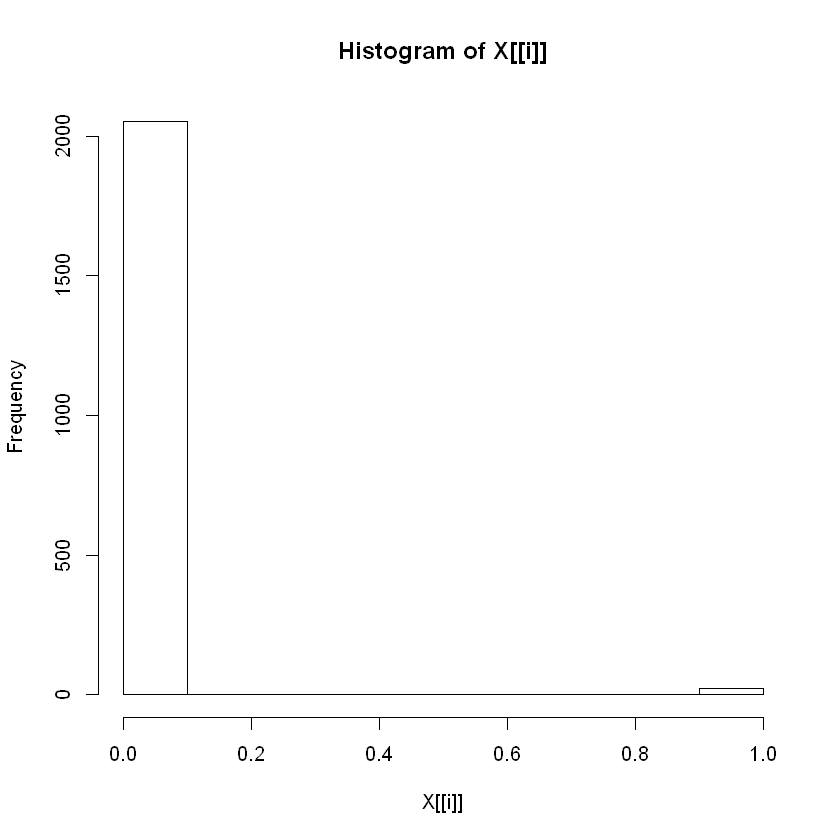

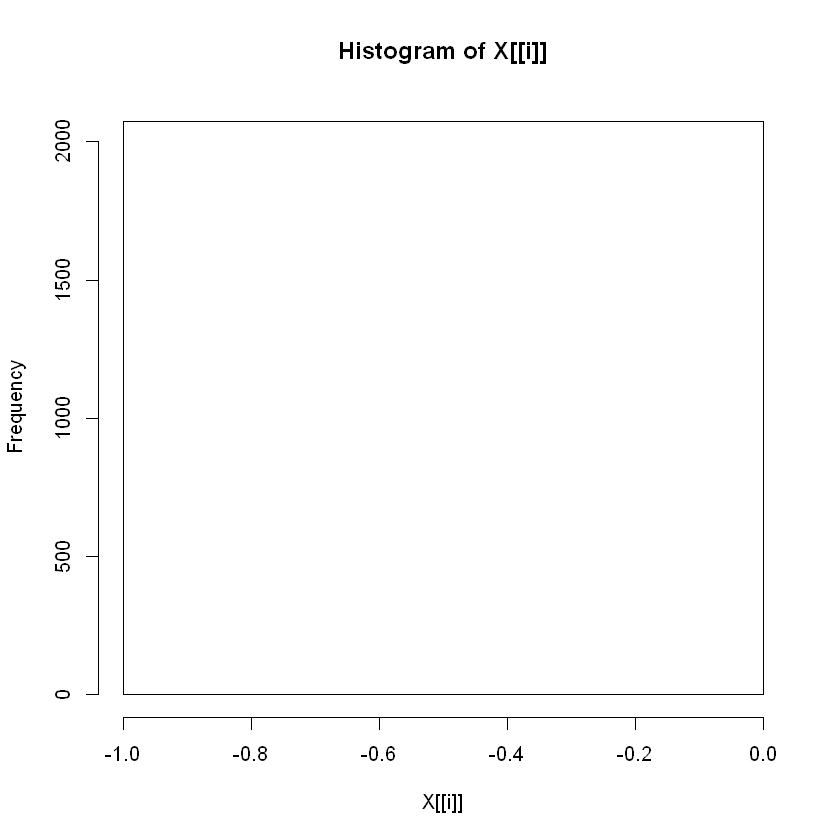

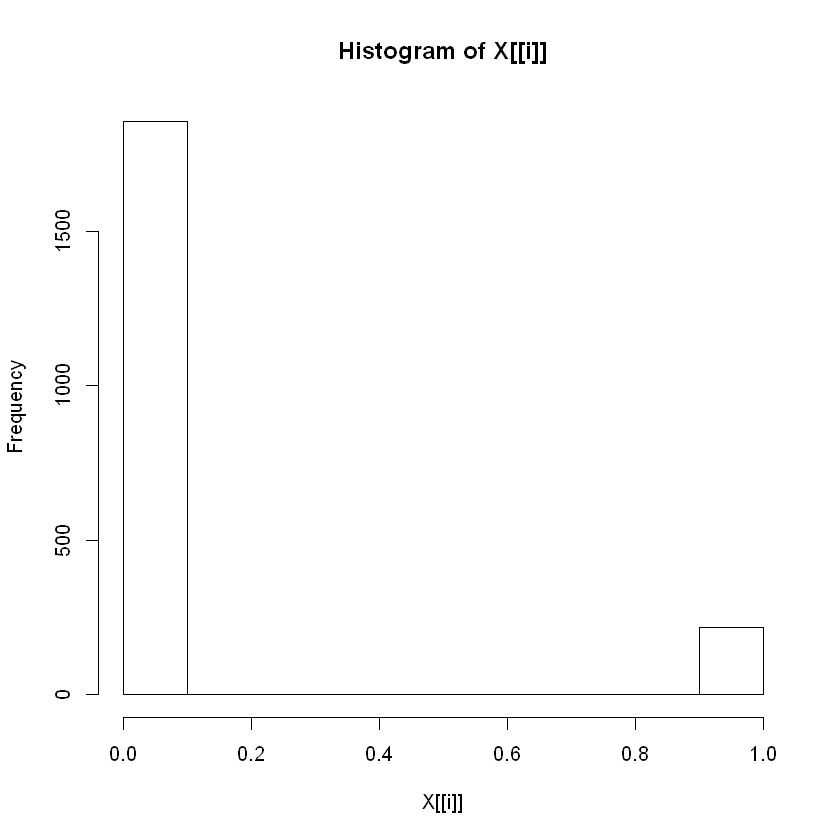

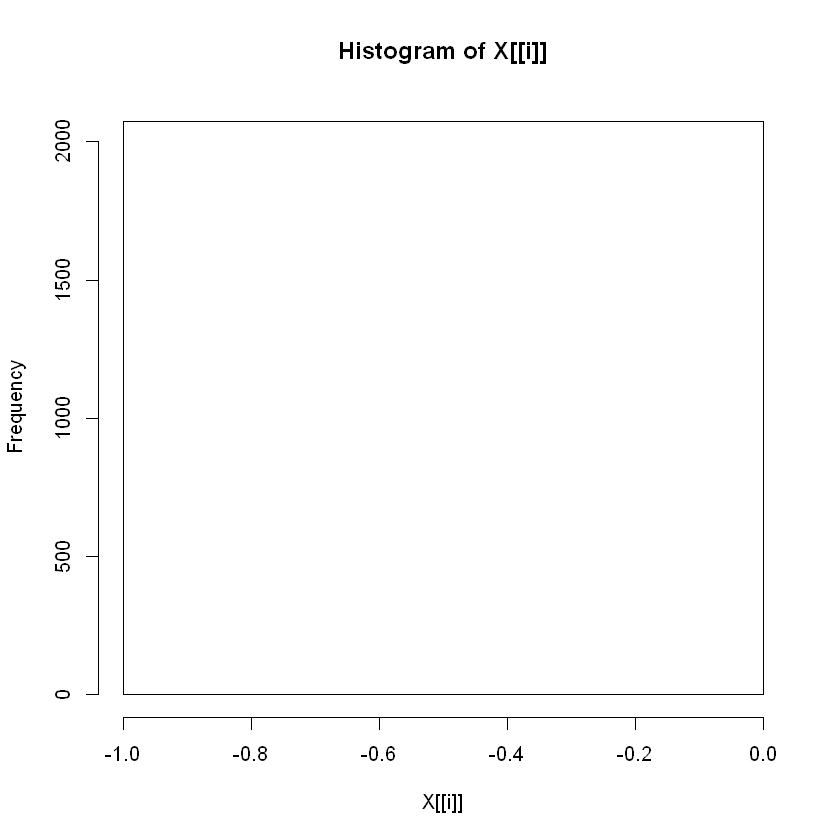

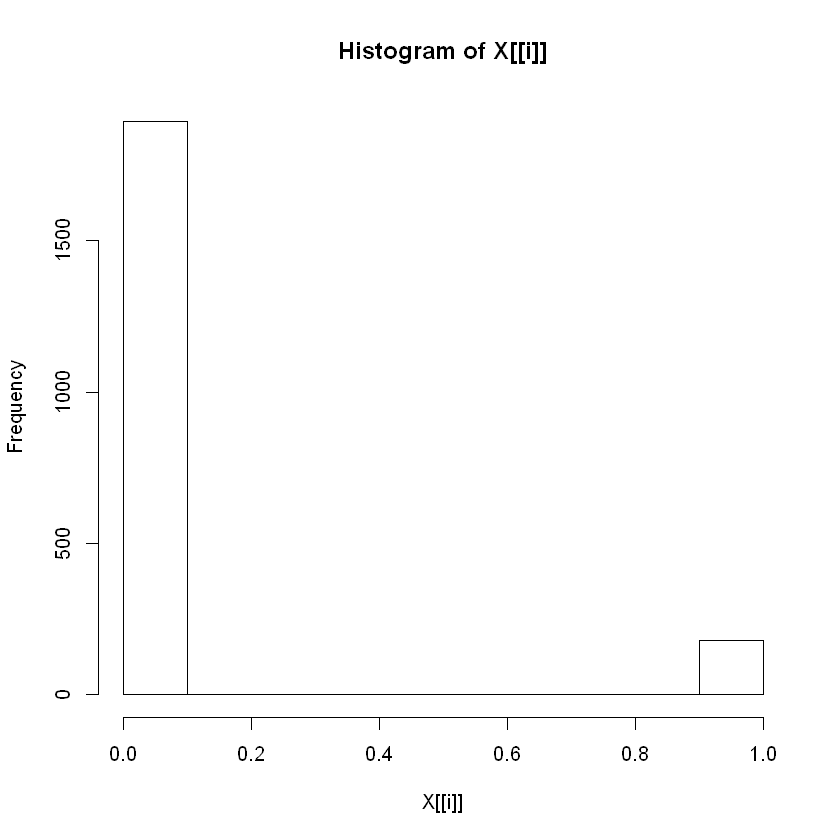

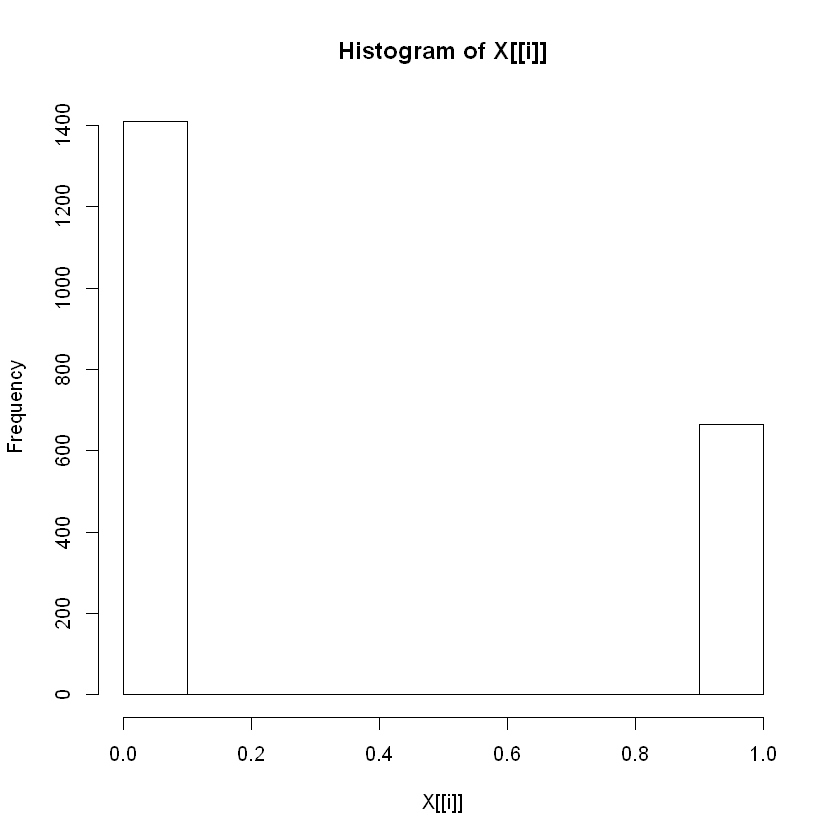

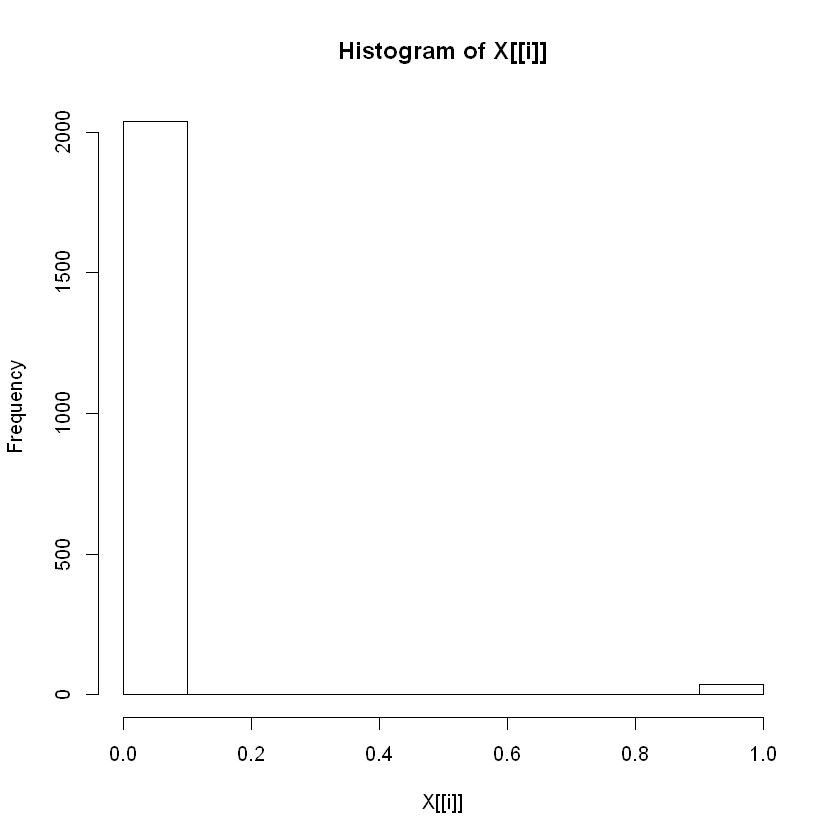

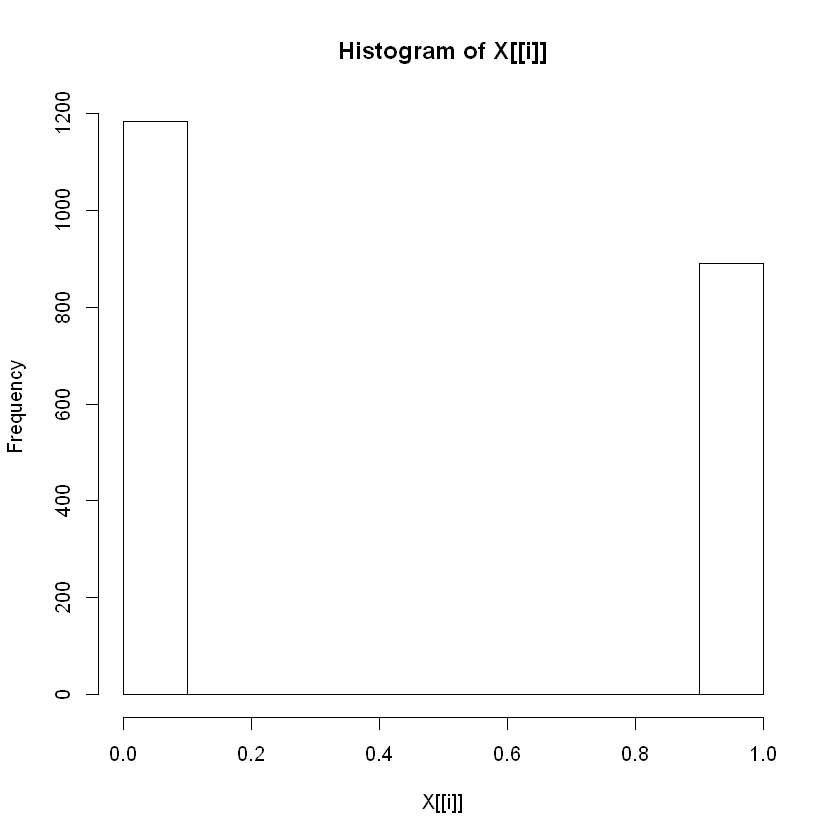

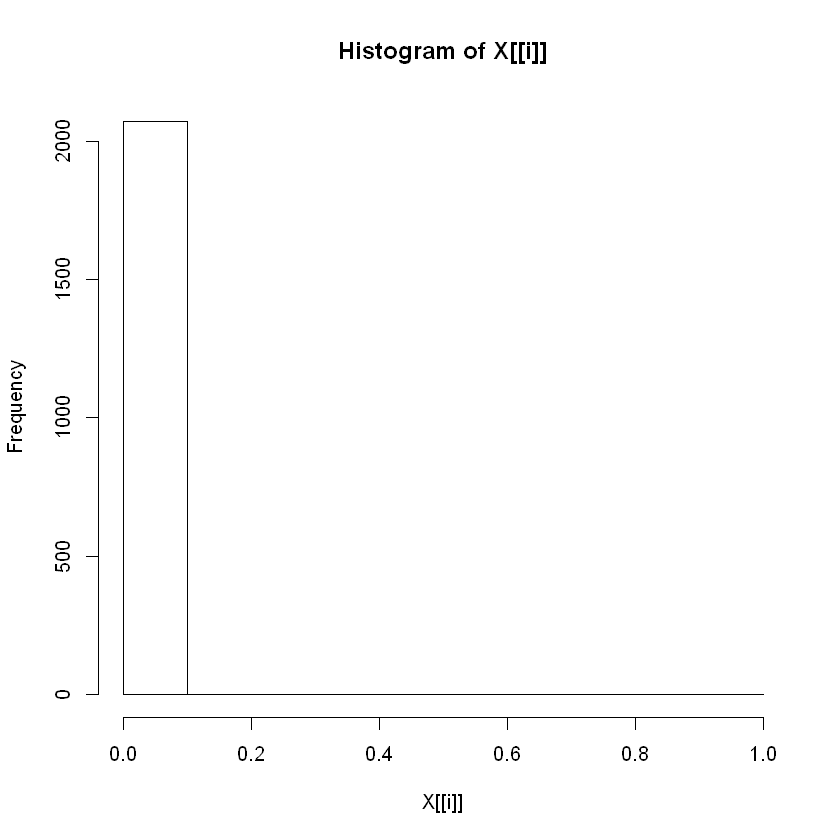

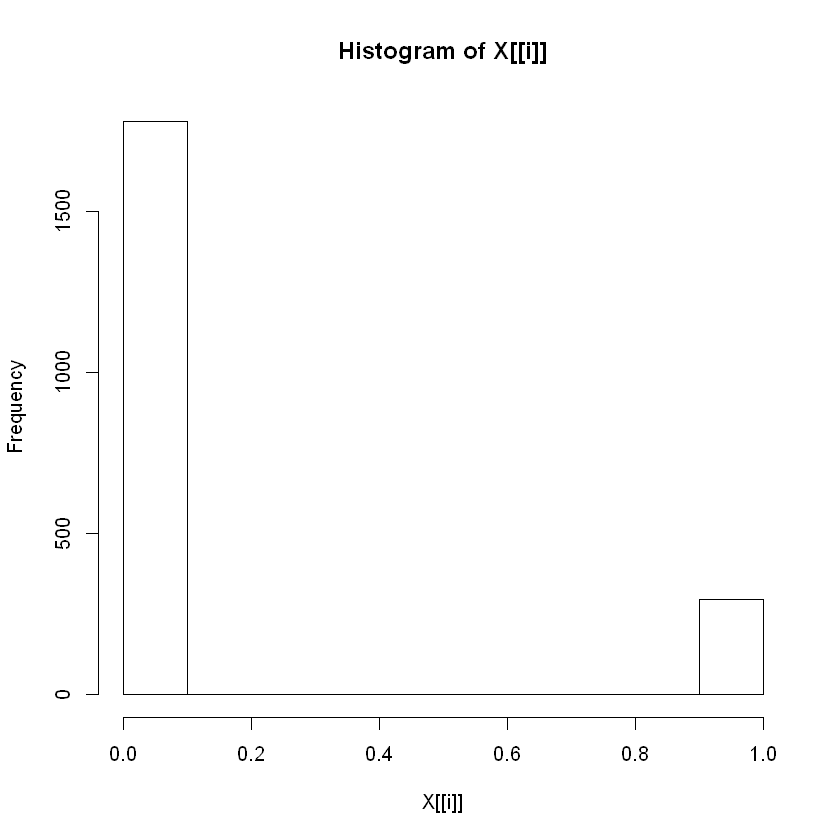

ERROR: Error in hist.default(X[[i]], ...): 'x' must be numeric


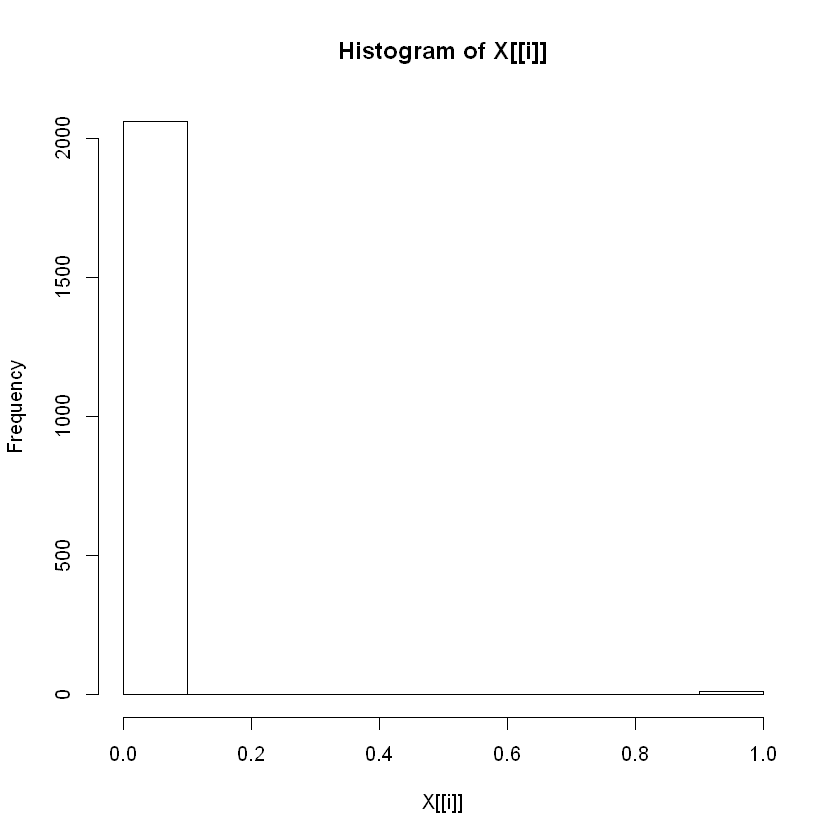

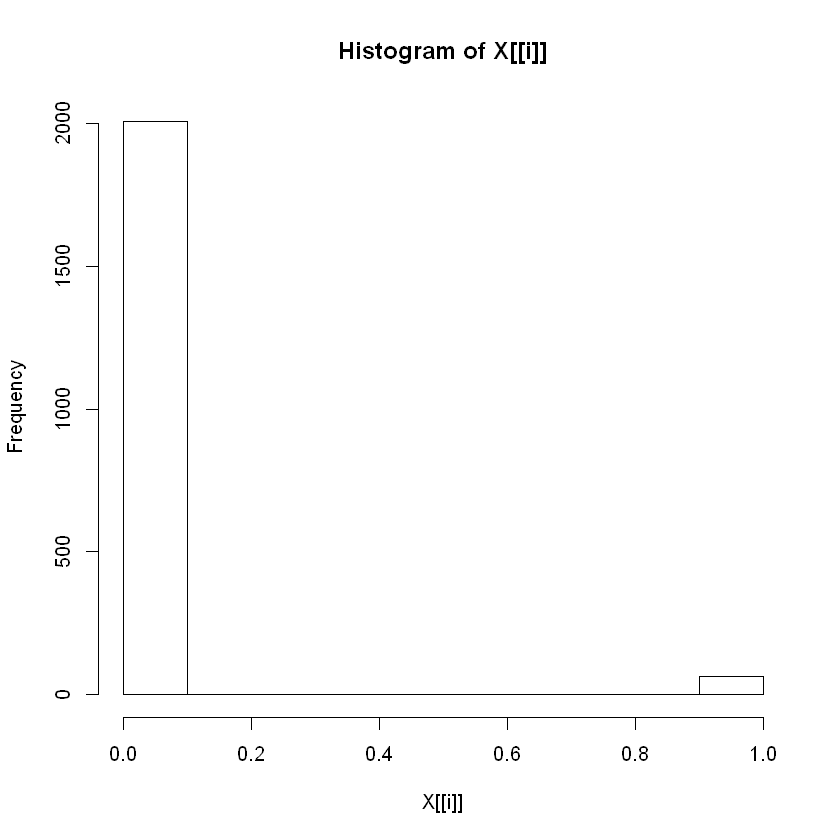

In [11]:
sapply(alldata, hist)

In [ ]:
sapply(alldata, str)

## Train-Test Split

In [12]:
set.seed(1)
trainIndex = createDataPartition(alldata$y, p = 0.7, list = FALSE)
traindata = alldata[trainIndex, ]
testdata = alldata[-trainIndex, ]

In [13]:
dim(traindata)
dim(testdata)


[1] 1453   61

[1] 621  61

In [14]:
head(traindata, 10)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,y
1,27,1,1,1,18,3,1,28,119.9,154.0,...,0,0,0,0,1,0,0,0,0,a
3,37,0,1,1,1,3,14,33,174.0,128.1,...,0,1,0,0,1,0,0,0,0,b
4,29,0,1,1,14,9,3,29,8.8,126.8,...,0,0,0,0,0,0,0,0,0,a
7,29,1,0,1,16,1,2,24,48.5,16.6,...,0,0,0,0,1,0,0,0,0,b
8,27,1,1,1,13,4,17,34,4.9,172.3,...,0,0,1,0,0,0,1,0,0,a
10,27,0,1,0,8,18,18,26,69.1,171.2,...,0,0,1,0,0,0,1,0,0,a
11,29,1,0,0,3,14,1,24,53.2,150.3,...,0,0,0,0,1,0,0,0,0,a
12,27,0,0,1,11,17,4,23,167.3,71.8,...,0,0,0,0,1,0,0,0,0,a
16,37,1,1,1,7,17,10,22,110.6,126.9,...,0,0,0,0,0,0,0,0,0,a
17,29,1,0,1,10,18,11,29,94.4,195.9,...,0,0,0,0,1,0,0,0,0,b


# INITIAL MODELS

## Lasso I - 0.8454

### Control Settings and Sampling

In [ ]:
fitControl <- trainControl(method = "repeatedcv", number = 10, verboseIter = TRUE, classProbs = TRUE, repeats = 5)

In [ ]:
tunegrid <- expand.grid(alpha = seq(0.01,1,by = 0.01),lambda = seq(0.001,0.01,by = 0.001))
Lasso <- train(y~., data=traindata7, method="glmnet", trControl = fitControl, tuneGrid = tunegrid)
predLasso <- predict(Lasso,traindata3[,-59],type = 'prob')  #testdata 

In [ ]:
predLasso$b

In [ ]:
rf.roc<-roc(traindata3$y,predLasso$b)
auc(rf.roc)

In [ ]:
plot(rf.roc)

In [ ]:
predtest <- predict(Lasso,submitdata,type = 'prob')  #testdata 
predtest$b

In [ ]:
predictions <- predtest$b

In [ ]:
send_submission(predictions, token, url=subm_url, submit_now= submit_now)

## 2. Random Forest I - 0.854

### RF1: 500 Tree (Default)

In [ ]:
tunegrid <- expand.grid(.mtry=c(3,5,10,15), .splitrule = "gini", .min.node.size = 5)

In [ ]:
set.seed(300)
RF <- train(y~., data=traindata7, method="ranger", trControl = fitControl, tuneGrid = tunegrid)

In [ ]:
RF

In [ ]:
predRF <- predict(RF, traindata3, type = 'prob')

In [ ]:
rf.roc<-roc(traindata3$y,predRF$b)
auc(rf.roc)

### RF2: 250 Tree

In [ ]:
tunegrid2 <- expand.grid(.mtry=c(3,5,10,15), .splitrule = "gini", .min.node.size = 5)

In [ ]:
set.seed(350)
RF2 <- train(y~., data=traindata7, method="ranger", trControl = fitControl, tuneGrid = tunegrid2,num.trees = 250)

In [ ]:
RF2

In [ ]:
predRF2 <- predict(RF2, testdata, type = 'prob')

In [ ]:
rf.roc<-roc(traindata3$y,predRF2$b)
auc(rf.roc)

### RF3: 350 Tree

In [ ]:
set.seed(450)
RF3 <- train(y~., data=traindata7, method="ranger", trControl = fitControl, tuneGrid = tunegrid2,num.trees = 350)

In [ ]:
RF3

In [ ]:
predRF3 <- predict(RF3, traindata3, type = 'prob')

In [ ]:
rf.roc<-roc(traindata3$y,predRF3$b)
auc(rf.roc)

### RF4

In [ ]:
set.seed(500)
RF4 <- train(y~., data=traindata, method="ranger", trControl = fitControl,
             tuneGrid = tunegrid2,num.trees = 250, importance = 'permutation')

In [ ]:
RF4

In [ ]:
predRF4 <- predict(RF4, testdata, type = 'prob')

In [ ]:
rf.roc<-roc(testdata$y,predRF4$b)
auc(rf.roc)

### RF 4: Variable Importance

In [ ]:
imptable = data.table(varImp(RF4)$importance)
imptable[,order := order(imptable)]
imptable[,variable := 1:dim(imptable)[1] ]
imptable = imptable[order(rank(order))]

In [ ]:
imptable

In [ ]:
plot(varImp(RF4))

In [ ]:
idx <- varImp(RF4)$importance >5
imptable <- as.data.table(varImp(RF4)$importance)
imptable[..idx,"Overall"]

In [ ]:
set.seed(750)
predtest4rf <- predict(RF4,submitdata,type = 'prob')  #testdata 
predtest4rf$b

In [ ]:
predictions <- predtest4rf$b
send_submission(predictions, token, url=subm_url, submit_now= submit_now)

## 3. Stochastic Gradient Boosting I

In [ ]:
tunegrid <-  expand.grid(interaction.depth = c(1, 5, 9),n.trees = (1:5)*50, shrinkage = c(0.05,0.01, 0.1),n.minobsinnode = 10)
SGB <- train(y~., data=traindata, method="gbm", trControl = fitControl, tuneGrid = tunegrid)
predSGB <- predict(SGB, submitdata, type='prob')

## 4. Model Tries

In [ ]:
sgb_grid = expand.grid(n.trees = c(50,150,250), shrinkage = c(0,0.05,0.1), interaction.depth = c(10, 20), n.minobsinnode = 10)

In [ ]:
dt_grid = expand.grid(cp = seq(0.01,0.1,0.01))

In [ ]:
dt_grid

In [ ]:
data1_dt = train(y ~ ., data = traindata, method = "rpart", trControl = fitControl)
data1_dt

In [ ]:
set.seed(1000)
DTree <- rpart(y~., data = traindata, method = "class", minbucket = 10, cp = 0.01)
DTree

In [ ]:
predDtree1 <- predict(DTree,testdata[,-59],type = 'prob')  #testdata 
predDtree1 = as.data.table(predDtree1)
predDtree1$b

In [ ]:
rf.roc<-roc(testdata$y,predDtree1$b)
auc(rf.roc)

In [ ]:
rpart.plot(DTree)
predDTree <- predict(DTree, testdata)

In [ ]:
set.seed(300)
RF6 <- train(y~., data=alldata, method="ranger", trControl = fitControl)

In [ ]:
RF6

In [ ]:
set.seed(750)
predtest3rf <- predict(RF6,submitdata,type='prob')  #testdata 
predtest3rf

In [ ]:
tunegrid7 <- expand.grid(.mtry=c(30), .splitrule = "gini", .min.node.size = 1)

In [ ]:
set.seed(750)
RF7 <- train(y~., data=alldata, method="ranger", trControl = fitControl, tuneGrid = tunegrid7)

In [ ]:
RF7

In [ ]:
predtest4rf <- predict(RF7,testdata,type='prob')  #testdata 
predtest4rf

## 5. Stochastic Gradient Boosting II - 0.8450068

In [ ]:
sgb_grid = expand.grid(n.trees = seq(10,100,10), shrinkage = c(0.01,0.05,0.1), 
                       interaction.depth = c(5,10, 20), n.minobsinnode = 10)

In [ ]:
data1_sgb = train(y ~ ., data = traindata, method = "gbm", trControl = fitControl, tuneGrid = sgb_grid)

In [ ]:
data1_sgb

In [ ]:
data1_sgb_predict <- predict(data1_sgb,submitdata,type='prob')
data1_sgb_predict$b

In [ ]:
predictions <- data1_sgb_predict$b

In [ ]:
send_submission(predictions, token, url=subm_url, submit_now= submit_now)

# DATA TRANSFORMATION

## Upsampling

In [ ]:
up_train <- upSample(x = traindata[, -ncol(traindata)],
                     y = as.factor(traindata$y))
head(up_train)

## Variable Importance Train

In [ ]:
fitControl <- trainControl(method = "repeatedcv", number = 10, verboseIter = TRUE, classProbs = TRUE)
tunegrid2 <- expand.grid(.mtry=c(3,5,10,15), .splitrule = "gini", .min.node.size = 5)
set.seed(500)
RF11 <- train(Class~., data=up_train, method="ranger",
              trControl = fitControl, tuneGrid = tunegrid2, importance = 'permutation')
RF11

In [ ]:
get_accuracy <- function(predicted, actual){
  confusion_table = table(predicted,actual)
  TP = confusion_table[2,2]
  TN = confusion_table[1,1]
  FN = confusion_table[1,2]
  FP = confusion_table[2,1]
  accuracy = ((FP/(sum(TN+FP))+FN/(sum(FN+TP)))*0.5)
  return(accuracy)
}

In [ ]:
predRF11 <- predict(RF11, testdata)

In [ ]:
1 - get_accuracy(predRF11, testdata$y )
curve <- roc(as.numeric(predRF11), as.numeric(testdata$y) )
auc(curve)

## Variable Importance All

In [ ]:
up_trainall <- upSample(x = alldata[, -ncol(alldata)],
                     y = as.factor(alldata$y))
head(up_trainall)

In [ ]:
RF11all <- train(Class~., data=up_trainall, method="ranger",
              trControl = fitControl, tuneGrid = tunegrid2, importance = 'permutation')
RF11all

In [ ]:
imptable = data.table(varImp(RF11all)$importance)
imptable[,variable := paste("x",1:dim(imptable)[1],sep="") ]
imptable <- imptable[order(Overall ,decreasing = TRUE),]

In [ ]:
imptable

In [ ]:
plot(varImp(RF11all))

## Variable Reduction

### Train

In [ ]:
fitControl <- trainControl(method = "repeatedcv", number = 10, repeats = 5, summaryFunction = twoClassSummary,
                           verboseIter = TRUE, classProbs = TRUE, sampling = "smote")
tunegrid2 <- expand.grid(.mtry=c(3,5,10,15), .splitrule = "gini", .min.node.size = 5)

In [ ]:
set.seed(121)
RF11 <- train(y~., data = traindata, method="ranger",
              trControl = fitControl, tuneGrid = tunegrid2, importance = 'impurity')
RF11

In [ ]:
predRF11 <- predict(RF11, traindata3 )

In [ ]:
1 - get_accuracy(predRF11, traindata3$y )
curve <- roc(as.numeric(predRF11), as.numeric(traindata3$y) )
auc(curve)

In [ ]:
imptable = data.table(varImp(RF11)$importance)
imptable[,variable := 1:dim(imptable)[1] ]
imptable <- imptable[order(Overall ,decreasing = TRUE),]

In [ ]:
tail(imptable,25)

In [ ]:
plot(varImp(RF11))

### Reduction 1: 0.869453

In [ ]:
removecols <- imptable[(nrow(imptable)-19):nrow(imptable),variable ];removecols

In [ ]:
reduceddata <- traindata[,-removecols]

In [ ]:
ncol(reduceddata)

In [ ]:
set.seed(153)
trainIndex = createDataPartition(reduceddata$y, p = 0.7, list = FALSE)
reducedtrain = reduceddata[trainIndex, ]
reducedtest = reduceddata[-trainIndex, ]

In [ ]:
set.seed(821)
RF11 <- train(y~., data = reducedtrain, method="ranger",  num.trees = 350, metric = "ROC", preProc=c("center", "scale"),
              trControl = fitControl, tuneGrid = tunegrid2, importance = 'permutation')
RF11

In [ ]:
predRF11 <- predict(RF11, reducedtest )

In [ ]:
1 - get_accuracy(predRF11, reducedtest$y )
curve <- roc(as.numeric(predRF11), as.numeric(reducedtest$y) )
auc(curve)

In [ ]:
predictions <- predict(RF11, submitdata,type = "prob" )$b; predictions

In [ ]:
send_submission(predictions, token, url=subm_url, submit_now= TRUE)

### Reduction 2

In [ ]:
fitControl <- trainControl(method = "repeatedcv", number = 10, repeats = 5, summaryFunction = twoClassSummary,
                           verboseIter = TRUE, classProbs = TRUE, sampling = "up")
tunegrid2 <- expand.grid(.mtry=c(3,5,10,15), .splitrule = "gini", .min.node.size = 5)

In [ ]:
removecols <- imptable[(nrow(imptable)-13):nrow(imptable),variable ];removecols

In [ ]:
reduceddata <- traindata[,-removecols]

In [ ]:
ncol(reduceddata)

In [ ]:
set.seed(153)
trainIndex = createDataPartition(reduceddata$y, p = 0.7, list = FALSE)
reducedtrain = reduceddata[trainIndex, ]
reducedtest = reduceddata[-trainIndex, ]

In [ ]:
set.seed(821)
RF12 <- train(y~., data = reduceddata, method="ranger",  num.trees = 350, metric = "ROC", preProc=c("range"),
              trControl = fitControl, tuneGrid = tunegrid2, importance = 'permutation')
RF12

In [ ]:
predRF12 <- predict(RF12, reducedtest )

In [ ]:
1 - get_accuracy(predRF12, reducedtest$y )
curve <- roc(as.numeric(predRF12), as.numeric(reducedtest$y) )
auc(curve)

In [ ]:
reduceddsubmit <- submitdata[,-removecols]
predictions <- predict(RF12, reduceddsubmit,type = "prob" )$b; predictions

In [ ]:
send_submission(predictions, token, url=subm_url, submit_now= TRUE)

In [ ]:
imptable = data.table(varImp(RF12)$importance)
imptable[,variable := 1:dim(imptable)[1] ]
imptable <- imptable[order(Overall ,decreasing = TRUE),]

In [ ]:
tail(imptable,25)

# DATA TRANSFORMATION 2

## Transformation 1

#### To Uniform

In [20]:
alllng <- dim(alldata[,-length(alldata)])
sbmlng <- dim(submitdata)

bigdata <- rbind(alldata[,-length(alldata)],submitdata)
bigscaled <- bigdata
dim(bigscaled)

[1] 4147   60

In [21]:
cols <- c(1,8,9,10,11,14,27,30,32)

In [22]:
for(c in cols){
    bigscaled[,c] <- to.uniform(bigscaled[,c])
}

In [23]:
head(bigscaled)

x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60
0.2823728,1,1,1,18,3,1,0.40414758,0.59175307,0.7598264,...,0,0,0,0,0,1,0,0,0,0
0.5408729,0,1,1,18,13,3,0.02218471,0.43163733,0.6520376,...,0,0,0,0,0,1,0,0,0,0
0.9404389,0,1,1,1,3,14,0.74704606,0.86279238,0.6279238,...,1,0,1,0,0,1,0,0,0,0
0.4574391,0,1,1,14,9,3,0.47070171,0.04244032,0.6233422,...,0,0,0,0,0,0,0,0,0,0
0.7716422,1,1,0,2,15,12,0.95249578,0.27803231,0.9438148,...,0,0,0,0,0,1,0,0,0,0
0.7716422,0,0,1,5,5,12,0.26814565,0.71256330,0.7451170,...,0,0,1,1,0,0,0,1,0,0


#### Column 36 & 42 to Dummy

In [24]:
bigscaled[bigscaled$x42 >= 1,'x42'] = 1
bigscaled[bigscaled$x36 >= 1,'x36'] = 1


#### As.Factor 

In [25]:
nonbinarycols <- cols

In [26]:
nonbinarycols

[1]  1  8  9 10 11 14 27 30 32

In [27]:
for(c in colnames(bigscaled[,-nonbinarycols])  ){
    bigscaled[,c] = as.factor(bigscaled[,c])
}

In [28]:
for(c in colnames(bigscaled[,c(5,6,7)])  ){
    bigscaled[,c] = as.factor(bigscaled[,c])
}

#### x5, x6, x7 Dummies  

In [29]:
dummied <- dummyVars(~x5+x6+x7,data = bigscaled)
bigscaled <- cbind(bigscaled, predict(dummied,bigscaled))
head(bigscaled)

x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x7.9,x7.10,x7.11,x7.12,x7.13,x7.14,x7.15,x7.16,x7.17,x7.18
0.2823728,1,1,1,18,3,1,0.40414758,0.59175307,0.7598264,...,0,0,0,0,0,0,0,0,0,0
0.5408729,0,1,1,18,13,3,0.02218471,0.43163733,0.6520376,...,0,0,0,0,0,0,0,0,0,0
0.9404389,0,1,1,1,3,14,0.74704606,0.86279238,0.6279238,...,0,0,0,0,0,1,0,0,0,0
0.4574391,0,1,1,14,9,3,0.47070171,0.04244032,0.6233422,...,0,0,0,0,0,0,0,0,0,0
0.7716422,1,1,0,2,15,12,0.95249578,0.27803231,0.9438148,...,0,0,0,1,0,0,0,0,0,0
0.7716422,0,0,1,5,5,12,0.26814565,0.71256330,0.7451170,...,0,0,0,1,0,0,0,0,0,0


In [30]:
bigscaled <- bigscaled[,-c(5,6,7)]

In [31]:
colnames(bigscaled)[57] #Must be x60

[1] "x60"

In [32]:
for(c in 58:length(bigscaled)  ){
    bigscaled[,c] = as.factor(bigscaled[,c])
}

#### New Datasets 

In [33]:
allproc <- cbind(bigscaled[1:alllng[1] ,],alldata$y)
submitproc <- bigscaled[ -(1:alllng[1]) ,]
dim(allproc); dim(submitproc)

[1] 2074  115

[1] 2073  114

In [35]:
head(allproc)

x1,x2,x3,x4,x8,x9,x10,x11,x12,x13,...,x7.10,x7.11,x7.12,x7.13,x7.14,x7.15,x7.16,x7.17,x7.18,alldata$y
0.2823728,1,1,1,0.40414758,0.59175307,0.7598264,0.6091150,1,0,...,0,0,0,0,0,0,0,0,0,a
0.5408729,0,1,1,0.02218471,0.43163733,0.6520376,0.6455269,0,0,...,0,0,0,0,0,0,0,0,0,a
0.9404389,0,1,1,0.74704606,0.86279238,0.6279238,0.5097661,0,0,...,0,0,0,0,1,0,0,0,0,b
0.4574391,0,1,1,0.47070171,0.04244032,0.6233422,0.2763443,1,0,...,0,0,0,0,0,0,0,0,0,a
0.7716422,1,1,0,0.95249578,0.27803231,0.9438148,0.7846636,1,0,...,0,0,1,0,0,0,0,0,0,a
0.7716422,0,0,1,0.26814565,0.71256330,0.7451170,0.2891247,0,0,...,0,0,1,0,0,0,0,0,0,b


In [34]:
head(submitproc)

,x1,x2,x3,x4,x8,x9,x10,x11,x12,x13,...,x7.9,x7.10,x7.11,x7.12,x7.13,x7.14,x7.15,x7.16,x7.17,x7.18
2075,0.1063419,1,1,1,0.05883771,0.3457921,0.009404389,0.03858211,0,0,...,0,0,0,0,0,0,0,1,0,0
2076,0.4574391,1,0,1,0.16180371,0.3277068,0.993006993,0.64962624,0,0,...,0,0,0,1,0,0,0,0,0,0
2077,0.8256571,1,1,1,0.40414758,0.4914396,0.060284543,0.49095732,0,0,...,0,1,0,0,0,0,0,0,0,0
2078,0.6255124,1,1,0,0.79551483,0.9713046,0.882324572,0.98625512,1,0,...,0,0,0,0,0,0,0,0,0,0
2079,0.3684591,1,1,1,0.47070171,0.9898722,0.884977092,0.87822522,0,0,...,0,0,0,0,0,0,0,0,0,0
2080,0.8256571,1,0,1,0.40414758,0.2794791,0.622136484,0.83120328,0,0,...,0,0,0,0,0,0,1,0,0,0


In [36]:
colnames(allproc)[ length(allproc)] <- "y"

#### Omitting x50 and x52

In [37]:
allproc <- allproc[,-c(47,49)]
submitproc <- submitproc[,-c(47,49)]

In [38]:
str(allproc)

'data.frame':	2074 obs. of  113 variables:
 $ x1   : num  0.282 0.541 0.94 0.457 0.772 ...
 $ x2   : Factor w/ 2 levels "0","1": 2 1 1 1 2 1 2 2 2 1 ...
 $ x3   : Factor w/ 2 levels "0","1": 2 2 2 2 2 1 1 2 2 2 ...
 $ x4   : Factor w/ 2 levels "0","1": 2 2 2 2 1 2 2 2 2 1 ...
 $ x8   : num  0.4041 0.0222 0.747 0.4707 0.9525 ...
 $ x9   : num  0.5918 0.4316 0.8628 0.0424 0.278 ...
 $ x10  : num  0.76 0.652 0.628 0.623 0.944 ...
 $ x11  : num  0.609 0.646 0.51 0.276 0.785 ...
 $ x12  : Factor w/ 2 levels "0","1": 2 1 1 2 2 1 1 1 1 2 ...
 $ x13  : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ x14  : num  0.7 0.155 0.784 0.237 0.7 ...
 $ x15  : Factor w/ 2 levels "0","1": 2 2 2 2 1 2 1 2 2 2 ...
 $ x16  : Factor w/ 2 levels "0","1": 1 1 1 2 1 1 1 1 2 1 ...
 $ x17  : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ x18  : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ x19  : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ x20  : Factor w/ 2 levels "0","1": 1 1 

#### Train-Test Split

In [42]:
set.seed(1)
trainIndex = createDataPartition(allproc$y, p = 0.7, list = FALSE)
trainproc = allproc[trainIndex, ]
testproc = allproc[-trainIndex, ]

## Variable Importance 

### Tuning 

In [40]:
fitControl <- trainControl(method = "repeatedcv", number = 10, repeats = 3, summaryFunction = twoClassSummary,
                           verboseIter = TRUE, classProbs = TRUE, sampling = "up")
tunegrid <- expand.grid(.mtry=c(3,5,10,15), .splitrule = "gini", .min.node.size = c(3,5,7,10))

### Model 

In [41]:
set.seed(821)
RFproc <- train(y~., data = allproc, method="ranger",  num.trees = 250, metric = "ROC",
              trControl = fitControl, tuneGrid = tunegrid, importance = 'permutation')
RFproc

+ Fold01.Rep1: mtry= 3, splitrule=gini, min.node.size= 3 
- Fold01.Rep1: mtry= 3, splitrule=gini, min.node.size= 3 
+ Fold01.Rep1: mtry= 5, splitrule=gini, min.node.size= 3 
- Fold01.Rep1: mtry= 5, splitrule=gini, min.node.size= 3 
+ Fold01.Rep1: mtry=10, splitrule=gini, min.node.size= 3 
- Fold01.Rep1: mtry=10, splitrule=gini, min.node.size= 3 
+ Fold01.Rep1: mtry=15, splitrule=gini, min.node.size= 3 
- Fold01.Rep1: mtry=15, splitrule=gini, min.node.size= 3 
+ Fold01.Rep1: mtry= 3, splitrule=gini, min.node.size= 5 
- Fold01.Rep1: mtry= 3, splitrule=gini, min.node.size= 5 
+ Fold01.Rep1: mtry= 5, splitrule=gini, min.node.size= 5 
- Fold01.Rep1: mtry= 5, splitrule=gini, min.node.size= 5 
+ Fold01.Rep1: mtry=10, splitrule=gini, min.node.size= 5 
- Fold01.Rep1: mtry=10, splitrule=gini, min.node.size= 5 
+ Fold01.Rep1: mtry=15, splitrule=gini, min.node.size= 5 
- Fold01.Rep1: mtry=15, splitrule=gini, min.node.size= 5 
+ Fold01.Rep1: mtry= 3, splitrule=gini, min.node.size= 7 
- Fold01.Rep1:

Selecting tuning parameters
Fitting mtry = 10, splitrule = gini, min.node.size = 10 on full training set


Random Forest 

2074 samples
 112 predictor
   2 classes: 'a', 'b' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 1867, 1867, 1867, 1866, 1868, 1866, ... 
Addtional sampling using up-sampling

Resampling results across tuning parameters:

  mtry  min.node.size  ROC        Sens       Spec     
   3     3             0.8635158  0.8247087  0.6783922
   3     5             0.8634088  0.8259894  0.6948105
   3     7             0.8631023  0.8202393  0.6889020
   3    10             0.8651385  0.8208680  0.7078954
   5     3             0.8678505  0.8726237  0.6260131
   5     5             0.8669967  0.8709293  0.6273595
   5     7             0.8680068  0.8677405  0.6404575
   5    10             0.8674268  0.8630519  0.6483007
  10     3             0.8699052  0.8834885  0.6077124
  10     5             0.8698244  0.8796627  0.6103137
  10     7             0.8695362  0.8777397  0.6260000
  10    10             0.8702080  0.8741140  0

In [45]:
predictions <- predict(RFproc$finalModel, allproc$y,type = "prob" )$b
Perf(predictions,allproc$y)

ERROR: Error in predict.ranger.forest(forest, data, predict.all, num.trees, type, : Error: Invalid value for 'type'. Use 'response', 'se', 'terminalNodes', or 'quantiles'.


### Variable Importances 

In [46]:
imptable = data.table(varImp(RFproc)$importance)
imptable[,variable := 1:dim(imptable)[1] ]
imptable <- imptable[order(Overall ,decreasing = TRUE),]

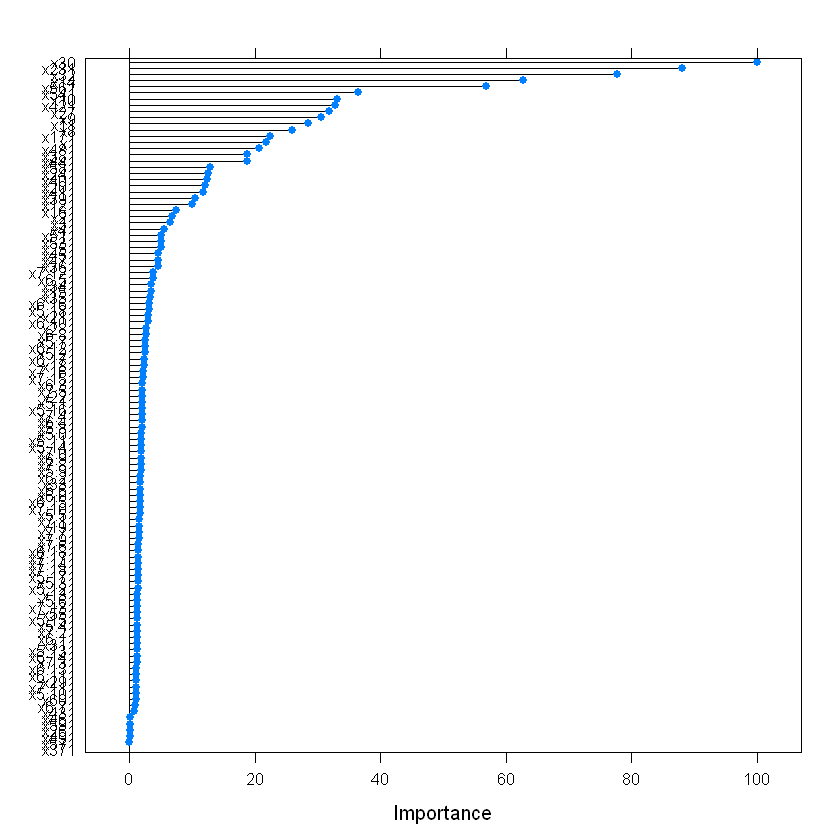

In [47]:
plot(varImp(RFproc))

In [48]:
library(feather)
path <- "importances"
write_feather(imptable, path)
imptable <- read_feather(path)

# REDUCED MODELS

## Loading Importances 

In [62]:
path <- "importances"
imptable <- as.data.table(read_feather(path))

## Random Forest 

### 21 Columns

#### Reduction 

In [63]:
head(imptable,21)

Overall,variable
100.00000,27
88.02475,20
77.67340,29
62.82354,11
56.84680,51
36.42268,49
33.17406,7
32.71577,39
31.89614,24
30.49971,6


In [64]:
cols <- c(imptable[c(1:21), variable ] ,113);cols

[1]  27  20  29  11  51  49   7  39  24   6   8   5  14   1  45  35  41  53  21
[20]  37  17 113

In [97]:
trainprocred <- trainproc[,cols]
testprocred <- testproc[,cols]

#### Tuning Settings

In [353]:
fitControl <- trainControl(method = "repeatedcv", number = 10, repeats = 3,
                           summaryFunction = twoClassSummary  ,
                           verboseIter = TRUE, classProbs = TRUE, sampling = "up")
tunegrid <- expand.grid(.mtry=c(3,5,10,15), .splitrule = "gini", .min.node.size = c(3,5,7,10))

#### Training Model 

In [107]:
set.seed(13)
RFprocred <- train(y~., data = trainprocred, method="ranger",  num.trees = 350, metric = "Spec" ,
              trControl = fitControl, tuneGrid = tunegrid, importance = 'permutation')
RFprocred

+ Fold01.Rep1: mtry= 3, splitrule=gini, min.node.size= 3 
- Fold01.Rep1: mtry= 3, splitrule=gini, min.node.size= 3 
+ Fold01.Rep1: mtry= 5, splitrule=gini, min.node.size= 3 
- Fold01.Rep1: mtry= 5, splitrule=gini, min.node.size= 3 
+ Fold01.Rep1: mtry=10, splitrule=gini, min.node.size= 3 
- Fold01.Rep1: mtry=10, splitrule=gini, min.node.size= 3 
+ Fold01.Rep1: mtry=15, splitrule=gini, min.node.size= 3 
- Fold01.Rep1: mtry=15, splitrule=gini, min.node.size= 3 
+ Fold01.Rep1: mtry= 3, splitrule=gini, min.node.size= 5 
- Fold01.Rep1: mtry= 3, splitrule=gini, min.node.size= 5 
+ Fold01.Rep1: mtry= 5, splitrule=gini, min.node.size= 5 
- Fold01.Rep1: mtry= 5, splitrule=gini, min.node.size= 5 
+ Fold01.Rep1: mtry=10, splitrule=gini, min.node.size= 5 
- Fold01.Rep1: mtry=10, splitrule=gini, min.node.size= 5 
+ Fold01.Rep1: mtry=15, splitrule=gini, min.node.size= 5 
- Fold01.Rep1: mtry=15, splitrule=gini, min.node.size= 5 
+ Fold01.Rep1: mtry= 3, splitrule=gini, min.node.size= 7 
- Fold01.Rep1:

Selecting tuning parameters
Fitting mtry = 3, splitrule = gini, min.node.size = 10 on full training set


Random Forest 

1453 samples
  21 predictor
   2 classes: 'a', 'b' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 1308, 1308, 1308, 1307, 1308, 1309, ... 
Addtional sampling using up-sampling

Resampling results across tuning parameters:

  mtry  min.node.size  ROC        Sens       Spec     
   3     3             0.8713576  0.8622408  0.6565344
   3     5             0.8715966  0.8607367  0.6556614
   3     7             0.8720183  0.8622463  0.6566138
   3    10             0.8728295  0.8546455  0.6752381
   5     3             0.8693606  0.8896275  0.6174074
   5     5             0.8673401  0.8862941  0.6091534
   5     7             0.8690208  0.8847762  0.6304762
   5    10             0.8695008  0.8835557  0.6276720
  10     3             0.8591330  0.8890325  0.6052910
  10     5             0.8614153  0.8905477  0.6062169
  10     7             0.8586530  0.8850542  0.6089683
  10    10             0.8608533  0.8805088  0

#### Testing Model 

In [347]:
predRFprocred <- predict(RFprocred, testprocred) # ,type = 'prob') #testdata 
Performance(predRFprocred, testprocred$y, prnt =1)

Setting levels: control = 1, case = 2
Setting direction: controls < cases


[1] "BA: "
[1] 0.7778027
Area under the curve: 0.7371


[1] 0.7574484

#### Full Train 

In [354]:
allprocred = rbind(trainprocred, testprocred); dim(allprocred)

[1] 2074   22

In [355]:
set.seed(13)
RFprocredsubmit <- train(y~., data = allprocred, method="ranger",  num.trees = 350, metric = "Spec" ,
              trControl = fitControl, tuneGrid = tunegrid, importance = 'permutation')
RFprocredsubmit

+ Fold01.Rep1: mtry= 3, splitrule=gini, min.node.size= 3 
- Fold01.Rep1: mtry= 3, splitrule=gini, min.node.size= 3 
+ Fold01.Rep1: mtry= 5, splitrule=gini, min.node.size= 3 
- Fold01.Rep1: mtry= 5, splitrule=gini, min.node.size= 3 
+ Fold01.Rep1: mtry=10, splitrule=gini, min.node.size= 3 
- Fold01.Rep1: mtry=10, splitrule=gini, min.node.size= 3 
+ Fold01.Rep1: mtry=15, splitrule=gini, min.node.size= 3 
- Fold01.Rep1: mtry=15, splitrule=gini, min.node.size= 3 
+ Fold01.Rep1: mtry= 3, splitrule=gini, min.node.size= 5 
- Fold01.Rep1: mtry= 3, splitrule=gini, min.node.size= 5 
+ Fold01.Rep1: mtry= 5, splitrule=gini, min.node.size= 5 
- Fold01.Rep1: mtry= 5, splitrule=gini, min.node.size= 5 
+ Fold01.Rep1: mtry=10, splitrule=gini, min.node.size= 5 
- Fold01.Rep1: mtry=10, splitrule=gini, min.node.size= 5 
+ Fold01.Rep1: mtry=15, splitrule=gini, min.node.size= 5 
- Fold01.Rep1: mtry=15, splitrule=gini, min.node.size= 5 
+ Fold01.Rep1: mtry= 3, splitrule=gini, min.node.size= 7 
- Fold01.Rep1:

Selecting tuning parameters
Fitting mtry = 3, splitrule = gini, min.node.size = 10 on full training set


Random Forest 

2074 samples
  21 predictor
   2 classes: 'a', 'b' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 1867, 1867, 1867, 1866, 1866, 1867, ... 
Addtional sampling using up-sampling

Resampling results across tuning parameters:

  mtry  min.node.size  ROC        Sens       Spec     
   3     3             0.8754343  0.8551541  0.6838693
   3     5             0.8759443  0.8534610  0.6890588
   3     7             0.8757894  0.8506859  0.6818301
   3    10             0.8751695  0.8442934  0.7067582
   5     3             0.8731102  0.8866923  0.6235163
   5     5             0.8728399  0.8834939  0.6346928
   5     7             0.8729008  0.8800847  0.6326928
   5    10             0.8731339  0.8743304  0.6503660
  10     3             0.8643914  0.8828624  0.6189673
  10     5             0.8635616  0.8811489  0.6255294
  10     7             0.8656534  0.8788067  0.6287843
  10    10             0.8635381  0.8717894  0

In [356]:
predRFprocredsubmit <- predict(RFprocredsubmit, submitdata  ,type = 'prob') #submitdata 

Warning message in model.frame.default(Terms, newdata, na.action = na.action, xlev = object$xlevels):
"variable 'x23' is not a factor"Warning message in model.frame.default(Terms, newdata, na.action = na.action, xlev = object$xlevels):
"variable 'x56' is not a factor"Warning message in model.frame.default(Terms, newdata, na.action = na.action, xlev = object$xlevels):
"variable 'x54' is not a factor"Warning message in model.frame.default(Terms, newdata, na.action = na.action, xlev = object$xlevels):
"variable 'x42' is not a factor"Warning message in model.frame.default(Terms, newdata, na.action = na.action, xlev = object$xlevels):
"variable 'x17' is not a factor"Warning message in model.frame.default(Terms, newdata, na.action = na.action, xlev = object$xlevels):
"variable 'x48' is not a factor"Warning message in model.frame.default(Terms, newdata, na.action = na.action, xlev = object$xlevels):
"variable 'x38' is not a factor"Warning message in model.frame.default(Terms, newdata, na.acti

ERROR: Error: variables 'x23', 'x56', 'x54', 'x42', 'x17', 'x48', 'x38', 'x44', 'x58', 'x24', 'x40', 'x20' were specified with different types from the fit


In [350]:
head(predRFprocred)

a,b
0.7927242,0.207275846
0.7281707,0.271829334
0.9969855,0.003014460
0.9062309,0.093769064
0.9597721,0.040227871
0.4002574,0.599742587
0.9908083,0.009191687
0.6064483,0.393551669
0.9742178,0.025782239
0.2745606,0.725439423


### 31 Columns 

#### Reduction 

In [118]:
head(imptable,31)

Overall,variable
100.000000,27
88.024747,20
77.673402,29
62.823540,11
56.846800,51
36.422683,49
33.174063,7
32.715768,39
31.896137,24
30.499714,6


In [119]:
cols <- c(imptable[c(1:31), variable ] ,113);cols

[1]  27  20  29  11  51  49   7  39  24   6   8   5  14   1  45  35  41  53  21
[20]  37  17  38  36   9  13   2   3   4  47  48  22 113

In [345]:
colnames(allproc[,head(imptable,31)$variable ])

[1] "x30" "x23" "x32" "x14" "x56" "x54" "x10" "x42" "x27" "x9"  "x11" "x8" 
[13] "x17" "x1"  "x48" "x38" "x44" "x58" "x24" "x40" "x20" "x41" "x39" "x12"
[25] "x16" "x2"  "x3"  "x4"  "x51" "x53" "x25"

In [120]:
trainprocred2 <- trainproc[,cols]
testprocred2 <- testproc[,cols]

#### Tuning Settings

In [124]:
fitControl <- trainControl(method = "repeatedcv", number = 10, repeats = 3,
                           summaryFunction = twoClassSummary  ,
                           verboseIter = TRUE, classProbs = TRUE, sampling = "up")
tunegrid <- expand.grid(.mtry=c(3,5,10,15), .splitrule = "gini", .min.node.size = c(3,5,7,10))

#### Training Model 

In [125]:
set.seed(13)
RFprocred2 <- train(y~., data = trainprocred2, method="ranger",  num.trees = 350, metric = "Spec" ,
              trControl = fitControl, tuneGrid = tunegrid, importance = 'permutation')
RFprocred2

+ Fold01.Rep1: mtry= 3, splitrule=gini, min.node.size= 3 
- Fold01.Rep1: mtry= 3, splitrule=gini, min.node.size= 3 
+ Fold01.Rep1: mtry= 5, splitrule=gini, min.node.size= 3 
- Fold01.Rep1: mtry= 5, splitrule=gini, min.node.size= 3 
+ Fold01.Rep1: mtry=10, splitrule=gini, min.node.size= 3 
- Fold01.Rep1: mtry=10, splitrule=gini, min.node.size= 3 
+ Fold01.Rep1: mtry=15, splitrule=gini, min.node.size= 3 
- Fold01.Rep1: mtry=15, splitrule=gini, min.node.size= 3 
+ Fold01.Rep1: mtry= 3, splitrule=gini, min.node.size= 5 
- Fold01.Rep1: mtry= 3, splitrule=gini, min.node.size= 5 
+ Fold01.Rep1: mtry= 5, splitrule=gini, min.node.size= 5 
- Fold01.Rep1: mtry= 5, splitrule=gini, min.node.size= 5 
+ Fold01.Rep1: mtry=10, splitrule=gini, min.node.size= 5 
- Fold01.Rep1: mtry=10, splitrule=gini, min.node.size= 5 
+ Fold01.Rep1: mtry=15, splitrule=gini, min.node.size= 5 
- Fold01.Rep1: mtry=15, splitrule=gini, min.node.size= 5 
+ Fold01.Rep1: mtry= 3, splitrule=gini, min.node.size= 7 
- Fold01.Rep1:

Selecting tuning parameters
Fitting mtry = 3, splitrule = gini, min.node.size = 10 on full training set


Random Forest 

1453 samples
  31 predictor
   2 classes: 'a', 'b' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 1308, 1308, 1308, 1307, 1308, 1309, ... 
Addtional sampling using up-sampling

Resampling results across tuning parameters:

  mtry  min.node.size  ROC        Sens       Spec     
   3     3             0.8688575  0.8564887  0.6425661
   3     5             0.8709163  0.8567973  0.6528307
   3     7             0.8717010  0.8543536  0.6639947
   3    10             0.8716025  0.8424993  0.6677249
   5     3             0.8713276  0.8929886  0.5997354
   5     5             0.8712256  0.8899333  0.6053439
   5     7             0.8705854  0.8850709  0.6164815
   5    10             0.8714436  0.8792855  0.6267725
  10     3             0.8643905  0.8911510  0.6035450
  10     5             0.8670265  0.8920851  0.6025132
  10     7             0.8652346  0.8862858  0.6090212
  10    10             0.8658322  0.8817292  0

#### Testing Model 

In [346]:
predRFprocred2 <- predict(RFprocred2, testprocred2) # ,type = 'prob') #testdata 
Performance(predRFprocred2, testprocred2$y, prnt =1)

Setting levels: control = 1, case = 2
Setting direction: controls < cases


[1] "BA: "
[1] 0.7765543
Area under the curve: 0.7407


[1] 0.758652

### 41 Columns 

#### Reduction 

In [131]:
head(imptable,41)

Overall,variable
100.000000,27
88.024747,20
77.673402,29
62.823540,11
56.846800,51
36.422683,49
33.174063,7
32.715768,39
31.896137,24
30.499714,6


In [133]:
cols <- c(imptable[c(1:41), variable ] ,113);cols

[1]  27  20  29  11  51  49   7  39  24   6   8   5  14   1  45  35  41  53  21
[20]  37  17  38  36   9  13   2   3   4  47  48  22  42  44  33 106  80  31  12
[39]  32  91  74 113

In [134]:
trainprocred3 <- trainproc[,cols]
testprocred3 <- testproc[,cols]

#### Tuning Settings

In [135]:
fitControl <- trainControl(method = "repeatedcv", number = 10, repeats = 3,
                           summaryFunction = twoClassSummary  ,
                           verboseIter = TRUE, classProbs = TRUE, sampling = "up")
tunegrid <- expand.grid(.mtry=c(3,5,10,15), .splitrule = "gini", .min.node.size = c(3,5,7,10))

#### Training Model 

In [136]:
set.seed(13)
RFprocred3 <- train(y~., data = trainprocred3, method="ranger",  num.trees = 350, metric = "Spec" ,
              trControl = fitControl, tuneGrid = tunegrid, importance = 'permutation')
RFprocred3

+ Fold01.Rep1: mtry= 3, splitrule=gini, min.node.size= 3 
- Fold01.Rep1: mtry= 3, splitrule=gini, min.node.size= 3 
+ Fold01.Rep1: mtry= 5, splitrule=gini, min.node.size= 3 
- Fold01.Rep1: mtry= 5, splitrule=gini, min.node.size= 3 
+ Fold01.Rep1: mtry=10, splitrule=gini, min.node.size= 3 
- Fold01.Rep1: mtry=10, splitrule=gini, min.node.size= 3 
+ Fold01.Rep1: mtry=15, splitrule=gini, min.node.size= 3 
- Fold01.Rep1: mtry=15, splitrule=gini, min.node.size= 3 
+ Fold01.Rep1: mtry= 3, splitrule=gini, min.node.size= 5 
- Fold01.Rep1: mtry= 3, splitrule=gini, min.node.size= 5 
+ Fold01.Rep1: mtry= 5, splitrule=gini, min.node.size= 5 
- Fold01.Rep1: mtry= 5, splitrule=gini, min.node.size= 5 
+ Fold01.Rep1: mtry=10, splitrule=gini, min.node.size= 5 
- Fold01.Rep1: mtry=10, splitrule=gini, min.node.size= 5 
+ Fold01.Rep1: mtry=15, splitrule=gini, min.node.size= 5 
- Fold01.Rep1: mtry=15, splitrule=gini, min.node.size= 5 
+ Fold01.Rep1: mtry= 3, splitrule=gini, min.node.size= 7 
- Fold01.Rep1:

Selecting tuning parameters
Fitting mtry = 3, splitrule = gini, min.node.size = 10 on full training set


Random Forest 

1453 samples
  41 predictor
   2 classes: 'a', 'b' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 1308, 1308, 1308, 1307, 1308, 1309, ... 
Addtional sampling using up-sampling

Resampling results across tuning parameters:

  mtry  min.node.size  ROC        Sens       Spec     
   3     3             0.8703401  0.8610314  0.6500794
   3     5             0.8717077  0.8637865  0.6546296
   3     7             0.8709305  0.8540450  0.6687831
   3    10             0.8721848  0.8455407  0.6782540
   5     3             0.8722909  0.8926911  0.6034127
   5     5             0.8716642  0.8862858  0.6025661
   5     7             0.8716210  0.8841618  0.6192593
   5    10             0.8721367  0.8777676  0.6257937
  10     3             0.8673885  0.8923770  0.5931481
  10     5             0.8699427  0.8926717  0.6006349
  10     7             0.8669757  0.8886989  0.6137037
  10    10             0.8680522  0.8847734  0

#### Testing Model 

In [137]:
predRFprocred3 <- predict(RFprocred3, testprocred3) # ,type = 'prob') #testdata 
Performance(predRFprocred3, testprocred3$y, prnt =1)

Setting levels: control = 1, case = 2
Setting direction: controls < cases


[1] "BA: "
[1] 0.7623303
Area under the curve: 0.7304


[1] 0.7463787

#### Tuning Settings 

In [174]:
fitControl <- trainControl(method = "repeatedcv", number = 10, repeats = 3, summaryFunction = twoClassSummary,
                           verboseIter = TRUE, classProbs = TRUE, sampling = "up")
tunegrid <- expand.grid(alpha = seq(0.001,0.01,by = 0.001),lambda = seq(0.001,0.01,by = 0.001))

#### Training Model 

In [175]:
PRA <- train(y~., data = trainproc , method="glmnet", trControl = fitControl, tuneGrid = tunegrid, metric = "ROC")
PRA

+ Fold01.Rep1: alpha=0.01, lambda=5 
- Fold01.Rep1: alpha=0.01, lambda=5 
+ Fold01.Rep1: alpha=0.02, lambda=5 
- Fold01.Rep1: alpha=0.02, lambda=5 
+ Fold01.Rep1: alpha=0.03, lambda=5 
- Fold01.Rep1: alpha=0.03, lambda=5 
+ Fold01.Rep1: alpha=0.04, lambda=5 
- Fold01.Rep1: alpha=0.04, lambda=5 
+ Fold01.Rep1: alpha=0.05, lambda=5 
- Fold01.Rep1: alpha=0.05, lambda=5 
+ Fold01.Rep1: alpha=0.06, lambda=5 
- Fold01.Rep1: alpha=0.06, lambda=5 
+ Fold01.Rep1: alpha=0.07, lambda=5 
- Fold01.Rep1: alpha=0.07, lambda=5 
+ Fold01.Rep1: alpha=0.08, lambda=5 
- Fold01.Rep1: alpha=0.08, lambda=5 
+ Fold01.Rep1: alpha=0.09, lambda=5 
- Fold01.Rep1: alpha=0.09, lambda=5 
+ Fold01.Rep1: alpha=0.10, lambda=5 
- Fold01.Rep1: alpha=0.10, lambda=5 
+ Fold01.Rep1: alpha=0.11, lambda=5 
- Fold01.Rep1: alpha=0.11, lambda=5 
+ Fold01.Rep1: alpha=0.12, lambda=5 
- Fold01.Rep1: alpha=0.12, lambda=5 
+ Fold01.Rep1: alpha=0.13, lambda=5 
- Fold01.Rep1: alpha=0.13, lambda=5 
+ Fold01.Rep1: alpha=0.14, lambda=5 
-

Selecting tuning parameters
Fitting alpha = 0.01, lambda = 1 on full training set


glmnet 

1453 samples
 112 predictor
   2 classes: 'a', 'b' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 1307, 1309, 1309, 1307, 1307, 1307, ... 
Addtional sampling using up-sampling

Resampling results across tuning parameters:

  alpha  lambda  ROC        Sens        Spec     
  0.01   1       0.8624656  0.70373645  0.8309788
  0.01   2       0.8592643  0.69094523  0.8338360
  0.01   3       0.8575205  0.68303308  0.8347884
  0.01   4       0.8565237  0.67998332  0.8291799
  0.01   5       0.8553100  0.67936892  0.8264286
  0.02   1       0.8622676  0.69521268  0.8421429
  0.02   2       0.8582570  0.68362802  0.8356878
  0.02   3       0.8546362  0.67996664  0.8236508
  0.02   4       0.8506748  0.67813734  0.8227249
  0.02   5       0.8447820  0.67479288  0.8209259
  0.03   1       0.8610657  0.68851265  0.8384921
  0.03   2       0.8546783  0.68240756  0.8218519
  0.03   3       0.8475086  0.67599944  0.8218519
  0.03   4   

#### Testing Model 

In [153]:
PRA$bestTune

,alpha,lambda
30,0.03,10


In [159]:
a <- PRA$finalModel

In [176]:
coef(PRA$finalModel, PRA$bestTune$lambda)

113 x 1 sparse Matrix of class "dgCMatrix"
                        1
(Intercept) -0.8734257945
x1           .           
x21          .           
x31         -0.0049883733
x41          0.0019663898
x8           .           
x9          -0.0704752215
x10         -0.0462573701
x11          0.0570354871
x121        -0.0426588409
x131         0.0396861413
x14          0.2618560031
x151         0.0174391679
x161        -0.1650103936
x171        -0.0930726292
x181         0.0469172894
x191        -0.0389025877
x201         0.1749786155
x211        -0.1316812795
x221        -0.0912899420
x231         0.2468111967
x241        -0.2025880317
x251        -0.1254767314
x261        -0.0801864475
x27          0.0646632257
x281        -0.0646438803
x291        -0.0834883494
x30          0.4083612504
x311         0.0335598978
x32          0.3285782745
x331         0.0414620530
x341        -0.0089770023
x351         0.0276462848
x361         0.1265540839
x371         .           
x381         0.138110

In [313]:
data = copy(traindata)

In [314]:
class(data)

[1] "data.frame"

In [328]:
data$y = 1*(data$y == "b")

In [329]:
data$x5 = as.factor(data$x5)
data$x6 = as.factor(data$x6)
data$x7 = as.factor(data$x7)

In [339]:
data = data[,c("x5","y")]; head(data)

,x5,y
1,18,0
3,1,0
4,14,0
7,16,0
8,13,0
10,8,0


In [340]:
model <- lm(y~.,data)

In [341]:
summary(model)


Call:
lm(formula = y ~ ., data = data)

Residuals:
   Min     1Q Median     3Q    Max 
     0      0      0      0      0 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)        0          0      NA       NA
x51                0          0      NA       NA
x52                0          0      NA       NA
x53                0          0      NA       NA
x54                0          0      NA       NA
x55                0          0      NA       NA
x56                0          0      NA       NA
x57                0          0      NA       NA
x58                0          0      NA       NA
x59                0          0      NA       NA
x510               0          0      NA       NA
x511               0          0      NA       NA
x512               0          0      NA       NA
x513               0          0      NA       NA
x514               0          0      NA       NA
x515               0          0      NA       NA
x516               0        

In [ ]:
data = data[,c("x14","x19","x20","x27","x30","x32","x36","x42","x44","x58")]

# FINAL CHANCE 

## Transformation 

#### Invariant Colums 

In [15]:
alllng <- dim(alldata[,-length(alldata)])
sbmlng <- dim(submitdata)

bigdata <- rbind(alldata[,-length(alldata)],submitdata)
bigtransformed <- bigdata
dim(bigtransformed)

[1] 4147   60

In [16]:
invariantcols <- c(18,26,37,46,49,50,52,53,55,57)

In [17]:
bigtransformed <- bigtransformed[, -invariantcols ]

#### Column 36 & 42 to Dummy

In [18]:
bigtransformed[bigtransformed$x42 >= 1,'x42'] = 1
bigtransformed[bigtransformed$x36 >= 1,'x36'] = 1

#### New Datasets 

In [19]:
alltransformed <- as.data.table( cbind(bigtransformed[1:alllng[1] ,],alldata$y) )
submittransformed <- as.data.table( bigtransformed[ -(1:alllng[1]) ,] )
dim(alltransformed); dim(submittransformed)

[1] 2074   51

[1] 2073   50

#### Y Column Name 

In [20]:
colnames(alltransformed)[ length(alltransformed)] <- "y"

#### Train-Test Split

In [21]:
set.seed(1)
trainIndex = createDataPartition(alltransformed$y, p = 0.7, list = FALSE)
traintransformed = alltransformed[trainIndex, ]
testtransformed = alltransformed[-trainIndex, ]

In [22]:
head(testtransformed); dim(testtransformed)

x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x45,x47,x48,x51,x54,x56,x58,x59,x60,y
30,0,1,1,18,13,3,19,86.7,132.9,...,0,0,0,0,0,1,0,0,0,a
33,1,1,0,2,15,12,39,55.0,187.6,...,0,0,0,0,0,1,0,0,0,a
33,0,0,1,5,5,12,26,144.7,150.9,...,0,0,0,0,1,0,1,0,0,b
28,1,1,1,0,0,2,40,121.3,90.0,...,0,0,0,0,0,0,0,0,0,a
25,0,1,1,4,18,18,33,72.2,178.9,...,1,0,0,0,0,0,1,0,0,a
29,1,1,0,7,12,0,25,184.9,102.5,...,0,0,0,0,0,0,0,0,0,a


[1] 621  51

## Random Forest 

### Tuning Settings

In [70]:
fitControl <- trainControl(method = "repeatedcv", number = 10, repeats = 3, summaryFunction = twoClassSummary,
                           verboseIter = TRUE, classProbs = TRUE, sampling = "up")
tunegrid <- expand.grid(.mtry=c(3,5), .splitrule = "gini", .min.node.size = c(10, 20))

### Training Model 

In [73]:
set.seed(13)
RF <- train(y~., data = traintransformed, method="ranger",  num.trees = 800, metric = "Spec", preProc=c("center", "scale"),
              trControl = fitControl, tuneGrid = tunegrid, importance = 'permutation')
RF

Warning message in train.default(x, y, weights = w, ...):
"The metric "Accuracy" was not in the result set. ROC will be used instead."

+ Fold01.Rep1: mtry=3, splitrule=gini, min.node.size=10 
- Fold01.Rep1: mtry=3, splitrule=gini, min.node.size=10 
+ Fold01.Rep1: mtry=5, splitrule=gini, min.node.size=10 
- Fold01.Rep1: mtry=5, splitrule=gini, min.node.size=10 
+ Fold01.Rep1: mtry=3, splitrule=gini, min.node.size=20 
- Fold01.Rep1: mtry=3, splitrule=gini, min.node.size=20 
+ Fold01.Rep1: mtry=5, splitrule=gini, min.node.size=20 
- Fold01.Rep1: mtry=5, splitrule=gini, min.node.size=20 
+ Fold02.Rep1: mtry=3, splitrule=gini, min.node.size=10 
- Fold02.Rep1: mtry=3, splitrule=gini, min.node.size=10 
+ Fold02.Rep1: mtry=5, splitrule=gini, min.node.size=10 
- Fold02.Rep1: mtry=5, splitrule=gini, min.node.size=10 
+ Fold02.Rep1: mtry=3, splitrule=gini, min.node.size=20 
- Fold02.Rep1: mtry=3, splitrule=gini, min.node.size=20 
+ Fold02.Rep1: mtry=5, splitrule=gini, min.node.size=20 
- Fold02.Rep1: mtry=5, splitrule=gini, min.node.size=20 
+ Fold03.Rep1: mtry=3, splitrule=gini, min.node.size=10 
- Fold03.Rep1: mtry=3, splitrul

Selecting tuning parameters
Fitting mtry = 5, splitrule = gini, min.node.size = 20 on full training set


Random Forest 

1453 samples
  50 predictor
   2 classes: 'a', 'b' 

Pre-processing: centered (50), scaled (50) 
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 1308, 1308, 1308, 1307, 1308, 1309, ... 
Addtional sampling using up-sampling prior to pre-processing

Resampling results across tuning parameters:

  mtry  min.node.size  ROC        Sens       Spec     
  3     10             0.8694931  0.8415847  0.6808466
  3     20             0.8694379  0.8257826  0.7182540
  5     10             0.8717149  0.8765443  0.6239683
  5     20             0.8729754  0.8586211  0.6668783

Tuning parameter 'splitrule' was held constant at a value of gini
ROC was used to select the optimal model using the largest value.
The final values used for the model were mtry = 5, splitrule = gini
 and min.node.size = 20.

### Testing Model 

In [72]:
predRF <- predict(RF, testtransformed ) # ,type = 'prob') #testdata 
Performance(predRF, testtransformed$y, prnt =1)

Setting levels: control = 1, case = 2
Setting direction: controls < cases


[1] "BA: "
[1] 0.7802085
Area under the curve: 0.7331


[1] 0.7566501

### Full Train 

In [75]:
set.seed(13)
RFfull <- train(y~., data = alltransformed, method="ranger",  num.trees = 800, metric = "Spec", preProc=c("center", "scale"),
              trControl = fitControl, tuneGrid = tunegrid, importance = 'permutation')
RFfull

+ Fold01.Rep1: mtry=3, splitrule=gini, min.node.size=10 
- Fold01.Rep1: mtry=3, splitrule=gini, min.node.size=10 
+ Fold01.Rep1: mtry=5, splitrule=gini, min.node.size=10 
- Fold01.Rep1: mtry=5, splitrule=gini, min.node.size=10 
+ Fold01.Rep1: mtry=3, splitrule=gini, min.node.size=20 
- Fold01.Rep1: mtry=3, splitrule=gini, min.node.size=20 
+ Fold01.Rep1: mtry=5, splitrule=gini, min.node.size=20 
- Fold01.Rep1: mtry=5, splitrule=gini, min.node.size=20 
+ Fold02.Rep1: mtry=3, splitrule=gini, min.node.size=10 
- Fold02.Rep1: mtry=3, splitrule=gini, min.node.size=10 
+ Fold02.Rep1: mtry=5, splitrule=gini, min.node.size=10 
- Fold02.Rep1: mtry=5, splitrule=gini, min.node.size=10 
+ Fold02.Rep1: mtry=3, splitrule=gini, min.node.size=20 
- Fold02.Rep1: mtry=3, splitrule=gini, min.node.size=20 
+ Fold02.Rep1: mtry=5, splitrule=gini, min.node.size=20 
- Fold02.Rep1: mtry=5, splitrule=gini, min.node.size=20 
+ Fold03.Rep1: mtry=3, splitrule=gini, min.node.size=10 
- Fold03.Rep1: mtry=3, splitrul

Selecting tuning parameters
Fitting mtry = 3, splitrule = gini, min.node.size = 20 on full training set


Random Forest 

2074 samples
  50 predictor
   2 classes: 'a', 'b' 

Pre-processing: centered (50), scaled (50) 
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 1867, 1867, 1867, 1866, 1866, 1867, ... 
Addtional sampling using up-sampling prior to pre-processing

Resampling results across tuning parameters:

  mtry  min.node.size  ROC        Sens       Spec     
  3     10             0.8704716  0.8345160  0.7078170
  3     20             0.8709823  0.8157739  0.7464967
  5     10             0.8731235  0.8762780  0.6462092
  5     20             0.8724799  0.8545566  0.6789412

Tuning parameter 'splitrule' was held constant at a value of gini
Spec was used to select the optimal model using the largest value.
The final values used for the model were mtry = 3, splitrule = gini
 and min.node.size = 20.

### Submission 

In [76]:
predRFfull <- predict(RFfull, submittransformed  ,type = 'prob') #submit

In [79]:
send_submission(predRFfull$b, token, url=subm_url, submit_now= TRUE)

[1] "Format OK"
$submission
[0.0817,0.2346,0.5196,0.0875,0.647,0.4175,0.5603,0.504,0.1796,0.0154,0.4432,0.4233,0.0437,0.8032,0.2501,0.0779,0.0594,0.3297,0.412,0.0312,0.1481,0.5226,0.8228,0.0142,0.6237,0.1418,0.4314,0.487,0.5575,0.433,0.5633,0.7916,0.0359,0.5224,0.7203,0.4535,0.7262,0.6254,0.8197,0.068,0.2661,0.239,0.1911,0.7782,0.2318,0.8083,0.3109,0.0891,0.401,0.1757,0.0785,0.0642,0.2149,0.3943,0.7716,0.2885,0.7199,0.5863,0.3877,0.5808,0.7998,0.0681,0.2463,0.2278,0.1202,0.1355,0.0136,0.0348,0.5494,0.2484,0.6354,0.0532,0.0441,0.6129,0.2559,0.2629,0.7474,0.095,0.5545,0.146,0.8626,0.3454,0.039,0.5594,0.4234,0.425,0.1127,0.1272,0.7058,0.4069,0.0627,0.0599,0.1558,0.7754,0.2217,0.5082,0.1853,0.2417,0.5727,0.5067,0.6369,0.089,0.6744,0.5449,0.541,0.5057,0.0677,0.2794,0.3532,0.1197,0.1194,0.7278,0.1521,0.7425,0.2444,0.0254,0.029,0.4303,0.0885,0.0685,0.0759,0.0961,0.0804,0.181,0.3234,0.0573,0.078,0.4067,0.6975,0.0881,0.661,0.5325,0.3997,0.485,0.5486,0.6701,0.0798,0.67,0.1532,0.6773,0.4861,0.236

### Importances 

In [81]:
imptable = data.table(varImp(RFfull)$importance)
imptable[,variable := 1:dim(imptable)[1] ]
imptable <- imptable[order(Overall ,decreasing = TRUE),]

In [126]:
head(imptable,7)

Overall,variable
100.00000,22
79.91501,28
72.38483,47
66.97204,30
47.48650,14
43.54115,46
32.27760,39


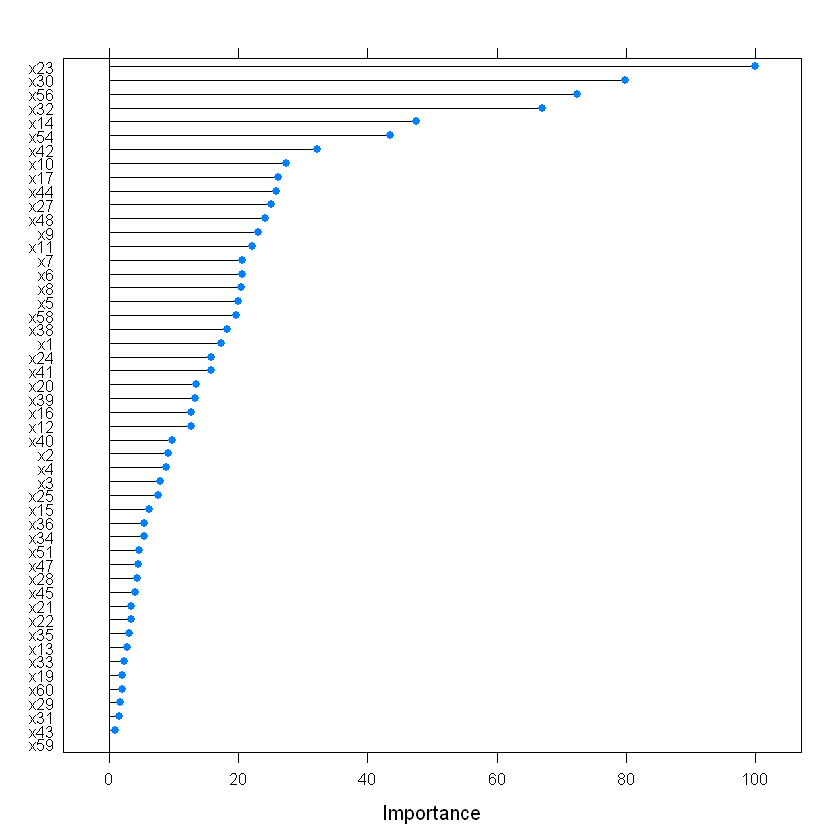

In [84]:
plot(varImp(RFfull))

## Read Importances 

In [25]:
library(feather)
path <- "importances"
# write_feather(imptable, path)
imptable <- read_feather(path)
imptable <- as.data.frame(imptable)

In [26]:
head(imptable,21)

Overall,variable
100.00000,22
79.91501,28
72.38483,47
66.97204,30
47.48650,14
43.54115,46
32.27760,39
27.43648,10
26.16710,17
25.82993,41


## Random Forest Reduced: 21 Col's

### Create Dataset 

In [27]:
cols <- c(imptable[c(1:21), "variable" ], 51); cols

[1] 22 28 47 30 14 46 39 10 17 41 25 44  9 11  7  6  8  5 48 35  1 51

In [45]:
submitcols <- cols[-22]

In [46]:
alltransformedred <- alltransformed[,..cols]
traintransformedred <- traintransformed[,..cols]
testtransformedred <- testtransformed[,..cols]
submittransformedred <- submittransformed[,..submitcols]

### Tuning Settings 

In [58]:
fitControl <- trainControl(method = "repeatedcv", number = 30, repeats = 3, summaryFunction = twoClassSummary,
                           verboseIter = TRUE, classProbs = TRUE, sampling = "up")
tunegrid <- expand.grid(.mtry=c(3,4,5,7), .splitrule = "gini", .min.node.size = c(50, 60, 90))

### Training Model

In [31]:
set.seed(13)
RF2 <- train(y~., data = traintransformedred, method="ranger",  num.trees = 700, metric = "ROC", preProc=c("center", "scale"),
              trControl = fitControl, tuneGrid = tunegrid, importance = 'permutation')
RF2

+ Fold01.Rep1: mtry=3, splitrule=gini, min.node.size=10 
- Fold01.Rep1: mtry=3, splitrule=gini, min.node.size=10 
+ Fold01.Rep1: mtry=4, splitrule=gini, min.node.size=10 
- Fold01.Rep1: mtry=4, splitrule=gini, min.node.size=10 
+ Fold01.Rep1: mtry=5, splitrule=gini, min.node.size=10 
- Fold01.Rep1: mtry=5, splitrule=gini, min.node.size=10 
+ Fold01.Rep1: mtry=7, splitrule=gini, min.node.size=10 
- Fold01.Rep1: mtry=7, splitrule=gini, min.node.size=10 
+ Fold01.Rep1: mtry=3, splitrule=gini, min.node.size=20 
- Fold01.Rep1: mtry=3, splitrule=gini, min.node.size=20 
+ Fold01.Rep1: mtry=4, splitrule=gini, min.node.size=20 
- Fold01.Rep1: mtry=4, splitrule=gini, min.node.size=20 
+ Fold01.Rep1: mtry=5, splitrule=gini, min.node.size=20 
- Fold01.Rep1: mtry=5, splitrule=gini, min.node.size=20 
+ Fold01.Rep1: mtry=7, splitrule=gini, min.node.size=20 
- Fold01.Rep1: mtry=7, splitrule=gini, min.node.size=20 
+ Fold01.Rep1: mtry=3, splitrule=gini, min.node.size=30 
- Fold01.Rep1: mtry=3, splitrul

Selecting tuning parameters
Fitting mtry = 3, splitrule = gini, min.node.size = 20 on full training set


Random Forest 

1453 samples
  21 predictor
   2 classes: 'a', 'b' 

Pre-processing: centered (21), scaled (21) 
Resampling: Cross-Validated (30 fold, repeated 3 times) 
Summary of sample sizes: 1405, 1404, 1405, 1404, 1404, 1404, ... 
Addtional sampling using up-sampling prior to pre-processing

Resampling results across tuning parameters:

  mtry  min.node.size  ROC        Sens       Spec     
  3     10             0.8698527  0.8735485  0.6345960
  3     20             0.8703410  0.8601768  0.6739899
  3     30             0.8694116  0.8464882  0.7058081
  4     10             0.8702819  0.8835919  0.6117003
  4     20             0.8692389  0.8699116  0.6545455
  4     30             0.8685154  0.8550217  0.6739057
  5     10             0.8677842  0.8866283  0.6201178
  5     20             0.8696448  0.8708542  0.6533670
  5     30             0.8693127  0.8540624  0.6720539
  7     10             0.8686695  0.8857191  0.6178451
  7     20             0.8677621  0.8741658  0.6533

### Testing Model 

In [32]:
predRF2 <- predict(RF2, testtransformedred ) # ,type = 'prob') #testdata 
Performance(predRF2, testtransformedred$y, prnt =1)

Setting levels: control = 1, case = 2
Setting direction: controls < cases


[1] "BA: "
[1] 0.7881902
Area under the curve: 0.7632


[1] 0.7757062

### Full Train 

In [59]:
set.seed(13)
RF2full <- train(y~., data = alltransformedred,  method="ranger",  num.trees = 700, metric = "Spec", preProc=c("center", "scale"),
              trControl = fitControl, tuneGrid = tunegrid, importance = 'permutation')
RF2full

+ Fold01.Rep1: mtry=3, splitrule=gini, min.node.size=50 
- Fold01.Rep1: mtry=3, splitrule=gini, min.node.size=50 
+ Fold01.Rep1: mtry=4, splitrule=gini, min.node.size=50 
- Fold01.Rep1: mtry=4, splitrule=gini, min.node.size=50 
+ Fold01.Rep1: mtry=5, splitrule=gini, min.node.size=50 
- Fold01.Rep1: mtry=5, splitrule=gini, min.node.size=50 
+ Fold01.Rep1: mtry=7, splitrule=gini, min.node.size=50 
- Fold01.Rep1: mtry=7, splitrule=gini, min.node.size=50 
+ Fold01.Rep1: mtry=3, splitrule=gini, min.node.size=60 
- Fold01.Rep1: mtry=3, splitrule=gini, min.node.size=60 
+ Fold01.Rep1: mtry=4, splitrule=gini, min.node.size=60 
- Fold01.Rep1: mtry=4, splitrule=gini, min.node.size=60 
+ Fold01.Rep1: mtry=5, splitrule=gini, min.node.size=60 
- Fold01.Rep1: mtry=5, splitrule=gini, min.node.size=60 
+ Fold01.Rep1: mtry=7, splitrule=gini, min.node.size=60 
- Fold01.Rep1: mtry=7, splitrule=gini, min.node.size=60 
+ Fold01.Rep1: mtry=3, splitrule=gini, min.node.size=90 
- Fold01.Rep1: mtry=3, splitrul

Selecting tuning parameters
Fitting mtry = 3, splitrule = gini, min.node.size = 90 on full training set


Random Forest 

2074 samples
  21 predictor
   2 classes: 'a', 'b' 

Pre-processing: centered (21), scaled (21) 
Resampling: Cross-Validated (30 fold, repeated 3 times) 
Summary of sample sizes: 2006, 2005, 2005, 2004, 2004, 2005, ... 
Addtional sampling using up-sampling prior to pre-processing

Resampling results across tuning parameters:

  mtry  min.node.size  ROC        Sens       Spec     
  3     50             0.8714700  0.8191501  0.7498775
  3     60             0.8714998  0.8104136  0.7583742
  3     90             0.8704048  0.7927592  0.7753676
  4     50             0.8706468  0.8306402  0.7321895
  4     60             0.8714828  0.8208353  0.7465278
  4     90             0.8711282  0.8046484  0.7720997
  5     50             0.8707550  0.8325593  0.7203840
  5     60             0.8708256  0.8246694  0.7328431
  5     90             0.8707795  0.8072287  0.7609886
  7     50             0.8668662  0.8351193  0.7190359
  7     60             0.8674787  0.8315110  0.7288

### Submission 

In [60]:
predRF2full <- predict(RF2full, submittransformedred  ,type = 'prob') #submit

In [61]:
send_submission(predRF2full$b, token, url=subm_url, submit_now= TRUE)

[1] "Format OK"
$submission
[0.0731,0.2981,0.6315,0.1177,0.6083,0.4599,0.474,0.6991,0.2075,0.0138,0.3313,0.4895,0.0618,0.8781,0.2753,0.1305,0.0578,0.3224,0.3325,0.0219,0.1904,0.5285,0.8589,0.02,0.7644,0.1165,0.5584,0.4968,0.5385,0.4379,0.5124,0.7449,0.0394,0.5458,0.7632,0.3465,0.7121,0.7296,0.8392,0.0512,0.2761,0.3059,0.155,0.8581,0.2862,0.8088,0.3411,0.0688,0.4328,0.2414,0.106,0.0443,0.2524,0.6374,0.7694,0.2452,0.8352,0.6674,0.4708,0.5962,0.8443,0.0194,0.4055,0.2588,0.1303,0.1676,0.0206,0.0327,0.5375,0.2532,0.6637,0.0541,0.0393,0.6048,0.373,0.295,0.7255,0.1317,0.5743,0.2743,0.8765,0.3751,0.0562,0.6959,0.4184,0.424,0.1469,0.1506,0.7156,0.4788,0.0482,0.0788,0.1968,0.7605,0.2322,0.4922,0.1624,0.2899,0.5586,0.5362,0.7082,0.0399,0.7142,0.5327,0.4684,0.5309,0.0499,0.3834,0.3444,0.1208,0.1069,0.7792,0.2716,0.7345,0.3008,0.0302,0.0343,0.4442,0.0943,0.0448,0.0563,0.1242,0.1217,0.2194,0.2971,0.0548,0.0398,0.444,0.7819,0.0744,0.7389,0.613,0.524,0.4961,0.5956,0.7415,0.164,0.6964,0.2086,0.7139,0.5

## Random Forest Reduced: 7 Col's

### Create Dataset 

In [130]:
cols <- c(imptable[c(1:7), "variable" ], 51); cols

[1] 22 28 47 30 14 46 39 51

In [131]:
traintransformedred2 <- traintransformed[,..cols]
testtransformedred2 <- testtransformed[,..cols]
submittransformedred2 <- submittransformed[,..cols[-8]]

### Tuning Settings 

In [132]:
fitControl <- trainControl(method = "repeatedcv", number = 10, repeats = 3, summaryFunction = twoClassSummary,
                           verboseIter = TRUE, classProbs = TRUE, sampling = "smote")
tunegrid <- expand.grid(.mtry=c(3,5,7), .splitrule = "gini", .min.node.size = c(10, 20, 30))

### Training Model

In [133]:
set.seed(13)
RF3 <- train(y~., data = traintransformedred2, method="ranger",  num.trees = 500, metric = "ROC", preProc=c("center", "scale"),
              trControl = fitControl, tuneGrid = tunegrid, importance = 'permutation')
RF3

+ Fold01.Rep1: mtry=3, splitrule=gini, min.node.size=10 


Warning message:
"package 'DMwR' was built under R version 3.6.3"Loading required package: grid


- Fold01.Rep1: mtry=3, splitrule=gini, min.node.size=10 
+ Fold01.Rep1: mtry=5, splitrule=gini, min.node.size=10 
- Fold01.Rep1: mtry=5, splitrule=gini, min.node.size=10 
+ Fold01.Rep1: mtry=7, splitrule=gini, min.node.size=10 
- Fold01.Rep1: mtry=7, splitrule=gini, min.node.size=10 
+ Fold01.Rep1: mtry=3, splitrule=gini, min.node.size=20 
- Fold01.Rep1: mtry=3, splitrule=gini, min.node.size=20 
+ Fold01.Rep1: mtry=5, splitrule=gini, min.node.size=20 
- Fold01.Rep1: mtry=5, splitrule=gini, min.node.size=20 
+ Fold01.Rep1: mtry=7, splitrule=gini, min.node.size=20 
- Fold01.Rep1: mtry=7, splitrule=gini, min.node.size=20 
+ Fold01.Rep1: mtry=3, splitrule=gini, min.node.size=30 
- Fold01.Rep1: mtry=3, splitrule=gini, min.node.size=30 
+ Fold01.Rep1: mtry=5, splitrule=gini, min.node.size=30 
- Fold01.Rep1: mtry=5, splitrule=gini, min.node.size=30 
+ Fold01.Rep1: mtry=7, splitrule=gini, min.node.size=30 
- Fold01.Rep1: mtry=7, splitrule=gini, min.node.size=30 
+ Fold02.Rep1: mtry=3, splitrul

Selecting tuning parameters
Fitting mtry = 3, splitrule = gini, min.node.size = 30 on full training set


Random Forest 

1453 samples
   7 predictor
   2 classes: 'a', 'b' 

Pre-processing: centered (7), scaled (7) 
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 1308, 1308, 1308, 1307, 1308, 1309, ... 
Addtional sampling using SMOTE prior to pre-processing

Resampling results across tuning parameters:

  mtry  min.node.size  ROC        Sens       Spec     
  3     10             0.8509218  0.8254629  0.6796825
  3     20             0.8540085  0.8294495  0.6947354
  3     30             0.8558302  0.8330720  0.6928571
  5     10             0.8291587  0.8236336  0.6451058
  5     20             0.8412838  0.8291410  0.6667989
  5     30             0.8438785  0.8373506  0.6741270
  7     10             0.8259510  0.8300639  0.6330423
  7     20             0.8298844  0.8300334  0.6452381
  7     30             0.8376705  0.8297331  0.6703704

Tuning parameter 'splitrule' was held constant at a value of gini
ROC was used to select the optimal model using 

### Testing Model 

In [134]:
predRF3 <- predict(RF3, testtransformedred2 ) # ,type = 'prob') #testdata 
Performance(predRF3, testtransformedred2$y, prnt =1)

Setting levels: control = 1, case = 2
Setting direction: controls < cases


[1] "BA: "
[1] 0.7590408
Area under the curve: 0.7282


[1] 0.7436379

## BEST MODEL

In [75]:
traindata <- alldata[,-c(50, 52, 57, 19, 26, 49, 29, 1, 47, 33, 11, 7, 2, 10, 4)]
testdata <- submitdata[,-c(50, 52, 57, 19, 26, 49, 29, 1, 47, 33, 11, 7, 2, 10, 4)]

In [76]:
set.seed(9560)
up_train <- upSample(x = traindata[, -ncol(traindata)],
                     y = as.factor(traindata$y))  

In [77]:
fitControl <- trainControl(method = "repeatedcv", number = 10, verboseIter = TRUE, classProbs = TRUE)
tunegrid2 <- expand.grid(.mtry=c(3,5,10,15), .splitrule = "gini", .min.node.size = 5)
set.seed(500)

In [78]:
RF11 <- train(Class~., data=up_train, method="ranger", trControl = fitControl, tuneGrid = tunegrid2)
RF11

+ Fold01.Rep1: mtry= 3, splitrule=gini, min.node.size=5 
- Fold01.Rep1: mtry= 3, splitrule=gini, min.node.size=5 
+ Fold01.Rep1: mtry= 5, splitrule=gini, min.node.size=5 
- Fold01.Rep1: mtry= 5, splitrule=gini, min.node.size=5 
+ Fold01.Rep1: mtry=10, splitrule=gini, min.node.size=5 
- Fold01.Rep1: mtry=10, splitrule=gini, min.node.size=5 
+ Fold01.Rep1: mtry=15, splitrule=gini, min.node.size=5 
- Fold01.Rep1: mtry=15, splitrule=gini, min.node.size=5 
+ Fold02.Rep1: mtry= 3, splitrule=gini, min.node.size=5 
- Fold02.Rep1: mtry= 3, splitrule=gini, min.node.size=5 
+ Fold02.Rep1: mtry= 5, splitrule=gini, min.node.size=5 
- Fold02.Rep1: mtry= 5, splitrule=gini, min.node.size=5 
+ Fold02.Rep1: mtry=10, splitrule=gini, min.node.size=5 
- Fold02.Rep1: mtry=10, splitrule=gini, min.node.size=5 
+ Fold02.Rep1: mtry=15, splitrule=gini, min.node.size=5 
- Fold02.Rep1: mtry=15, splitrule=gini, min.node.size=5 
+ Fold03.Rep1: mtry= 3, splitrule=gini, min.node.size=5 
- Fold03.Rep1: mtry= 3, splitru

Random Forest 

3130 samples
  45 predictor
   2 classes: 'a', 'b' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 2818, 2818, 2818, 2816, 2817, 2818, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   3    0.8977648  0.7955261
   5    0.9242774  0.8485516
  10    0.9341766  0.8683496
  15    0.9345042  0.8690065

Tuning parameter 'splitrule' was held constant at a value of gini

Tuning parameter 'min.node.size' was held constant at a value of 5
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were mtry = 15, splitrule = gini
 and min.node.size = 5.

In [79]:
set.seed(750)
predtest11rf <- predict(RF11,testdata,type = 'prob')  #testdata 

In [80]:
predtest11rf$b

[1] 0.0081000000 0.2304333333 0.2996666667 0.0127333333 0.6316666667
   [6] 0.2171333333 0.3353000000 0.3971000000 0.0979666667 0.0000000000
  [11] 0.2458000000 0.2835666667 0.0097000000 0.9572000000 0.2241333333
  [16] 0.0288000000 0.0024000000 0.1872333333 0.2107333333 0.0013333333
  [21] 0.1020333333 0.4368000000 0.9701000000 0.0020000000 0.6178666667
  [26] 0.0068000000 0.4323166667 0.5007000000 0.3941000000 0.2447666667
  [31] 0.5314000000 0.8896000000 0.0042000000 0.4181333333 0.6473000000
  [36] 0.2056333333 0.8425000000 0.8176666667 0.9635666667 0.0378769231
  [41] 0.1374333333 0.2340000000 0.0535333333 0.7206666667 0.2802333333
  [46] 0.8212000000 0.2421333333 0.0186666667 0.1699666667 0.1844000000
  [51] 0.0070000000 0.0152000000 0.0676666667 0.3855000000 0.7963666667
  [56] 0.3516666667 0.6930000000 0.5770000000 0.0656333333 0.6727333333
  [61] 0.8947000000 0.0065000000 0.0490666667 0.0685333333 0.0295000000
  [66] 0.0257000000 0.0000000000 0.0013333333 0.6933000000 0.0926333333
  [71] 0.5497333333 0.0112000000 0.0259000000 0.7133000000 0.0175666667
  [76] 0.2587333333 0.8810333333 0.0429666667 0.4982000000 0.1090000000
  [81] 0.9605666667 0.0601666667 0.0041000000 0.4005000000 0.1089333333
  [86] 0.3191333333 0.0013333333 0.0124000000 0.8527000000 0.3551000000
  [91] 0.0060000000 0.1005333333 0.0504333333 0.8371333333 0.0447666667
  [96] 0.3572666667 0.1077333333 0.0307000000 0.2626878788 0.4273666667
 [101] 0.6101222222 0.0129000000 0.6142666667 0.2521111111 0.4256000000
 [106] 0.5223484848 0.0052000000 0.2266666667 0.1019333333 0.0209333333
 [111] 0.0005000000 0.8899000000 0.1086666667 0.8201000000 0.2160666667
 [116] 0.0104000000 0.0000000000 0.4588666667 0.0094333333 0.0049000000
 [121] 0.0069000000 0.0976888889 0.0168666667 0.1442666667 0.1408000000
 [126] 0.0241333333 0.0162333333 0.2822333333 0.9684000000 0.0111000000
 [131] 0.5461333333 0.4009238095 0.2184000000 0.2657238095 0.3731333333
 [136] 0.6080848485 0.0640666667 0.7030333333 0.0944000000 0.8022000000
 [141] 0.4492121212 0.2287333333 0.3751333333 0.3484000000 0.2792809524
 [146] 0.1351000000 0.8183809524 0.1712333333 0.1637666667 0.0755000000
 [151] 0.0332000000 0.2812000000 0.1516666667 0.0651000000 0.0046000000
 [156] 0.1020333333 0.0941666667 0.6121666667 0.2545000000 0.9035666667
 [161] 0.0941666667 0.1363333333 0.0506666667 0.1403333333 0.0006666667
 [166] 0.5601698413 0.0701000000 0.5329000000 0.0053333333 0.1705000000
 [171] 0.7865666667 0.2734666667 0.3362666667 0.0036666667 0.6674666667
 [176] 0.0055000000 0.1553666667 0.3073787879 0.5515666667 0.9434666667
 [181] 0.8371000000 0.7311000000 0.5384333333 0.0062666667 0.8931476190
 [186] 0.0056666667 0.0000000000 0.1886333333 0.1562000000 0.2625000000
 [191] 0.0014666667 0.5615603426 0.6996333333 0.0979333333 0.0088000000
 [196] 0.0000000000 0.0388666667 0.0024000000 0.0624666667 0.8405181818
 [201] 0.4139545455 0.1778333333 0.1590000000 0.6871666667 0.1308666667
 [206] 0.5079000000 0.0260333333 0.9153238095 0.0373000000 0.6967515152
 [211] 0.0293000000 0.0000000000 0.0789333333 0.4612000000 0.2020333333
 [216] 0.7715619048 0.2104666667 0.0098000000 0.0020000000 0.0461000000
 [221] 0.0337333333 0.0038333333 0.2036000000 0.6280666667 0.1075666667
 [226] 0.1910666667 0.0609000000 0.8750000000 0.3838000000 0.0066666667
 [231] 0.8482000000 0.0066666667 0.4239666667 0.0460333333 0.0010000000
 [236] 0.0134000000 0.3428666667 0.1149666667 0.6033666667 0.6878666667
 [241] 0.0352000000 0.0326333333 0.0000000000 0.0431333333 0.0669666667
 [246] 0.0164000000 0.4932000000 0.7201181818 0.6024000000 0.0064000000
 [251] 0.0608666667 0.7918333333 0.6890666667 0.3941000000 0.0186333333
 [256] 0.4515666667 0.8425111111 0.0585666667 0.2087000000 0.1250333333
 [261] 0.5237818182 0.2995666667 0.0043000000 0.2965333333 0.5563666667
 [266] 0.3972333333 0.0077000000 0.1368666667 0.0564666667 0.1489000000
 [271] 0.3426333333 0.1790000000 0.2813666667 0.1376666667 0.0365333333
 [276] 0.1888000000 0.4273282051 0.04180000

The results of our final model is below:

rf11 
$auc   
[1] **0.9256214**

$ber   
[1] **0.8293232**

$score   
[1] **0.8774723**